<a id="top"></a> 
## Internal Links ##


### Section One - Data Building ###

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

-  [Build_hosp_df](#build_hosp_df).

-  [Build state_cd_df](#build-state_cd_df).

-  [Build week_cdh_df](#build-week_cdh_df).

-  [Build week_cdvh_df](#build-week_cdvh_df).

-  [Build state_cdh_df](#build-state_cdh_df).

-  [Build state_cvdh_df](#build-state_cvdh_df).

-  [Build us_cd_df](#build-us_cd_df).

-  [Build us_cdh_df](#build-us_cdh_df).

-  [Build us_cdvh_df](#build-us_cdvh_df).

-  [Build cumsum-week_cdvh_df](#build_cumsum-week_cdvh_df).

### Section Two - Plots ###
- [Section Two Plots](#section_two_plots).


In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import time

from importlib import reload #//*** Reload library reloads an external python File.

#//*** Use the whole window in the IPYNB editor
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import clear_output

from datetime import datetime
from pathlib import Path
import os
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import process_covid

ignore_folder = "anims"
current_dir = Path(os.getcwd()).absolute()

data_folder_name = "raw_data"

#//***  Raw and Processed Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename =  "z_us_death_cases.csv"
county_daily_df_filename = "z_county_daily_df.csv.zip"
aggregate_hospital_filename = "z_county_hospital_aggregate.csv.zip"
combined_daily_casevax_filename = "z_county_daily_casevax.csv.zip"
weekly_combined_filename = "z_county_weekly_df.csv.zip"
weekly_combined_historical_filename = "z_county_weekly_case_hosp_df.csv.zip"

#//*** Weekly Combined Cases,Deaths, Vaccines, Hospital
weekly_combined_cdvh_df_filename = "z_county_weekly_combined_cdvh_df.csv.zip"

#//*** Load Raw Hospital Data
#cd.add(process_covid.load_data(filename="z_county_hospital.csv.zip"),'raw_hosp_df',"Raw Unprocessed Hospital Data")

In [2]:
color_dict = {
    'c' : "#00aedb",
    'v' : "#a200ff",
    'd' : "#f47835",
    'h' : "#d41243",
    'i' : "#8ec127",
    'high' : "#4682B4",
    'med' : "#AEA1EA",
    'low' : "#8C54A1"
}

color_dict['low'] = "#3988ff"
color_dict['low'] = "#b468f2"

color_dict['med'] = "#eeb400"
color_dict['high'] = "#a6d298"

#//*** high old blue: B2EBF9

# Load Dataframe Collection Class #
**Simple Class to keep all Dataframes in a single structure. Each Dataframe has a description to help keep track** 

In [3]:
reload(process_covid)

cd = process_covid.collect_dataframes()

# Load Geopandas Dataframe Shape Files #

In [4]:
reload(process_covid)


#//*** get county shape file
geo_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')
geo_df['GEOID'] = geo_df['GEOID'].astype(int)
cd.add(geo_df,"county_geo_df","Geopandas DataFrame: Counties")

#//*** Get Shape File
#geo_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')
geo_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

geo_df['GEOID'] = geo_df['GEOID'].astype(int)

cd.add(geo_df,"state_geo_df","Geopandas DataFrame: States")


# Load Weekly County Confirmed Death Vax Hospitalizations #
<a id="build-week_cdvh_df"></a> [Top](#top)


In [5]:
reload(process_covid)

#//*****************************************************************************************
#//*** List of Tuples to rename columns.
#//*** This is just a convenience renaming
#//*** In the current version only the sum cols which represent total hospital bed days.
#//*** the avg values are for average daily hospital beds
#//*****************************************************************************************
rename_cols_sum = [('total_beds_7_day_sum',"all_bed_types"),
                   ('inpatient_beds_7_day_sum','beds'),
                   ('inpatient_beds_used_7_day_sum','beds_used'),
                   ('inpatient_beds_used_covid_7_day_sum','beds_covid'),
                   ('total_icu_beds_7_day_sum','all_icu'),
                   ('icu_beds_used_7_day_sum','icu_used'),
                   ('staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum','icu_covid'),
                   ('total_vaccinated_percent','vax_pct'),
                   ('total_vaccinated_count','vax_ct'),
                   ('first_dose_pct','first_pct'),
                   ('first_dose_count','first_ct'),
                   ('Admin2','cty'),
                   ('Population','pop'),
                   ('New_Confirm_100k','tc_100k'),
                   ('New_Confirm_avg_daily_100k','nc_avg_daily_100k'),
                   ('New_Deaths_100k','td_100k'),
                   ('New_Deaths_avg_daily_100k','nd_avg_daily_100k'),
                  ]



#//*** We're bolting on a More efficient Calculate Section. Need to cleanup Download and Process to make it faster and more efficient
remove_cols = ['first_pct','first_ct','case_7_day_avg', 'death_7_day_avg',
       'case_100k_avg', 'death_100k_avg', 'case_scaled_100k',
       'death_scaled_100k', 'pv_tot_confirm', 'pv_tot_death','all_bed_types','Province_State']

#//*****************************************************************************************
#//*** Load the Combined Weekly data of vaccinations, Confirmed, hospitalizations, & Deaths
#//*****************************************************************************************
df = process_covid.load_data(
    filename=weekly_combined_cdvh_df_filename,
     #//*** Rename Columns for readability using a list of tuples in (find,replace) format
    rename_cols = rename_cols_sum,
    remove_cols=remove_cols,
    auto_convert_to_float = True
    )                                      

dfs = []
disp_cols = ['Date', 'FIPS', 'Recip_State', 'cty', 'Combined_Key', 'pop', 'vax_pct', 'vax_ct', 'tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths', 'all_bed_types', 'beds', 'beds_used', 'beds_covid', 'all_icu', 'icu_used', 'icu_covid']
disp_cols = ['Date', 'FIPS', 'Recip_State', 'cty', 'Combined_Key', 'pop', 'vax_pct', 'vax_ct', 'tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths', 'beds_covid', 'icu_covid','beds', 'beds_used','all_icu', 'icu_used']
display(df.columns)
#//*** Group by FIPS and perform a standard recalc
#//*** This keeps the ccalculations identical across all Aggregation levels
for group in df.groupby("FIPS"):
    #tdf = group[1].copy()[disp_cols]
    tdf = process_covid.standard_recalc_cols(group[1])

    dfs.append(tdf)


cd.add(pd.concat(dfs),'week_cdvh_df','County/Weekly Confirmed, Death,Vaccine, Hospitalization')
df=cd.get('week_cdvh_df')
display(df[df['FIPS'] == 30063])


Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid'],
      dtype='object')

Date     FIPS Recip_State  vax_pct   vax_ct       cty  \
1171 2020-12-18  30063.0          MT      0.0      0.0  Missoula   
1408 2020-12-25  30063.0          MT      0.0      0.0  Missoula   
1091 2021-01-01  30063.0          MT      0.0      0.0  Missoula   
1381 2021-01-08  30063.0          MT      0.0      0.0  Missoula   
420  2021-01-15  30063.0          MT      1.4   1725.0  Missoula   
810  2021-01-22  30063.0          MT      2.0   2395.0  Missoula   
746  2021-01-29  30063.0          MT      3.0   3571.0  Missoula   
1685 2021-02-05  30063.0          MT      3.6   4287.0  Missoula   
1200 2021-02-12  30063.0          MT      4.7   5672.0  Missoula   
689  2021-02-19  30063.0          MT      6.8   8102.0  Missoula   
1791 2021-02-26  30063.0          MT      9.1  10847.0  Missoula   
478  2021-03-05  30063.0          MT     10.7  12825.0  Missoula   
1241 2021-03-12  30063.0          MT     13.6  16312.0  Missoula   
9    2021-03-19  30063.0          MT     15.4  18426.0  Missoula   
2031 2021-03-26  30063.0          MT     17.2  20622.0  Missoula   
1270 2021-04-02  30063.0          MT     20.4  24370.0  Missoula   
1701 2021-04-09  30063.0          MT     25.6  30636.0  Missoula   
1735 2021-04-16  30063.0          MT     31.2  37302.0  Missoula   
107  2021-04-23  30063.0          MT     36.7  43914.0  Missoula   
1310 2021-04-30  30063.0          MT     41.2  49251.0  Missoula   
558  2021-05-07  30063.0          MT     43.7  52323.0  Missoula   
2362 2021-05-14  30063.0          MT     45.5  54402.0  Missoula   
340  2021-05-21  30063.0          MT     47.2  56445.0  Missoula   
1314 2021-05-28  30063.0          MT     48.8  58345.0  Missoula   
841  2021-06-04  30063.0          MT     49.1  58724.0  Missoula   
2263 2021-06-11  30063.0          MT     50.8  60777.0  Missoula   
2148 2021-06-18  30063.0          MT     52.1  62299.0  Missoula   
491  2021-06-25  30063.0          MT     52.5  62750.0  Missoula   
1310 2021-07-02  30063.0          MT     53.1  63458.0  Missoula   
722  2021-07-09  30063.0          MT     53.3  63767.0  Missoula   
1105 2021-07-16  30063.0          MT     53.6  64047.0  Missoula   
1637 2021-07-23  30063.0          MT     53.8  64324.0  Missoula   
956  2021-07-30  30063.0          MT     54.0  64603.0  Missoula   
68   2021-08-06  30063.0          MT     54.3  64896.0  Missoula   
1363 2021-08-13  30063.0          MT     54.6  65290.0  Missoula   
706  2021-08-20  30063.0          MT     55.0  65747.0  Missoula   
821  2021-08-27  30063.0          MT     55.4  66273.0  Missoula   
1156 2021-09-03  30063.0          MT     55.8  66784.0  Missoula   
2387 2021-09-10  30063.0          MT     56.2  67268.0  Missoula   
977  2021-09-17  30063.0          MT     56.6  67747.0  Missoula   
1601 2021-09-24  30063.0          MT     57.0  68144.0  Missoula   
548  2021-10-01  30063.0          MT     57.2  68451.0  Missoula   
1601 2021-10-08  30063.0          MT     57.6  68891.0  Missoula   
925  2021-10-15  30063.0          MT     57.9  69200.0  Missoula   
243  2021-10-22  30063.0          MT     58.3  69673.0  Missoula   
1789 2021-10-29  30063.0          MT     58.6  70104.0  Missoula   
2243 2021-11-05  30063.0          MT     58.8  70362.0  Missoula   
2040 2021-11-12  30063.0          MT     59.0  70592.0  Missoula   
301  2021-11-19  30063.0          MT     59.3  70970.0  Missoula   
632  2021-11-26  30063.0          MT     59.5  71132.0  Missoula   
1979 2021-12-03  30063.0          MT     59.9  71581.0  Missoula   
154  2021-12-10  30063.0          MT     61.1  73060.0  Missoula   
420  2021-12-17  30063.0          MT     62.0  74120.0  Missoula   
1615 2021-12-24  30063.0          MT     62.2  74432.0  Missoula   
2424 2021-12-31  30063.0          MT     62.3  74570.0  Missoula   
624  2022-01-07  30063.0          MT     62.5  74787.0  Missoula   
1245 2022-01-14  30063.0          MT     62.8  75106.0  Missoula   
1223 2022-01-21  30063.0          MT     63.1  75500.0  Missoula   

In [6]:
"""
reload(process_covid)

#//*****************************************************************************************
#//*** List of Tuples to rename columns.
#//*** This is just a convenience renaming
#//*** In the current version only the sum cols which represent total hospital bed days.
#//*** the avg values are for average daily hospital beds
#//*****************************************************************************************
rename_cols_sum = [('total_beds_7_day_sum',"all_bed_types"),
                   ('inpatient_beds_7_day_sum','beds'),
                   ('inpatient_beds_used_7_day_sum','beds_used'),
                   ('inpatient_beds_used_covid_7_day_sum','beds_covid'),
                   ('total_icu_beds_7_day_sum','all_icu'),
                   ('icu_beds_used_7_day_sum','icu_used'),
                   ('staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum','icu_covid'),
                   ('total_vaccinated_percent','vax_pct'),
                   ('total_vaccinated_count','vax_ct'),
                   ('first_dose_pct','first_pct'),
                   ('first_dose_count','first_ct'),
                   ('Admin2','cty'),
                   ('Population','pop'),
                   ('New_Confirm_100k','tc_100k'),
                   ('New_Confirm_avg_daily_100k','nc_avg_daily_100k'),
                   ('New_Deaths_100k','td_100k'),
                   ('New_Deaths_avg_daily_100k','nd_avg_daily_100k'),
                  ]

rename_cols_avg = [('total_beds_7_day_avg',"all_bed_types"),
                   ('inpatient_beds_7_day_avg','beds'),
                   ('inpatient_beds_used_7_day_avg','beds_used'),
                   ('inpatient_beds_used_covid_7_day_avg','beds_covid'),
                   ('total_icu_beds_7_day_avg','all_icu'),
                   ('icu_beds_used_7_day_avg','icu_used'),
                   ('staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg','icu_covid'),
                   ('total_vaccinated_percent','vax_pct'),
                   ('total_vaccinated_count','vax_ct'),
                   ('first_dose_pct','first_pct'),
                   ('first_dose_count','first_ct'),
                   ('Admin2','cty'),
                   ('Population','pop'),
                   ('New_Confirm_100k','tc_100k'),
                   ('New_Confirm_avg_daily_100k','nc_avg_daily_100k'),
                   ('New_Deaths_100k','td_100k'),
                   ('New_Deaths_avg_daily_100k','nd_avg_daily_100k'),
                  ]

#//*****************************************************************************************
#//*** Load the Combined Weekly data of vaccinations, Confirmed, hospitalizations, & Deaths
#//*****************************************************************************************
df = process_covid.load_data(
    filename=weekly_combined_cdvh_df_filename,
     #//*** Rename Columns for readability using a list of tuples in (find,replace) format
    rename_cols = rename_cols_sum,

    auto_convert_to_float = True
    )                                      

#//*** Disp_cols acts as a filter, only show these columns. Column Filters preserve the original data
disp_cols = ['Date', 'FIPS', 'Recip_State', 'cty', 'Combined_Key', 'pop', 'vax_pct', 'vax_ct', 'tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths', 'tc_100k', 'nc_avg_daily_100k', 'td_100k', 'nd_avg_daily_100k', 'all_bed_types', 'beds', 'beds_used', 'beds_covid', 'all_icu', 'icu_used', 'icu_covid']
disp_cols = ['Date', 'FIPS', 'Recip_State', 'cty', 'Combined_Key', 'pop', 'vax_pct', 'vax_ct', 'tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths', 'all_bed_types', 'beds', 'beds_used', 'beds_covid', 'all_icu', 'icu_used', 'icu_covid']

#//*** Filter the results by disp_cols
df = df[disp_cols]

#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="FIPS",suffix="_tot")

#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="FIPS",prefix="pv_",suffix="_tot")
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="FIPS",prefix="pv_",suffix="_tot",zero=True)

#//*** Filtering More Columns 
disp_cols = ['Date', 'FIPS', 'Recip_State', 'cty', 'Combined_Key', 'pop', 'vax_pct',
             'vax_ct', 'tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths',
             'beds_covid', 'icu_covid', 'beds_covid_tot', 'icu_covid_tot',
             'pv_New_Confirm_tot', 'pv_New_Deaths_tot', 'pv_beds_covid_tot',
             'pv_icu_covid_tot']

df = df[disp_cols]

#//*** Build 100k for these columns
df = process_covid.build_100k(df,cols=['vax_ct','tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths',
                                       'beds_covid', 'icu_covid', 'beds_covid_tot', 'icu_covid_tot',
                                       'pv_New_Confirm_tot', 'pv_New_Deaths_tot', 'pv_beds_covid_tot',
                                        'pv_icu_covid_tot'])

#disp_cols = disp_cols + ['beds_covid_tot', 'icu_covid_tot','vax_ct_100k']

#display(df.columns)

display(df.head())
display(df[df['FIPS'] == 30063][['pop','beds_covid','beds_covid_tot','pv_beds_covid_tot','beds_covid_tot_100k','pv_beds_covid_tot_100k','icu_covid','icu_covid_tot','pv_icu_covid_tot','icu_covid_tot_100k','pv_icu_covid_tot_100k']])

cd.add(df,'week_cdvh_df','County/Weekly Confirmed, Death,Vaccine, Hospitalization')

del df
"""
print("To Obsolete")

To Obsolete


# Load Daily County Cases and Deaths #

In [7]:
cd.add(process_covid.load_data(filename=county_daily_df_filename,remove_cols=['case_7_day_avg','death_7_day_avg','case_100k_avg','death_100k_avg','case_scaled_100k','death_scaled_100k']),'county_daily_df',"County/Daily Cases and Deaths")





# Load Weekly County Hospitalizations # 

<a id="build_hosp_df"></a> [Top](#top)


In [8]:
#//****************************************************************************************
#//*** Load aggregated (summed by county) Hospital Data, provides cleanest cumsum values
#//****************************************************************************************
df = process_covid.load_data(
    filename=aggregate_hospital_filename,
    #//*** Rename Columns for readability using a list of tuples in (find,replace) format
    rename_cols = [('total_beds_7_day_sum',"all_bed_types"),
                   ('inpatient_beds_7_day_sum','beds'),
                   ('inpatient_beds_used_7_day_sum','beds_used'),
                   ('inpatient_beds_used_covid_7_day_sum','beds_covid'),
                   ('total_icu_beds_7_day_sum','all_icu'),
                   ('icu_beds_used_7_day_sum','icu_used'),
                   ('staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum','icu_covid'),
                   ('collection_week',"Date"),
                  ])
df['Date'] = pd.to_datetime(df['Date'])
df = process_covid.cumsum_cols(df,cols=['beds_covid','icu_covid'], by='fips_code', date_col="Date", suffix="_tot")
cd.add(df,'hosp_df',"County/Weekly Hospitalization Data")
display(df.head())

Date fips_code state all_bed_types   beds beds_used beds_covid  \
0 2020-07-31    1001.0    AL         574.0  455.0     363.0      119.0   
1 2020-07-31   35051.0    NM          34.0   20.0      12.0        1.0   
2 2020-07-31   48087.0    TX         253.0  239.0      91.0        0.0   
3 2020-07-31   17075.0    IL         125.0  125.0      16.0        1.0   
4 2020-07-31    8014.0    CO           0.0    0.0       0.0       23.0   

  all_icu icu_used icu_covid beds_covid_tot icu_covid_tot  
0    42.0     40.0      28.0          119.0          28.0  
1     0.0      0.0       0.0            1.0           0.0  
2     0.0      0.0       0.0            0.0           0.0  
3    30.0      0.0       0.0            1.0           0.0  
4     0.0      0.0      11.0           23.0          11.0

# Build: Weekly Confirm Death Hospitalization #
<a id="build-week_cdh_df"></a> [Top](#top)

Hospitalizations without Vaccines provides 5 months of additional hospitalization data

In [9]:
reload(process_covid)
#//*** Build Weekly Case Death & Hospital

    
dates =  cd.get('hosp_df')['Date'].unique()

#print(dates)

#//*** Get Weekly Values
df = cd.get('county_daily_df')
df['Date'] = df['Date'].apply(lambda x: pd.Timestamp(x))
dates = cd.get('hosp_df')['Date'].apply(lambda x: pd.Timestamp(x))

#//*** Soo Slick. Select dates from a unique list of dates in hospital
df = df [ df['Date'].isin(dates)]

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="FIPS",suffix="")
#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['New_Confirm', 'New_Deaths'],by="FIPS",suffix="_tot")

#//*** Combine Weekly Valuess with Hospital
df = process_covid.merge_df(df,cd.get('hosp_df'),left_col="FIPS",right_col="fips_code")

#//*** Rename Population Column to pop
df.columns = ['pop' if item == 'Population' else item for item in list(df.columns)]

display(df)
display(df [df["FIPS"] == 1003].iloc[:10])

#//*** Load Weekly Case Death Hospital
cd.add(df,'week_cdh_df','County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08')


Elapsed Time: 0s


Date   FIPS      Admin2 Province_State                Combined_Key  \
0    2020-07-31   1001     Autauga        Alabama        Autauga, Alabama, US   
1    2020-07-31  40069    Johnston       Oklahoma      Johnston, Oklahoma, US   
2    2020-07-31  40071         Kay       Oklahoma           Kay, Oklahoma, US   
3    2020-07-31   6021       Glenn     California       Glenn, California, US   
4    2020-07-31  40073  Kingfisher       Oklahoma    Kingfisher, Oklahoma, US   
...         ...    ...         ...            ...                         ...   
2429 2022-05-13  36019     Clinton       New York       Clinton, New York, US   
2430 2022-05-13  36021    Columbia       New York      Columbia, New York, US   
2431 2022-05-13  19081     Hancock           Iowa           Hancock, Iowa, US   
2432 2022-05-13  36005       Bronx       New York         Bronx, New York, US   
2433 2022-05-13   6099  Stanislaus     California  Stanislaus, California, US   

          pop  tot_confirm  tot_deaths  New_Confirm  New_Deaths  \
0       55869         1042          20          0.0         0.0   
1       11085           39           0          0.0         0.0   
2       43538          207          10          0.0         0.0   
3       28393          304           1          0.0         0.0   
4       15765          101           0          0.0         0.0   
...       ...          ...         ...          ...         ...   
2429    80485        18034          90        257.0         0.0   
2430    59461        10772         141        165.0         1.0   
2431    10630         2867          47         19.0         0.0   
2432  1418207       417625        7745       2973.0         4.0   
2433   550660       136234        1645        407.0         2.0   

      New_Confirm_tot  New_Deaths_tot fips_code state all_bed_types     beds  \
0                 0.0             0.0    1001.0    AL         574.0    455.0   
1                 0.0             0.0   40069.0    OK         252.0    252.0   
2                 0.0             0.0   40071.0    OK         505.0    376.0   
3                 0.0             0.0    6021.0    CA         320.0    235.0   
4                 0.0             0.0   40073.0    OK         651.0    651.0   
...               ...             ...       ...   ...           ...      ...   
2429          17908.0            86.0   36019.0    NY           0.0   1289.0   
2430          10256.0           104.0   36021.0    NY           0.0    700.0   
2431           2753.0            45.0   19081.0    IA         259.0    140.0   
2432         366386.0          2889.0   36005.0    NY       15851.0  24909.0   
2433         127125.0          1485.0    6099.0    CA        3171.0   6794.0   

     beds_used beds_covid all_icu icu_used icu_covid beds_covid_tot  \
0        363.0      119.0    42.0     40.0      28.0          119.0   
1         41.0        0.0     0.0      0.0       0.0            0.0   
2        162.0       31.0    70.0     26.0      30.0           31.0   
3        110.0       14.0     0.0      0.0       0.0           14.0   
4         55.0        0.0     0.0      0.0       0.0            0.0   
...        ...        ...     ...      ...       ...            ...   
2429    1220.0      189.0    83.0     76.0      11.0         9315.0   
2430     547.0      144.0    42.0     37.0       8.0         7254.0   
2431      68.0        5.0     0.0      0.0       0.0          670.0   
2432   19264.0      676.0  3237.0   2165.0      66.0       154649.0   
2433    5488.0      217.0  1071.0    491.0      30.0        82659.0   

     icu_covid_tot  
0             28.0  
1              0.0  
2             30.0  
3              0.0  
4              0.0  
...            ...  
2429        1123.0  
2430         923.0  
2431           0.0  
2432       29537.0  
2433       15798.0  

[228679 rows x 23 columns]

Date  FIPS   Admin2 Province_State          Combined_Key     pop  \
2396 2020-07-31  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1917 2020-08-07  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1445 2020-08-14  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1157 2020-08-21  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
854  2020-08-28  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1362 2020-09-04  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
1946 2020-09-11  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
520  2020-09-18  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
877  2020-09-25  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   
714  2020-10-02  1003  Baldwin        Alabama  Baldwin, Alabama, US  223234   

      tot_confirm  tot_deaths  New_Confirm  New_Deaths  New_Confirm_tot  \
2396         3116          21          0.0         0.0              0.0   
1917         3533          23        417.0         2.0            417.0   
1445         3881          29        348.0         6.0            765.0   
1157         4100          32        219.0         3.0            984.0   
854          4408          35        308.0         3.0           1292.0   
1362         4654          42        246.0         7.0           1538.0   
1946         4881          43        227.0         1.0           1765.0   
520          5016          48        135.0         5.0           1900.0   
877          5419          50        403.0         2.0           2303.0   
714          6009          53        590.0         3.0           2893.0   

      New_Deaths_tot fips_code state all_bed_types    beds beds_used  \
2396             0.0    1003.0    AL        2961.0  2541.0    2140.0   
1917             2.0    1003.0    AL        2961.0  2541.0    2136.0   
1445             8.0    1003.0    AL        2961.0  2541.0    2078.0   
1157            11.0    1003.0    AL        2961.0  2541.0    2041.0   
854             14.0    1003.0    AL        2961.0  2541.0    1949.0   
1362            21.0    1003.0    AL        2961.0  2541.0    1903.0   
1946            22.0    1003.0    AL        2753.0  2359.0    1677.0   
520             27.0    1003.0    AL        2961.0  2541.0    2061.0   
877             29.0    1003.0    AL        2961.0  2541.0    1884.0   
714             32.0    1003.0    AL        2961.0  2541.0    1961.0   

     beds_covid all_icu icu_used icu_covid beds_covid_tot icu_covid_tot  
2396      487.0   224.0    263.0     153.0          487.0         153.0  
1917      488.0   224.0    276.0     142.0          975.0         295.0  
1445      422.0   224.0    250.0     106.0         1397.0         401.0  
1157      313.0   224.0    252.0      91.0         1710.0         492.0  
854       263.0   224.0    215.0      65.0         1973.0         557.0  
1362      185.0   224.0    210.0      50.0         2158.0         607.0  
1946      148.0   207.0    174.0      39.0         2306.0         646.0  
520       194.0   224.0    198.0      49.0         2500.0         695.0  
877       198.0   224.0    182.0      47.0         2698.0         742.0  
714       162.0   224.0    175.0      41.0         2860.0         783.0

In [10]:
cd.l()

Collected Dataframe Count:  6
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08


# Daily Confirmed Deaths: States #
<a id="build-state_cd_df"></a> [Top](#top)


In [11]:
reload(process_covid)

df = cd.get('county_daily_df')
display(df)
df.columns = ['pop' if item == 'Population' else item for item in list(df.columns)]

sum_cols = ['pop','tot_confirm','tot_deaths']

state_list = []
for state_group in df.groupby("Province_State"):
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    loop_df =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[2:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        build_100k = False,
        verbose = False,
        #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]

        #outcome_ratios = [
        #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
        #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
        #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
        #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
        #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
        #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
        #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
        #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
        #    ('beds_tot','beds_covid_tot','bcbtr'), #//*** Beds Covid to Total Beds Ratio - bcbtr

        #],
    )
    state_list.append(loop_df)

df = pd.concat(state_list)

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")
#//*** Build confirm and death running totals
#df = process_covid.cumsum_cols(df,cols=['New_Confirm', 'New_Deaths'],by="state",suffix="_tot")

#//*** BUild 100k Columns
df = process_covid.build_100k(df,cols=list(df.columns)[3:])

cd.add(df,'state_cd_df',"State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]")

df = cd.get('state_cd_df')
df[df['state'] == "California"].iloc[50:100]


Date   FIPS     Admin2 Province_State              Combined_Key  \
7   2020-01-29   1001    Autauga        Alabama      Autauga, Alabama, US   
8   2020-01-30   1001    Autauga        Alabama      Autauga, Alabama, US   
9   2020-01-31   1001    Autauga        Alabama      Autauga, Alabama, US   
10  2020-02-01   1001    Autauga        Alabama      Autauga, Alabama, US   
11  2020-02-02   1001    Autauga        Alabama      Autauga, Alabama, US   
..         ...    ...        ...            ...                       ...   
833 2022-05-04  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
834 2022-05-05  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
835 2022-05-06  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
836 2022-05-07  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   
837 2022-05-08  80047  Out of TN      Tennessee  Out of TN, Tennessee, US   

     Population  tot_confirm  tot_deaths  New_Confirm  New_Deaths  
7         55869            0           0          0.0         0.0  
8         55869            0           0          0.0         0.0  
9         55869            0           0          0.0         0.0  
10        55869            0           0          0.0         0.0  
11        55869            0           0          0.0         0.0  
..          ...          ...         ...          ...         ...  
833           0        48804         273         34.0         0.0  
834           0        48834         272         30.0         0.0  
835           0        48863         272         29.0         0.0  
836           0        48885         272         22.0         0.0  
837           0        48746         272          0.0         0.0  

[2661605 rows x 10 columns]

Date       state       pop  tot_confirm  tot_deaths  New_Confirm  \
2551 2020-03-19  California  39512223          983          20        190.0   
2611 2020-03-20  California  39512223         1244          23        261.0   
2673 2020-03-21  California  39512223         1396          26        152.0   
2721 2020-03-22  California  39512223         1697          36        301.0   
2792 2020-03-23  California  39512223         2073          40        376.0   
2814 2020-03-24  California  39512223         2501          51        428.0   
2889 2020-03-25  California  39512223         3013          66        512.0   
2922 2020-03-26  California  39512223         3879          80        866.0   
2999 2020-03-27  California  39512223         4537         100        658.0   
3024 2020-03-28  California  39512223         7514         188       2977.0   
3099 2020-03-29  California  39512223         5495         132      -2019.0   
3122 2020-03-30  California  39512223         6864         149       1369.0   
3163 2020-03-31  California  39512223         8011         170       1147.0   
3253 2020-04-01  California  39512223         9265         198       1254.0   
3277 2020-04-02  California  39512223        10764         236       1499.0   
3344 2020-04-03  California  39512223        12088         273       1324.0   
3377 2020-04-04  California  39512223        12834         292        746.0   
3421 2020-04-05  California  39512223        14489         342       1655.0   
3507 2020-04-06  California  39512223        15956         371       1467.0   
3521 2020-04-07  California  39512223        17054         424       1098.0   
3593 2020-04-08  California  39512223        18409         485       1355.0   
3631 2020-04-09  California  39512223        19532         537       1123.0   
3691 2020-04-10  California  39512223        20748         577       1216.0   
3753 2020-04-11  California  39512223        21457         599        709.0   
3780 2020-04-12  California  39512223        22196         632        739.0   
3838 2020-04-13  California  39512223        23406         696       1210.0   
3921 2020-04-14  California  39512223        24544         781       1138.0   
3976 2020-04-15  California  39512223        26356         873       1812.0   
4017 2020-04-16  California  39512223        27578         955       1222.0   
4064 2020-04-17  California  39512223        29296        1023       1718.0   
4116 2020-04-18  California  39512223        30642        1127       1346.0   
4158 2020-04-19  California  39512223        31307        1159        665.0   
4214 2020-04-20  California  39512223        33562        1199       2255.0   
4234 2020-04-21  California  39512223        35753        1287       2191.0   
4326 2020-04-22  California  39512223        37748        1412       1995.0   
4361 2020-04-23  California  39512223        39596        1502       1848.0   
4395 2020-04-24  California  39512223        41466        1585       1870.0   
4465 2020-04-25  California  39512223        42432        1660        966.0   
4522 2020-04-26  California  39512223        43735        1692       1303.0   
4563 2020-04-27  California  39512223        45313        1732       1578.0   
4619 2020-04-28  California  39512223        46828        1827       1515.0   
4658 2020-04-29  California  39512223        49225        1910       2397.0   
4739 2020-04-30  California  39512223        50714        1999       1489.0   
4789 2020-05-01  California  39512223        52548        2095       1834.0   
4819 2020-05-02  California  39512223        53886        2157       1338.0   
4848 2020-05-03  California  39512223        55253        2199       1367.0   
4936 2020-05-04  California  39512223        56613        2244       1360.0   
4979 2020-05-05  California  39512223        59201        2357       2588.0   
5011 2020-05-06  California  39512223        61080        2441       1879.0   
5056 2020-05-07  California  39512223        63005        251

In [12]:
# Add GeoPandas State and County Levels

In [13]:
cd.l()


Collected Dataframe Count:  7
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]


# Weekly Confirmed Deaths Hospitalization: States #

<a id="build-state_cdh_df"></a> [Top](#top)


In [14]:

reload(process_covid)

sum_cols = ['pop','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','icu_used']

state_list = []
for state_group in cd.get('week_cdh_df').groupby("Province_State"):
    #display(state_group[1])
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    loop_df =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        #build_100k = True,
        verbose = False,

    )
    state_list.append(loop_df)


          
df = pd.concat(state_list)

df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="state",suffix="_tot")

#//*** BUild 100k Columns
df = process_covid.build_100k(df,cols=list(df.columns)[3:])

#df['rbcbtr'] = df['beds_covid'] / df['beds'] 
cd.add(df,'state_cdh_df','State Weekly Cases Deaths Hospitals')
df = cd.get('state_cdh_df')
df[df['state'] == "California"]


Date       state       pop  tot_confirm  tot_deaths beds_covid  \
32   2020-07-31  California  39508089       506937        9122    51626.0   
91   2020-08-07  California  39508089       553701       10019    46828.0   
112  2020-08-14  California  39508089       619802       11012    43542.0   
173  2020-08-21  California  39508089       662858       11802    38523.0   
246  2020-08-28  California  39508089       699733       12638    33135.0   
275  2020-09-04  California  39508089       733228       13501    28397.0   
314  2020-09-11  California  39479696       756009       14115    24890.0   
362  2020-09-18  California  39508089       780954       14825    22915.0   
452  2020-09-25  California  39508089       805719       15391    21865.0   
500  2020-10-02  California  39479696       828541       15971    20989.0   
531  2020-10-09  California  39508089       853033       16400    21339.0   
567  2020-10-16  California  39445281       874306       16814    20868.0   
638  2020-10-23  California  39508089       905205       17231    20978.0   
702  2020-10-30  California  39508089       935587       17569    23250.0   
746  2020-11-06  California  39508089       973303       17913    26599.0   
768  2020-11-13  California  39479696      1027188       18202    34002.0   
830  2020-11-20  California  39479696      1112479       18651    45850.0   
882  2020-11-27  California  39508089      1214179       19131    61840.0   
935  2020-12-04  California  39508089      1355266       19798    79811.0   
1002 2020-12-11  California  39508089      1579211       20822   106069.0   
1070 2020-12-18  California  39508089      1876450       22373   130459.0   
1103 2020-12-25  California  39508089      2147716       23916   144780.0   
1152 2021-01-01  California  39508089      2435503       26258   153920.0   
1207 2021-01-08  California  39508089      2728957       29069   164061.0   
1236 2021-01-15  California  39508089      3015264       32390   144226.0   
1318 2021-01-22  California  39508089      3204770       35664   124903.0   
1326 2021-01-29  California  39508089      3348597       39438   102809.0   
1418 2021-02-05  California  39508089      3452250       43124    82782.0   
1459 2021-02-12  California  39508089      3527874       46044    63127.0   
1484 2021-02-19  California  39508089      3577436       48528    48102.0   
1562 2021-02-26  California  39508089      3618426       51727    36563.0   
1594 2021-03-05  California  39508089      3650319       53660    28620.0   
1651 2021-03-12  California  39508089      3677440       55166    24557.0   
1693 2021-03-19  California  39508089      3696701       56217    20666.0   
1766 2021-03-26  California  39508089      3715790       57770    18053.0   
1802 2021-04-02  California  39508089      3735898       58706    16130.0   
1859 2021-04-09  California  39508089      3755391       59383    14918.0   
1929 2021-04-16  California  39508089      3776358       59950    14609.0   
1987 2021-04-23  California  39508089      3791112       60410    14339.0   
2038 2021-04-30  California  39508089      3805132       60876    13191.0   
2061 2021-05-07  California  39508089      3818797       61305    12346.0   
2138 2021-05-14  California  39508089      3830416       61533    11388.0   
2154 2021-05-21  California  39508089      3839465       61796    10044.0   
2226 2021-05-28  California  39508089      3852163       62099     9229.0   
2249 2021-06-04  California  39508089      3858565       62330     8932.0   
2324 2021-06-11  California  39508089      3865894       62590     8403.0   
2395 2021-06-18  California  39508089      3872449       62693     8385.0   
2417 2021-06-25  California  39508089      3881749       62979     8632.0   
2465 2021-07-02  California  39508089      3886736       63186    10093.0   
2544 2021-07-09  California  39508089      3899472       63418    12780.0   
2572 2021-07-16  California  39508089      3926073       63642    17168.0   
2607 20

In [15]:
cd.get('week_cdvh_df')

Date     FIPS Recip_State  vax_pct  vax_ct      cty  \
0    2020-12-18   1001.0          AL      0.0     0.0  Autauga   
2065 2020-12-25   1001.0          AL      0.0     0.0  Autauga   
2379 2021-01-01   1001.0          AL      0.0     0.0  Autauga   
2275 2021-01-08   1001.0          AL      0.0     0.0  Autauga   
810  2021-01-15   1001.0          AL      0.2   115.0  Autauga   
...         ...      ...         ...      ...     ...      ...   
293  2022-04-15  56045.0          WY     37.8  2621.0   Weston   
1603 2022-04-22  56045.0          WY     37.9  2622.0   Weston   
480  2022-04-29  56045.0          WY     37.9  2627.0   Weston   
1779 2022-05-06  56045.0          WY     38.0  2632.0   Weston   
2423 2022-05-13  56045.0          WY     38.0  2634.0   Weston   

              Combined_Key      pop  tot_confirm  tot_deaths  New_Confirm  \
0     Autauga, Alabama, US  55869.0       3647.0        44.0          0.0   
2065  Autauga, Alabama, US  55869.0       3990.0        46.0        343.0   
2379  Autauga, Alabama, US  55869.0       4239.0        50.0        249.0   
2275  Autauga, Alabama, US  55869.0       4770.0        50.0        531.0   
810   Autauga, Alabama, US  55869.0       5103.0        55.0        333.0   
...                    ...      ...          ...         ...          ...   
293    Weston, Wyoming, US   6927.0       1587.0        18.0         -1.0   
1603   Weston, Wyoming, US   6927.0       1587.0        18.0          0.0   
480    Weston, Wyoming, US   6927.0       1588.0        18.0          1.0   
1779   Weston, Wyoming, US   6927.0       1589.0        18.0          1.0   
2423   Weston, Wyoming, US   6927.0       1588.0        18.0         -1.0   

      New_Deaths state   beds  beds_used  beds_covid  all_icu  icu_used  \
0            0.0    AL  462.0      425.0       220.0     42.0      39.0   
2065         2.0    AL  462.0      445.0       286.0     42.0      42.0   
2379         4.0    AL  462.0      454.0       282.0     42.0      42.0   
2275         0.0    AL  462.0      431.0       291.0     42.0      42.0   
810          5.0    AL  462.0      423.0       250.0     42.0      42.0   
...          ...   ...    ...        ...         ...      ...       ...   
293          0.0    WY   84.0       23.0         0.0      0.0       0.0   
1603         0.0    WY   84.0       21.0         0.0      0.0       0.0   
480          0.0    WY   84.0       22.0         0.0      0.0       0.0   
1779         0.0    WY   84.0       19.0         0.0      0.0       0.0   
2423         0.0    WY   72.0       19.0         0.0      0.0       0.0   

      icu_covid  pv_New_Confirm_tot  pv_New_Deaths_tot  beds_covid_tot  \
0          27.0                 0.0                0.0           220.0   
2065       27.0               343.0                2.0           506.0   
2379       29.0               592.0                6.0           788.0   
2275       38.0              1123.0                6.0          1079.0   
810        39.0              1456.0               11.0          1329.0   
...         ...                 ...                ...             ...   
293         0.0              1144.0               16.0           196.0   
1603        0.0              1144.0               16.0           196.0   
480         0.0              1145.0               16.0           196.0   
1779        0.0              1146.0               16.0           196.0   
2423        0.0              1145.0               16.0           196.0   

      icu_covid_tot  beds_tot  beds_used_tot  all_icu_tot  icu_used_tot  \
0              27.0     462.0          425.0         42.0          39.0   
2065           54.0     924.0          870.0         84.0          81.0   
2379           83.0    1386.0         1324.0        126.0         123.0   
2275          121.0    1848.0         1755.0        168.0         165.0   
810           160.0    2310.0         2178.0        210.0         207.0   
...             ...       ...            ...         

# Build State Totals For Vaccine Outcome Ratios #
# Build: state_ratios_df #

<a id="build-state_cvdh_df"></a> [Top](#top)


In [16]:
reload(process_covid)

#sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds_covid_tot','icu_covid_tot']
sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
state_list = []
for state_group in cd.get('week_cdvh_df').groupby("Recip_State"):
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    tdf =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        #build_100k = True,
        verbose = False,
        #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
        #outcome_ratios = [
        #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
        #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
        #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
        #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
        #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
        #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
        #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
        #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
        #],
    )
    
    
    tdf = process_covid.standard_recalc_cols(tdf)
    
    #//*** Add Statewide DF to List
    state_list.append(tdf)

df = pd.concat(state_list)
df['state'] = process_covid.rename_state_abbreviations(df['state'])
for col in ['uvx','uvx_pct']:
    if col in df.columns:
        del df[col]
    
cd.add(df,'state_cvdh_df',"State Weekly Cases Deaths Vaccines Hospitals")       
display(cd.l())     
df =  cd.get('state_cvdh_df')         

display(df[df['state'] == "California"])


Collected Dataframe Count:  9
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]
[state_cdh_df] Desc: State Weekly Cases Deaths Hospitals
[state_cvdh_df] Desc: State Weekly Cases Deaths Vaccines Hospitals


None

Date       state         pop      vax_ct  tot_confirm  tot_deaths  \
0  2020-12-18  California  39508089.0         0.0    1876450.0     22373.0   
1  2020-12-25  California  39508089.0        94.0    2147716.0     23916.0   
2  2021-01-01  California  39508089.0       476.0    2435503.0     26258.0   
3  2021-01-08  California  39508089.0     17255.0    2728957.0     29069.0   
4  2021-01-15  California  39508089.0    207791.0    3015264.0     32390.0   
5  2021-01-22  California  39508089.0    332836.0    3204770.0     35664.0   
6  2021-01-29  California  39508089.0    500510.0    3348597.0     39438.0   
7  2021-02-05  California  39508089.0    712410.0    3452250.0     43124.0   
8  2021-02-12  California  39508089.0   1107270.0    3527874.0     46044.0   
9  2021-02-19  California  39508089.0   1785911.0    3577436.0     48528.0   
10 2021-02-26  California  39508089.0   2412254.0    3618426.0     51727.0   
11 2021-03-05  California  39508089.0   3056886.0    3650319.0     53660.0   
12 2021-03-12  California  39508089.0   3616673.0    3677440.0     55166.0   
13 2021-03-19  California  39508089.0   4568213.0    3696701.0     56217.0   
14 2021-03-26  California  39508089.0   5591004.0    3715790.0     57770.0   
15 2021-04-02  California  39508089.0   6614328.0    3735898.0     58706.0   
16 2021-04-09  California  39508089.0   7843558.0    3755391.0     59383.0   
17 2021-04-16  California  39508089.0   9327853.0    3776358.0     59950.0   
18 2021-04-23  California  39508089.0  10522790.0    3791112.0     60410.0   
19 2021-04-30  California  39508089.0  11760950.0    3805132.0     60876.0   
20 2021-05-07  California  39508089.0  13118973.0    3818797.0     61305.0   
21 2021-05-14  California  39508089.0  14527325.0    3830416.0     61533.0   
22 2021-05-21  California  39508089.0  15581551.0    3839465.0     61796.0   
23 2021-05-28  California  39508089.0  16447794.0    3852163.0     62099.0   
24 2021-06-04  California  39508089.0  16955557.0    3858565.0     62330.0   
25 2021-06-11  California  39508089.0  17827509.0    3865894.0     62590.0   
26 2021-06-18  California  39508089.0  18524237.0    3872449.0     62693.0   
27 2021-06-25  California  39508089.0  18932475.0    3881749.0     62979.0   
28 2021-07-02  California  39508089.0  19308340.0    3886736.0     63186.0   
29 2021-07-09  California  39508089.0  19575401.0    3899472.0     63418.0   
30 2021-07-16  California  39508089.0  19830357.0    3926073.0     63642.0   
31 2021-07-23  California  39508089.0  20067152.0    3966730.0     63791.0   
32 2021-07-30  California  39508089.0  20290748.0    4028424.0     63984.0   
33 2021-08-06  California  39508089.0  20557963.0    4115516.0     64312.0   
34 2021-08-13  California  39508089.0  20788949.0    4203509.0     64185.0   
35 2021-08-20  California  39508089.0  21056084.0    4310824.0     64639.0   
36 2021-08-27  California  39508089.0  21348996.0    4406014.0     65210.0   
37 2021-09-03  California  39508089.0  21650618.0    4505985.0     65938.0   
38 2021-09-10  California  39508089.0  21864015.0    4577034.0     66733.0   
39 2021-09-17  California  39508089.0  22188161.0    4645254.0     67609.0   
40 2021-09-24  California  39508089.0  22502934.0    4693584.0     68278.0   
41 2021-10-01  California  39508089.0  22692299.0    4745857.0     68960.0   
42 2021-10-08  California  39508089.0  22935603.0    4788507.0     69705.0   
43 2021-10-15  California  39508089.0  23126408.0    4826993.0     70323.0   
44 2021-10-22  California  39508089.0  23329358.0    4866092.0     71274.0   
45 2021-10-29  California  39508089.0  23511387.0    4909311.0     71898.0   
46 2021-11-05  California  39508089.0  23695417.0    4953252.0     72431.0   
47 2021-11-12  California  39508089.0  23892745.0    4996665.0     72965.0   
48 2021-11-19  California  39508089.0  24060522.0    5029724.0     73644.0   
49 2021-11-26  California  39508089.0  24165411.0    5055571.0     74091.0   
50 2021-12-03  California  3950

In [17]:
"""
reload(process_covid)

sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds_covid_tot','icu_covid_tot']
state_list = []
for state_group in cd.get('week_cdvh_df').groupby("Recip_State"):
    #//*** Build a DF for each State Aggregating the State Totals
    #//*** Sum all Counties by Date
    #//*** Sum columns listed in sum_cols
    tdf =  process_covid.build_stats_for_analysis(  
        state_group[1], #//*** DF of CA results
        action='agg_cols',     #//*** Agggregate Columns
        cols=sum_cols,         #//*** List of Columns to Aggregate
        agg='sum',             #//*** Aggregation Action: Sum
        label=('state',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
        #build_100k = True,
        verbose = False,
        #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
        #outcome_ratios = [
        #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
        #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
        #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
        #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
        #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
        #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
        #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
        #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
        #],
    )
    #//*** Add Statewide DF to List
    state_list.append(tdf)

df = pd.concat(state_list)

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="state",prefix="pv_",suffix="_tot")

#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="state",suffix="_tot",zero=False)

#//*** Build Hospital Post Vax Totals
df = process_covid.cumsum_cols(df,cols=['beds_covid_tot', 'icu_covid_tot'],by="state",prefix="pv_",zero=True)

#print(df['beds_covid_tot'].min(),df['beds_covid_tot'].iloc[0])
#df['pv_beds_covid_tot'] = (df['beds_covid_tot'] - 130459)
#df['pv_icu_covid_tot'] = df['icu_covid_tot'] - df['icu_covid_tot'].iloc[0]


df = process_covid.build_100k(df,cols=['vax_ct','tot_confirm','tot_deaths','beds_covid_tot', 'icu_covid_tot','New_Confirm','New_Deaths','pv_New_Confirm_tot','pv_New_Deaths_tot','pv_beds_covid_tot','pv_icu_covid_tot'])

for col in ['uvx','uvx_pct']:
    if col in df.columns:
        del df[col]
    
    

df['state'] = process_covid.rename_state_abbreviations(df['state'])


cd.add(df,'state_cvdh_df',"State Weekly Cases Deaths Vaccines Hospitals")       
display(cd.l())     
df =  cd.get('state_cvdh_df')         

display(df[df['state'] == "California"])

"""

'\nreload(process_covid)\n\nsum_cols = [\'pop\',\'vax_ct\',\'tot_confirm\',\'tot_deaths\',\'beds_covid\',\'icu_covid\',\'beds_covid_tot\',\'icu_covid_tot\']\nstate_list = []\nfor state_group in cd.get(\'week_cdvh_df\').groupby("Recip_State"):\n    #//*** Build a DF for each State Aggregating the State Totals\n    #//*** Sum all Counties by Date\n    #//*** Sum columns listed in sum_cols\n    tdf =  process_covid.build_stats_for_analysis(  \n        state_group[1], #//*** DF of CA results\n        action=\'agg_cols\',     #//*** Agggregate Columns\n        cols=sum_cols,         #//*** List of Columns to Aggregate\n        agg=\'sum\',             #//*** Aggregation Action: Sum\n        label=(\'state\',state_group[0]),  #//*** Add a Classification Label to Each row. Format Tuple (\'column name\',\'value\')\n        #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: \'beds_covid\',\'icu_covid\',\'beds\',\'icu_used\'\n        #build_100k = True,\n        verbose = False,\n      

# Build Daily Confirmed Deaths: United States #

<a id="build-us_cd_df"></a> [Top](#top)


In [18]:
reload(process_covid)

sum_cols = ['pop','tot_confirm','tot_deaths']
us_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
df =  process_covid.build_stats_for_analysis(  
    cd.get('state_cd_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = True,
    verbose = False,
)

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

df = process_covid.build_100k(df, cols=list(df.columns)[2:])

display(df)

cd.add(df,'us_cd_df',"United States/Daily Confirmed Death ")



Date state        pop  tot_confirm  tot_deaths  New_Confirm  \
0   2020-01-29    US  328248973            6           1          0.0   
1   2020-01-30    US  328248973            6           1          0.0   
2   2020-01-31    US  328248973            8           1          2.0   
3   2020-02-01    US  328248973            8           1          0.0   
4   2020-02-02    US  328248973            8           1          0.0   
..         ...   ...        ...          ...         ...          ...   
841 2022-05-19    US  328248973     81461524      986870      88193.0   
842 2022-05-20    US  328248973     81674730      987488     213206.0   
843 2022-05-21    US  328248973     81692495      987528      17765.0   
844 2022-05-22    US  328248973     81706425      987548      13930.0   
845 2022-05-23    US  328248973     81821069      987772     114644.0   

     New_Deaths  pop_100k  tot_confirm_100k  tot_deaths_100k  \
0           0.0    100000                 0                0   
1           0.0    100000                 0                0   
2           0.0    100000                 0                0   
3           0.0    100000                 0                0   
4           0.0    100000                 0                0   
..          ...       ...               ...              ...   
841       246.0    100000             24816              300   
842       618.0    100000             24881              300   
843        40.0    100000             24887              300   
844        20.0    100000             24891              300   
845       224.0    100000             24926              300   

     New_Confirm_100k  New_Deaths_100k  
0                   0                0  
1                   0                0  
2                   0                0  
3                   0                0  
4                   0                0  
..                ...              ...  
841                26                0  
842                64                0  
843                 5                0  
844                 4                0  
845                34                0  

[846 rows x 12 columns]

# Weekly Confirmed Deaths Hospitalization: United States #
<a id="build-us_cdh_df"></a> [Top](#top)


In [19]:
reload(process_covid)


sum_cols = ['pop','tot_confirm','tot_deaths','New_Confirm', 'New_Deaths','beds_covid','icu_covid','beds','icu_used']
state_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
tdf =  process_covid.build_stats_for_analysis(  
    cd.get('state_cdh_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = True,
    verbose = False,
 )

cd.add(tdf,'us_cdh_df','United States/Weekly Confirmed Death Hospitalization 2020-07-31 - 2022-04-08')

# Weekly Confirmed Deaths Vax Hospitalization: United States #

<a id="build-us_cdvh_df"></a> [Top](#top)


In [20]:
reload(process_covid)

sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid']
sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
us_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
df =  process_covid.build_stats_for_analysis(  
    cd.get('state_cvdh_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = False,
    verbose = False,
    #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
    #outcome_ratios = [
    #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
    #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
    #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
    #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
    #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
    #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
    #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
    #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    #    ('beds_tot','beds_covid_tot','bcbtr'), #//*** Beds Covid to Total Beds Ratio - bcbtr
       
    #],
)
#df['rbcbtr'] = df['beds_covid'] / df['beds'] 
df = process_covid.standard_recalc_cols(df)

#//*** Remove cols
for col in ['uvx','uvx_pct','beds','icu_used']:
    if col in df.columns:
        del df[col]

outcome_ratios = [    
            ('vax_ct','pv_New_Confirm_tot','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
            ('vax_ct','pv_New_Deaths_tot','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
            ('vax_ct','pv_beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
            ('vax_ct','pv_icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
            #('uvx','New_Confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
            #('uvx','New_Deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
            #('uvx','beds_covid','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
            #('uvx','icu_covid','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    ]

for outcome in outcome_ratios:
    #df[ outcome[2] ] = (1 / (df[outcome[0] ] / df[outcome[1] ])).replace(np.inf,0)
    col1 = outcome[0]
    sumcol = outcome[1]
    namecol = outcome[2]
    df[namecol] = (1 / (df[col1] / df[sumcol]  ) ).replace(np.inf,0)

cd.add(df,'us_cdvh_df',"United States/Weekly Confirmed Death Vaccine Hospitalization")
display(cd.get('us_cdvh_df'))
del df


#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
#df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="FIPS",prefix="pv_",suffix="_tot")
#df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="FIPS",prefix="pv_")

Date state          pop       vax_ct  tot_confirm  tot_deaths  \
0  2020-12-18    US  314857069.0          0.0   16627749.0    301060.0   
1  2020-12-25    US  314872985.0        464.0   17917546.0    317557.0   
2  2021-01-01    US  314872985.0       4355.0   19283882.0    334789.0   
3  2021-01-08    US  314836721.0     196733.0   20932646.0    355223.0   
4  2021-01-15    US  314836721.0    1264054.0   22469101.0    377221.0   
5  2021-01-22    US  314836721.0    2227662.0   23672574.0    397901.0   
6  2021-01-29    US  314836721.0    3867740.0   24702636.0    419330.0   
7  2021-02-05    US  314814597.0    6131952.0   25542913.0    439530.0   
8  2021-02-12    US  314814597.0    9577160.0   26196503.0    456797.0   
9  2021-02-19    US  314814597.0   13566366.0   26662770.0    469778.0   
10 2021-02-26    US  314814597.0   17986083.0   27124964.0    483429.0   
11 2021-03-05    US  314814597.0   22619656.0   27538763.0    494672.0   
12 2021-03-12    US  314814597.0   27872045.0   27958542.0    503322.0   
13 2021-03-19    US  314814597.0   33375332.0   28323850.0    510235.0   
14 2021-03-26    US  314814597.0   39184464.0   28732172.0    516883.0   
15 2021-04-02    US  314814597.0   46493752.0   29171061.0    522412.0   
16 2021-04-09    US  314814597.0   54582747.0   29624496.0    528980.0   
17 2021-04-16    US  314814597.0   64593214.0   30094999.0    533773.0   
18 2021-04-23    US  314814597.0   72834453.0   30489103.0    538451.0   
19 2021-04-30    US  314814597.0   80872679.0   30826134.0    543066.0   
20 2021-05-07    US  314742710.0   88855596.0   31106367.0    547180.0   
21 2021-05-14    US  314742710.0   96534403.0   31339347.0    551085.0   
22 2021-05-21    US  314742710.0  102474356.0   31519153.0    554748.0   
23 2021-05-28    US  314742710.0  107189455.0   31667196.0    559182.0   
24 2021-06-04    US  314742710.0  110515831.0   31762685.0    562009.0   
25 2021-06-11    US  314814597.0  115310253.0   31875416.0    564840.0   
26 2021-06-18    US  314814597.0  119268283.0   31952699.0    566604.0   
27 2021-06-25    US  314814597.0  121956669.0   32033336.0    568416.0   
28 2021-07-02    US  314808138.0  124608531.0   32120228.0    569838.0   
29 2021-07-09    US  314808138.0  126239692.0   32241343.0    571181.0   
30 2021-07-16    US  314779113.0  127943149.0   32442580.0    572679.0   
31 2021-07-23    US  314801237.0  129350432.0   32769442.0    574227.0   
32 2021-07-30    US  314830262.0  130717622.0   33276453.0    576205.0   
33 2021-08-06    US  314830262.0  134336237.0   33985760.0    578836.0   
34 2021-08-13    US  314830262.0  135787493.0   34829145.0    582039.0   
35 2021-08-20    US  314830262.0  137706818.0   35785025.0    587026.0   
36 2021-08-27    US  314830262.0  139818741.0   36803132.0    593686.0   
37 2021-09-03    US  314853685.0  142040548.0   37865476.0    601725.0   
38 2021-09-10    US  314853685.0  143872555.0   38824650.0    610229.0   
39 2021-09-17    US  314853685.0  147088576.0   39782740.0    620671.0   
40 2021-09-24    US  314853685.0  150019000.0   40568338.0    631834.0   
41 2021-10-01    US  314826891.0  151539881.0   41316772.0    642296.0   
42 2021-10-08    US  314826891.0  153400945.0   41950252.0    652113.0   
43 2021-10-15    US  314826891.0  154773220.0   42499486.0    661497.0   
44 2021-10-22    US  314800966.0  170962249.0   42979889.0    671306.0   
45 2021-10-29    US  314826891.0  172722960.0   43455596.0    679360.0   
46 2021-11-05    US  314826891.0  173942680.0   43936949.0    686470.0   
47 2021-11-12    US  314855212.0  175123802.0   44469826.0    693147.0   
48 2021-11-19    US  314855212.0  176236173.0   45078566.0    700156.0   
49 2021-11-26    US  314855212.0  176449972.0   45580260.0    705461.0   
50 2021-12-03    US  314855212.0  178274526.0   46338183.0    715163.0   
51 2021-12-10    US  314855212.0  181056405.0   47139005.0    723306.0   
52 2021-12-17    US  314855212.0  182983653.0   47979943.0    731609.0   
53 2021-12-24

In [21]:
"""
reload(process_covid)

sum_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid']
us_list = []

#//*** Build a DF for each State Aggregating the State Totals
#//*** Sum all Counties by Date
#//*** Sum columns listed in sum_cols
df =  process_covid.build_stats_for_analysis(  
    cd.get('state_cvdh_df'), #//*** DF of CA results
    action='agg_cols',     #//*** Agggregate Columns
    cols=sum_cols,         #//*** List of Columns to Aggregate
    agg='sum',             #//*** Aggregation Action: Sum
    label=('state','US'),  #//*** Add a Classification Label to Each row. Format Tuple ('column name','value')
    #cumsum=sum_cols[4:],   #//*** Columns to cumulatively sum: 'beds_covid','icu_covid','beds','icu_used'
    build_100k = False,
    verbose = False,
    #//*** List of Tuples Defining Outcome ratios format[( col1,col2,new_col)]
    #outcome_ratios = [
    #    ('vax_ct','tot_confirm','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
    #    ('vax_ct','tot_deaths','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
    #    ('vax_ct','beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
    #    ('vax_ct','icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
    #    ('uvx','tot_confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
    #    ('uvx','tot_deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
    #    ('uvx','beds_covid_tot','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
    #    ('uvx','icu_covid_tot','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    #    ('beds_tot','beds_covid_tot','bcbtr'), #//*** Beds Covid to Total Beds Ratio - bcbtr
       
    #],
)
#df['rbcbtr'] = df['beds_covid'] / df['beds'] 

#//*** Remove cols
for col in ['uvx','uvx_pct','beds','icu_used']:
    if col in df.columns:
        del df[col]

#//*** Recompute New Confirm New Deaths
df = process_covid.diff_cols(df,cols=[('tot_confirm','New_Confirm'), ('tot_deaths','New_Deaths')],by="state",suffix="")

#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="state",prefix="pv_",suffix="_tot")

#//*** Build confirm and death running totals
df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="state",suffix="_tot",zero=False)

df['pv_beds_covid_tot'] = df['beds_covid_tot'] - df['beds_covid_tot'].iloc[0]
df['pv_icu_covid_tot'] = df['icu_covid_tot'] - df['icu_covid_tot'].iloc[0]
#df = process_covid.cumsum_cols(df,cols=['beds_covid_tot', 'icu_covid_tot'],by="state",prefix="pv_",zero=True)
      


#//*** Build 100k for these columns
df = process_covid.build_100k(df,cols=['vax_ct','tot_confirm', 'tot_deaths', 'New_Confirm', 'New_Deaths',
                                       'beds_covid', 'icu_covid', 'beds_covid_tot', 'icu_covid_tot',
                                       'pv_New_Confirm_tot', 'pv_New_Deaths_tot', 'pv_beds_covid_tot',
                                        'pv_icu_covid_tot'])

outcome_ratios = [    
            ('vax_ct','pv_New_Confirm_tot','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
            ('vax_ct','pv_New_Deaths_tot','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
            ('vax_ct','pv_beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
            ('vax_ct','pv_icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
            #('uvx','New_Confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
            #('uvx','New_Deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
            #('uvx','beds_covid','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
            #('uvx','icu_covid','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    ]

for outcome in outcome_ratios:
    #df[ outcome[2] ] = (1 / (df[outcome[0] ] / df[outcome[1] ])).replace(np.inf,0)
    col1 = outcome[0]
    sumcol = outcome[1]
    namecol = outcome[2]
    #df['temp'] = df.groupby('state').agg({sumcol:['cumsum']}).fillna(0)
    df[namecol] = (1 / (df[col1] / df[sumcol]  ) ).replace(np.inf,0)

cd.add(df,'us_cdvh_df',"United States/Weekly Confirmed Death Vaccine Hospitalization")
display(cd.get('us_cdvh_df'))
del df


#//*** Build CumSum values that start with Vaccinations
#//*** See how numbers change as Vax Rolls out
#df = process_covid.cumsum_cols(df,cols=['New_Confirm','New_Deaths'],by="FIPS",prefix="pv_",suffix="_tot")
#df = process_covid.cumsum_cols(df,cols=['beds_covid', 'icu_covid'],by="FIPS",prefix="pv_")
"""
print("To Obsolete")

To Obsolete


# Build CUM SUM POP 100 K values for week_cdvh # 

<a id="build_cumsum-week_cdvh_df"></a> [Top](#top)



In [22]:
#cd.l()
df = cd.get('week_cdvh_df')
print(df.columns)
display(df)
#df['vax_ct_100k'] = (df['vax_ct'] / (df['pop'] / 100000)).fillna(0).astype(int)

#df['uvx'] = (df['pop'] - df['vax_ct']).fillna(df['pop'])
#df['uvx_100k'] = (df['uvx'] / (df['pop'] / 100000)).astype(int)

#'vax_ct_100k','tot_deaths_100k','icu_used_tot_100k','beds_covid_tot_100k','tot_confirm_100k'
#for col in ['icu_covid','beds_covid','New_Confirm','New_Deaths']:
#    df[f'{col}_tot'] = df.groupby('FIPS').agg({col:['cumsum']})
#    df[f'{col}_tot'] = df[f'{col}_tot'].fillna(0)
#    df[f'{col}_tot_100k'] = (df[f'{col}_tot'] / (df['pop'] / 100000)).astype(int)

outcome_ratios = [    
            ('vax_ct','pv_New_Confirm_tot','vcr'),      #//*** Vaccinated / Total Confirm Ratio - vcr
            ('vax_ct','pv_New_Deaths_tot','vdr'),       #//*** Vaccinated / Total Deaths Ratio - vdr
            ('vax_ct','pv_beds_covid_tot','vbr'),   #//*** Vaccinated / Total Hospitalized COVID Ratio - vbr
            ('vax_ct','pv_icu_covid_tot','vir'),    #//*** Vaccinated / Total ICU COVID Ratio - vir
            #('uvx','New_Confirm','uvcr'),        #//*** Un-Vaxxed / Total Confirm Ratio - uvcr
            #('uvx','New_Deaths','uvdr'),         #//*** Un-Vaxxed / Total Deaths Ratio  - uvdr
            #('uvx','beds_covid','uvbr'),     #//*** Un-Vaxxed / Total Beds Ratio    - uvbr
            #('uvx','icu_covid','uvir'),      #//*** Un-Vaxxed / Total ICU Ratio    - uvir
    ]

for outcome in outcome_ratios:
    #df[ outcome[2] ] = (1 / (df[outcome[0] ] / df[outcome[1] ])).replace(np.inf,0)
    col1 = outcome[0]
    sumcol = outcome[1]
    namecol = outcome[2]
    #df['temp'] = df.groupby('FIPS').agg({sumcol:['cumsum']}).fillna(0)
    #df['temp'] = df.groupby('FIPS').agg({sumcol:['cumsum']}).fillna(0)
    df[namecol] = (1 / (df[col1] / df[sumcol]  ) ).replace(np.inf,0)

    
    



Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_uti

Date     FIPS Recip_State  vax_pct  vax_ct      cty  \
0    2020-12-18   1001.0          AL      0.0     0.0  Autauga   
2065 2020-12-25   1001.0          AL      0.0     0.0  Autauga   
2379 2021-01-01   1001.0          AL      0.0     0.0  Autauga   
2275 2021-01-08   1001.0          AL      0.0     0.0  Autauga   
810  2021-01-15   1001.0          AL      0.2   115.0  Autauga   
...         ...      ...         ...      ...     ...      ...   
293  2022-04-15  56045.0          WY     37.8  2621.0   Weston   
1603 2022-04-22  56045.0          WY     37.9  2622.0   Weston   
480  2022-04-29  56045.0          WY     37.9  2627.0   Weston   
1779 2022-05-06  56045.0          WY     38.0  2632.0   Weston   
2423 2022-05-13  56045.0          WY     38.0  2634.0   Weston   

              Combined_Key      pop  tot_confirm  tot_deaths  New_Confirm  \
0     Autauga, Alabama, US  55869.0       3647.0        44.0          0.0   
2065  Autauga, Alabama, US  55869.0       3990.0        46.0        343.0   
2379  Autauga, Alabama, US  55869.0       4239.0        50.0        249.0   
2275  Autauga, Alabama, US  55869.0       4770.0        50.0        531.0   
810   Autauga, Alabama, US  55869.0       5103.0        55.0        333.0   
...                    ...      ...          ...         ...          ...   
293    Weston, Wyoming, US   6927.0       1587.0        18.0         -1.0   
1603   Weston, Wyoming, US   6927.0       1587.0        18.0          0.0   
480    Weston, Wyoming, US   6927.0       1588.0        18.0          1.0   
1779   Weston, Wyoming, US   6927.0       1589.0        18.0          1.0   
2423   Weston, Wyoming, US   6927.0       1588.0        18.0         -1.0   

      New_Deaths state   beds  beds_used  beds_covid  all_icu  icu_used  \
0            0.0    AL  462.0      425.0       220.0     42.0      39.0   
2065         2.0    AL  462.0      445.0       286.0     42.0      42.0   
2379         4.0    AL  462.0      454.0       282.0     42.0      42.0   
2275         0.0    AL  462.0      431.0       291.0     42.0      42.0   
810          5.0    AL  462.0      423.0       250.0     42.0      42.0   
...          ...   ...    ...        ...         ...      ...       ...   
293          0.0    WY   84.0       23.0         0.0      0.0       0.0   
1603         0.0    WY   84.0       21.0         0.0      0.0       0.0   
480          0.0    WY   84.0       22.0         0.0      0.0       0.0   
1779         0.0    WY   84.0       19.0         0.0      0.0       0.0   
2423         0.0    WY   72.0       19.0         0.0      0.0       0.0   

      icu_covid  pv_New_Confirm_tot  pv_New_Deaths_tot  beds_covid_tot  \
0          27.0                 0.0                0.0           220.0   
2065       27.0               343.0                2.0           506.0   
2379       29.0               592.0                6.0           788.0   
2275       38.0              1123.0                6.0          1079.0   
810        39.0              1456.0               11.0          1329.0   
...         ...                 ...                ...             ...   
293         0.0              1144.0               16.0           196.0   
1603        0.0              1144.0               16.0           196.0   
480         0.0              1145.0               16.0           196.0   
1779        0.0              1146.0               16.0           196.0   
2423        0.0              1145.0               16.0           196.0   

      icu_covid_tot  beds_tot  beds_used_tot  all_icu_tot  icu_used_tot  \
0              27.0     462.0          425.0         42.0          39.0   
2065           54.0     924.0          870.0         84.0          81.0   
2379           83.0    1386.0         1324.0        126.0         123.0   
2275          121.0    1848.0         1755.0        168.0         165.0   
810           160.0    2310.0         2178.0        210.0         207.0   
...             ...       ...            ...         

In [23]:
cd.l()

Collected Dataframe Count:  12
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]
[state_cdh_df] Desc: State Weekly Cases Deaths Hospitals
[state_cvdh_df] Desc: State Weekly Cases Deaths Vaccines Hospitals
[us_cd_df] Desc: United States/Daily Confirmed Death 
[us_cdh_df] Desc: United States/Weekly Confirmed Death Hospitalization 2020-07-31 - 2022-04-08
[us_cdvh_df] Desc: United States/Weekly Confirmed Death Vaccine Hospitalization


# Section Two: Plots # 

<a id="section_two_plots"></a> [Top](#top)


### Graph US outcome ratios ###
-  [Build us_cdvh_df](#build-us_cdvh_df).

Index(['Date', 'state', 'pop', 'vax_ct', 'tot_confirm', 'tot_deaths',
       'beds_covid', 'icu_covid', 'beds_used', 'all_icu', 'vax_pct',
       'New_Confirm', 'New_Deaths', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_util', 'vcr', 'vdr', 'vbr',
       'vir'],
      dtype='object')

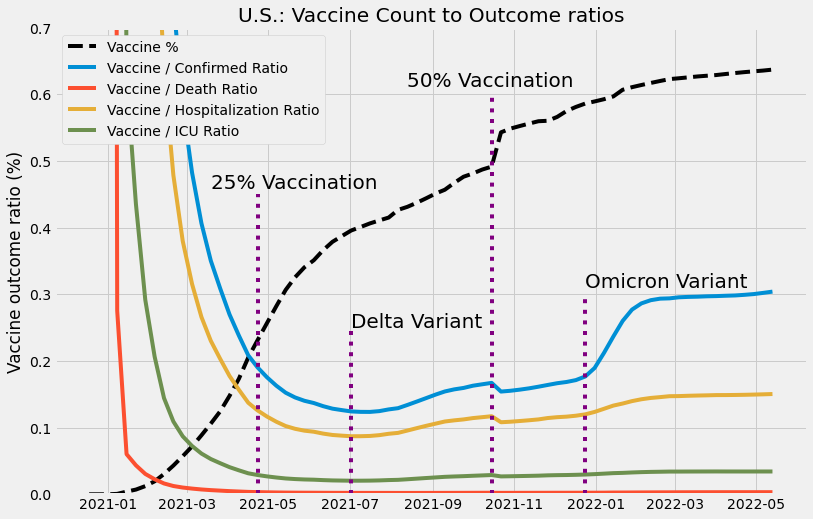

In [24]:

x_col='Date'
df = cd.get('us_cdvh_df')
display(df.columns)
#x_col='vax_pct'
x = df[x_col]

top_title = "U.S."
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))

plt.plot(x,df['vax_pct'],color='black',label='Vaccine %',linestyle='dashed')

for cn in [('Confirmed','vcr'), ('Death','vdr'), ('Hospitalization','vbr'),  ('ICU','vir')]:
    col = cn[0]
    name = cn[1]

    plt.plot(x,df[name],label=f"Vaccine / {col} Ratio")

plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=.25, color='purple', linestyle="dotted")
plt.vlines(x = df[df['Date'] == '2021-12-24']['Date'], ymin=0, ymax=.3, color='purple', linestyle="dotted")
font = {

    'size' : 20
}
plt.text(df[df['Date'] == '2021-07-02']['Date'],.25,"Delta Variant", fontdict=font)
plt.text(df[df['Date'] == '2021-12-24']['Date'],.31,"Omicron Variant", fontdict=font)

v_date = pd.to_datetime('2021-04-23')
v_text = "25% Vaccination"
v_height = .45
v_offset = 5
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-10-15')
v_text = "50% Vaccination"
v_height = .6
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)


ax = plt.gca()
ax.set_ylim(0,.7)
plt.legend(loc='upper left', framealpha=1)
plt.title(f"{top_title}: Vaccine Count to Outcome ratios")
plt.ylabel("Vaccine outcome ratio (%)")
plt.show()

"""
plt.figure(figsize=(12, 8))

plt.plot(x,df['uvx_pct'],color='black',label='Un Vaxed %',linestyle='dashed')

for cn in [('Confirmed','uvcr'), ('Death','uvdr'), ('Hospitalization','uvbr'),  ('ICU','uvir')]:
    col = cn[0]
    name = cn[1]

    plt.plot(x,df[name],label=f"UnVaxed / {col} Ratio")

plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=0, ymax=.3, color='purple', linestyle="dotted")
plt.vlines(x = df[df['Date'] == '2021-12-24']['Date'], ymin=0, ymax=.65, color='purple', linestyle="dotted")
font = {

    'size' : 20
}
plt.text(df[df['Date'] == '2021-07-02']['Date'],.31,"Delta Variant", fontdict=font)
plt.text(df[df['Date'] == '2021-12-24']['Date'],.65," Omicron Variant", fontdict=font)
ax = plt.gca()
ax.set_ylim(0,.7)
plt.legend(loc='upper left', framealpha=1)
plt.title(f"{top_title}: Un-Vaccinated Count to Outcome ratios")
plt.ylabel("Un-vaccinated outcome ratio (%)")
plt.show()
"""
print()

In [25]:
cd.l()

Collected Dataframe Count:  12
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]
[state_cdh_df] Desc: State Weekly Cases Deaths Hospitals
[state_cvdh_df] Desc: State Weekly Cases Deaths Vaccines Hospitals
[us_cd_df] Desc: United States/Daily Confirmed Death 
[us_cdh_df] Desc: United States/Weekly Confirmed Death Hospitalization 2020-07-31 - 2022-04-08
[us_cdvh_df] Desc: United States/Weekly Confirmed Death Vaccine Hospitalization


-  [Build us_cd_df](#build-us_cd_df).

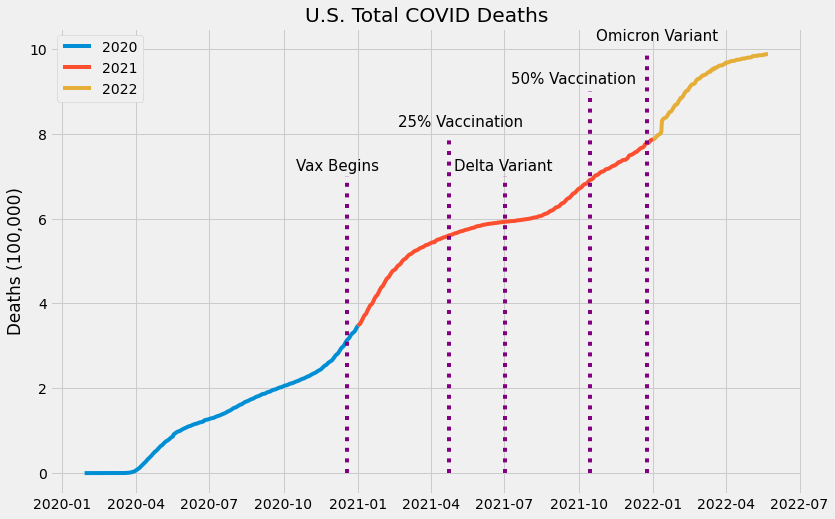

In [26]:
df = cd.get("us_cd_df").copy()
#df['tot_deaths_100k'] = df['tot_deaths'] / (df['pop'] / 100000)
#df['tot_confirm_100k'] = df['tot_confirm'] / (df['pop'] / 100000)
df['tot_deaths'] = (df['tot_deaths'] / 100000)


#//*** Smooth ou the death spike
df['New_Deaths'] = df['New_Deaths'].replace(df['New_Deaths'].max(),df['New_Deaths'].mean())

#//*** Convert New_deaths to Rolling 7 day mean
df['New_Deaths'] = df['New_Deaths'].rolling(7).mean()
#//*** Convert New_deaths to Rolling 7 day mean
df['New_Confirm'] = df['New_Confirm'].rolling(7).mean()


df_2020 = df[df['Date'] <= '2021'].copy()


df_2021 = df[(df['Date'] >= '2021') & (df['Date'] <= '2022')].copy()
df_2022 = df[(df['Date'] >= '2022')].copy()

display()
#df_2020['Date'] = df_2020['Date'].dt.strftime('%B')
#df_2021['Date'] = df_2021['Date'].dt.strftime('%B')
#df_2022['Date'] = df_2022['Date'].dt.strftime('%B')
#process_covid.qplot(df_2020['Date'],df_2020['tot_deaths'])

last = {
    "death_2021" : df_2020.iloc[-1]['tot_deaths'],
    "death_2022" : df_2021.iloc[-1]['tot_deaths'],
}






plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))

plt.plot(df_2020['Date'],df_2020['tot_deaths'],label=f"2020")
plt.plot(df_2021['Date'],df_2021['tot_deaths'],label="2021")
plt.plot(df_2022['Date'],df_2022['tot_deaths'],label="2022")

font = {

    'size' : 15
}
#//*** Begin Vax: '2020-12-18'
#//*** 25% Vaccination '2021-04-23'
#//*** 50% Vaccination '2021-10-15'

v_date = pd.to_datetime('2020-12-18')
v_text = "Vax Begins"
v_height = 7
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-04-23')
v_text = "25% Vaccination"
v_height = 8
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-10-15')
v_text = "50% Vaccination"
v_height = 9
v_offset = 14
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-07-02')
v_text = "Delta Variant"
v_height = 7
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-12-24')
v_text = "Omicron Variant"
v_height = 10
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)


plt.legend(loc='upper left', framealpha=1)
plt.title(f"U.S. Total COVID Deaths")
plt.ylabel("Deaths (100,000)")
plt.show()


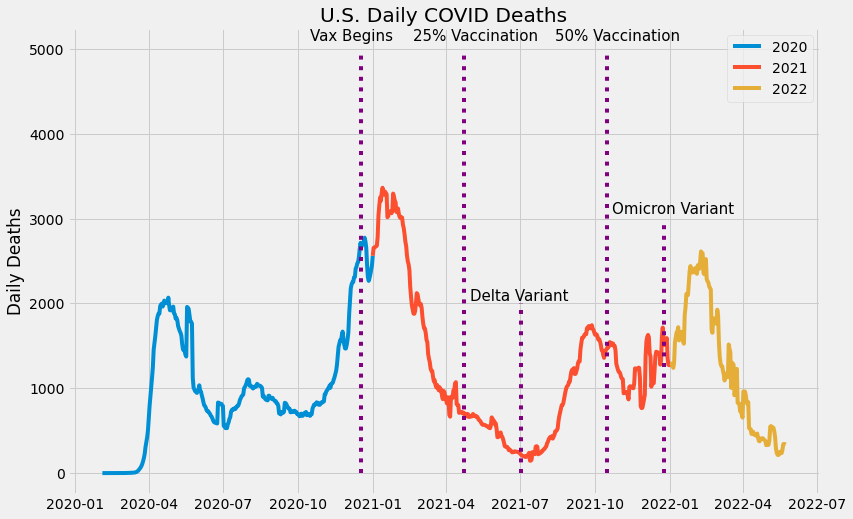

In [27]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))

plt.plot(df_2020['Date'],df_2020['New_Deaths'],label=f"2020")
plt.plot(df_2021['Date'],df_2021['New_Deaths'],label="2021")
plt.plot(df_2022['Date'],df_2022['New_Deaths'],label="2022")

v_date = pd.to_datetime('2020-12-18')
v_text = "Vax Begins"
v_height = 5000
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-04-23')
v_text = "25% Vaccination"
v_height = 5000
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-10-15')
v_text = "50% Vaccination"
v_height = 5000
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-07-02')
v_text = "Delta Variant"
v_height = 2000
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-12-24')
v_text = "Omicron Variant"
v_height = 3000
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

plt.title("U.S. Daily COVID Deaths")
plt.ylabel("Daily Deaths")
plt.legend()
plt.show()

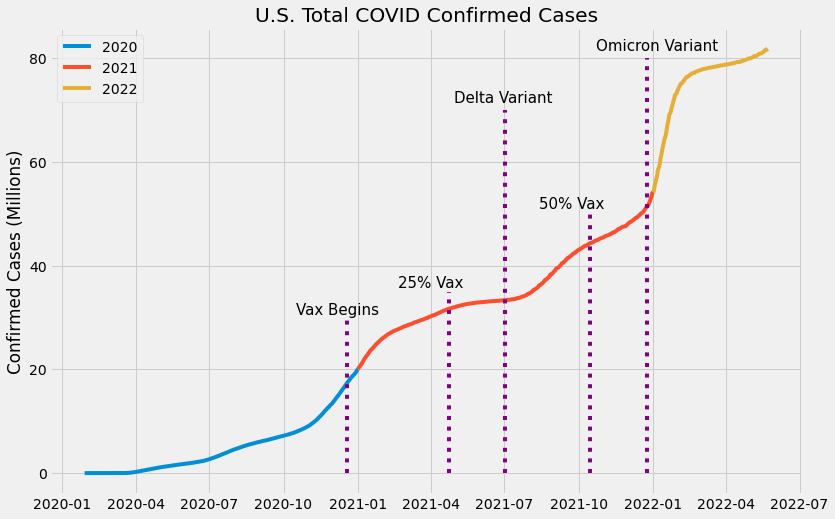

In [28]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))

plt.plot(df_2020['Date'],df_2020['tot_confirm'] / 1000000,label=f"2020")
plt.plot(df_2021['Date'],df_2021['tot_confirm'] / 1000000,label="2021")
plt.plot(df_2022['Date'],df_2022['tot_confirm'] / 1000000,label="2022")
v_date = pd.to_datetime('2020-12-18')
v_text = "Vax Begins"
v_height = 30
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-04-23')
v_text = "25% Vax"
v_height = 35
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-10-15')
v_text = "50% Vax"
v_height = 50
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-07-02')
v_text = "Delta Variant"
v_height = 70
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-12-24')
v_text = "Omicron Variant"
v_height = 80
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)


plt.title(f"U.S. Total COVID Confirmed Cases")
plt.ylabel("Confirmed Cases (Millions)")
plt.legend()
plt.show()

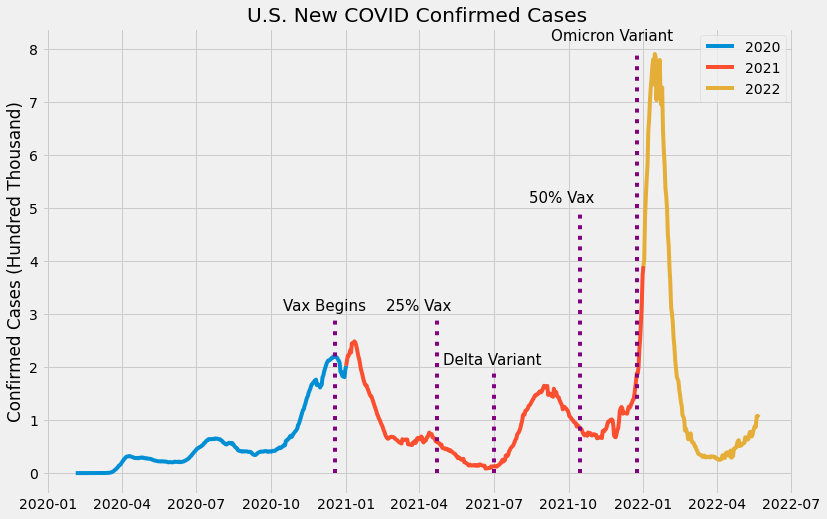

In [29]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))

plt.plot(df_2020['Date'],df_2020['New_Confirm'] / 100000, label=f"2020")
plt.plot(df_2021['Date'],df_2021['New_Confirm'] / 100000, label="2021")
plt.plot(df_2022['Date'],df_2022['New_Confirm'] / 100000, label="2022")

v_date = pd.to_datetime('2020-12-18')
v_text = "Vax Begins"
v_height = 3
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-04-23')
v_text = "25% Vax"
v_height = 3
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-10-15')
v_text = "50% Vax"
v_height = 5
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-07-02')
v_text = "Delta Variant"
v_height = 2
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-12-24')
v_text = "Omicron Variant"
v_height = 8
v_offset = 15
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)


plt.title(f"U.S. New COVID Confirmed Cases")
plt.ylabel("Confirmed Cases (Hundred Thousand)")
plt.legend()
plt.show()

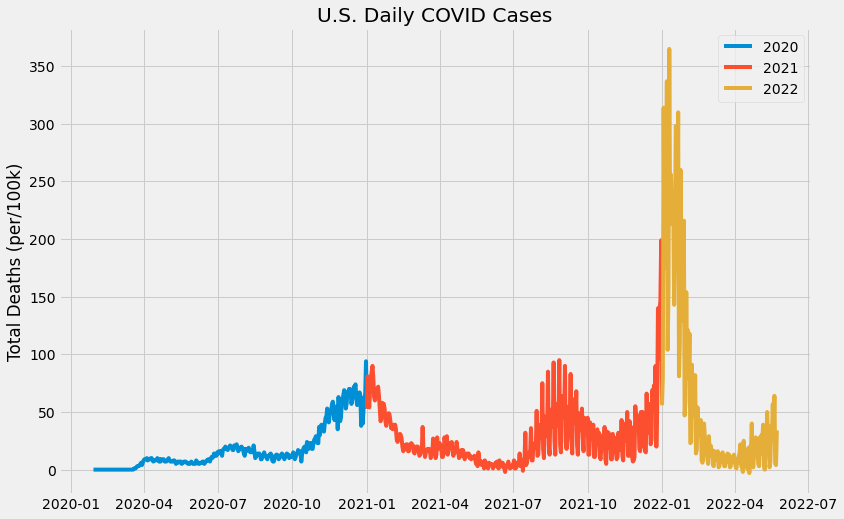

In [30]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))

plt.plot(df_2020['Date'],df_2020['New_Confirm_100k'],label=f"2020")
plt.plot(df_2021['Date'],df_2021['New_Confirm_100k'],label="2021")
plt.plot(df_2022['Date'],df_2022['New_Confirm_100k'],label="2022")

#plt.plot(df_2020['Date'],df_2020['New_Deaths_100k'],label=f"2020")
#plt.plot(df_2021['Date'],df_2021['New_Deaths_100k'],label="2021")
#plt.plot(df_2022['Date'],df_2022['New_Deaths_100k'],label="2022")

"""
v_date = pd.to_datetime('2020-12-18')
v_text = "Vax Begins"
v_height = 5000
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-04-23')
v_text = "25% Vaccination"
v_height = 5000
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-10-15')
v_text = "50% Vaccination"
v_height = 5000
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-07-02')
v_text = "Delta Variant"
v_height = 2000
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)

v_date = pd.to_datetime('2021-12-24')
v_text = "Omicron Variant"
v_height = 3000
v_offset = 9
plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)
"""
plt.title("U.S. Daily COVID Cases")
plt.ylabel("Total Deaths (per/100k)")
plt.legend()
plt.show()

us_total_death_100k = df['tot_deaths_100k'].max()

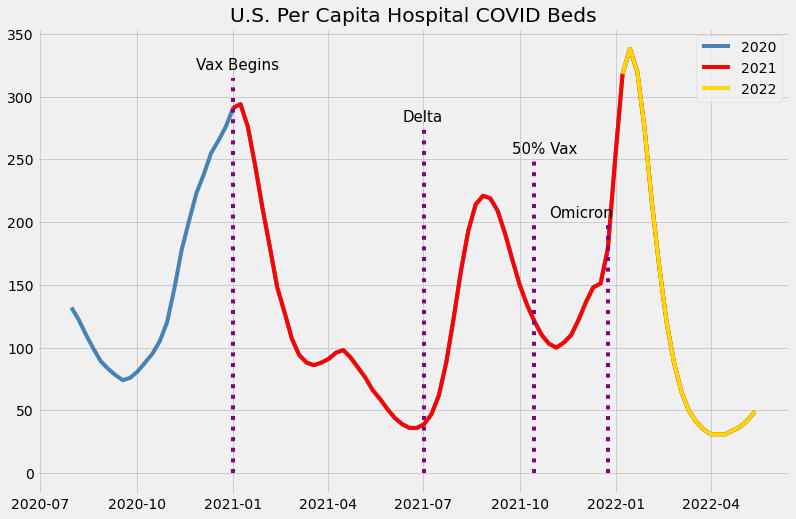

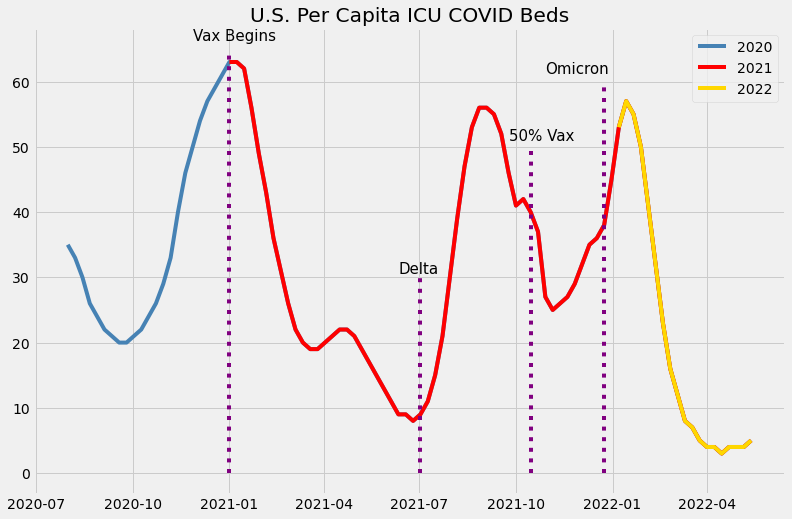

In [31]:
reload(process_covid)
vlines=[
    {'date':'2021-10-15','text':"50% Vax",'height':250,'offset':3,},
    {'date':'2021-01-01','text':"Vax Begins",'height':315,'offset':5,},
    {'date':'2021-07-02','text':"Delta",'height':275,'offset':3,},
    {'date':'2021-12-24','text':"Omicron",'height':200,'offset':8,},    
]


df = cd.get("us_cdh_df").copy()

df['beds_covid_100k'] = (df['beds_covid'] / (df['pop'] / 100000)).astype(int)
df['icu_covid_100k'] = (df['icu_covid'] / (df['pop'] / 100000)).astype(int)
plt=process_covid.plot(df,action="plot_by_year",col="beds_covid_100k",vlines=vlines,)
plt.title("U.S. Per Capita Hospital COVID Beds")
plt.show()

vlines=[
    {'date':'2021-01-01','text':"Vax Begins",'height':65,'offset':5,},
    {'date':'2021-07-02','text':"Delta",'height':30,'offset':3,},
    {'date':'2021-10-15','text':"50% Vax",'height':50,'offset':3,},
    {'date':'2021-12-24','text':"Omicron",'height':60,'offset':8,},    
]
plt=process_covid.plot(df,action="plot_by_year",col="icu_covid_100k",vlines=vlines,)
plt.title("U.S. Per Capita ICU COVID Beds")
plt.show()

#plt.vlines(x = df[df['Date'] == v_date]['Date'], ymin=0, ymax=v_height, color='purple', linestyle="dotted")
#plt.text(df[df['Date'] ==  v_date - pd.Timedelta(v_offset, unit='W')]['Date'],v_height*1.02,v_text, fontdict=font)



In [32]:
df = cd.get("us_cdh_df")
df[df['Date'].dt.year > 2020]

Date state        pop  tot_confirm  tot_deaths  New_Confirm  \
22 2021-01-01    US  316840810     19342054      335238    1368519.0   
23 2021-01-08    US  316804546     20993752      355696    1651698.0   
24 2021-01-15    US  316804546     22532689      377714    1538937.0   
25 2021-01-22    US  316804546     23737845      398429    1205156.0   
26 2021-01-29    US  316804546     24769408      419939    1031563.0   
27 2021-02-05    US  316782422     25611017      440162     841609.0   
28 2021-02-12    US  316782422     26265811      457441     654794.0   
29 2021-02-19    US  316782422     26733148      470431     467337.0   
30 2021-02-26    US  316782422     27196365      484090     463217.0   
31 2021-03-05    US  316782422     27611277      495351     414912.0   
32 2021-03-12    US  316782422     28032292      504008     421015.0   
33 2021-03-19    US  316782422     28398825      510927     366533.0   
34 2021-03-26    US  316782422     28808701      517585     409876.0   
35 2021-04-02    US  316782422     29249462      523118     440761.0   
36 2021-04-09    US  316782422     29704677      529693     455215.0   
37 2021-04-16    US  316782422     30176749      534506     472072.0   
38 2021-04-23    US  316782422     30572402      539187     395653.0   
39 2021-04-30    US  316782422     30911041      543818     338639.0   
40 2021-05-07    US  316710535     31192472      547937     281431.0   
41 2021-05-14    US  316710535     31426545      551850     234073.0   
42 2021-05-21    US  316710535     31607225      555531     180680.0   
43 2021-05-28    US  316710535     31755810      559969     148585.0   
44 2021-06-04    US  316710535     31851850      562799      96040.0   
45 2021-06-11    US  316782422     31965074      565638     113224.0   
46 2021-06-18    US  316782422     32042823      567406      77749.0   
47 2021-06-25    US  316782422     32123860      569223      81037.0   
48 2021-07-02    US  316775963     32211301      570651      87441.0   
49 2021-07-09    US  316775963     32332994      571996     121693.0   
50 2021-07-16    US  316746938     32535288      573500     202294.0   
51 2021-07-23    US  316769062     32864046      575053     328758.0   
52 2021-07-30    US  316798087     33373790      577045     509744.0   
53 2021-08-06    US  316798087     34087670      579688     713880.0   
54 2021-08-13    US  316798087     34936888      582902     849218.0   
55 2021-08-20    US  316798087     35899692      587913     962804.0   
56 2021-08-27    US  316798087     36925406      594608    1025714.0   
57 2021-09-03    US  316821510     37996661      602685    1071255.0   
58 2021-09-10    US  316821510     38963498      611223     966837.0   
59 2021-09-17    US  316821510     39929781      621729     966283.0   
60 2021-09-24    US  316821510     40723716      632991     793935.0   
61 2021-10-01    US  316794716     41480416      643533     756700.0   
62 2021-10-08    US  316794716     42119479      653401     639063.0   
63 2021-10-15    US  316794716     42674547      662833     555068.0   
64 2021-10-22    US  316768791     43159867      672726     485320.0   
65 2021-10-29    US  316794716     43639759      680813     479892.0   
66 2021-11-05    US  316794716     44124780      687982     485021.0   
67 2021-11-12    US  316823037     44660570      694766     535790.0   
68 2021-11-19    US  316823037     45271959      701823     611389.0   
69 2021-11-26    US  316823037     45775687      707155     503728.0   
70 2021-12-03    US  316823037     46535676      716873     759989.0   
71 2021-12-10    US  316823037     47338274      725035     802598.0   
72 2021-12-17    US  316823037     48182291      733401     844017.0   
73 2021-12-24    US  316823037     49470334      743714    1288043.0   
74 2021-12-31    US  316823037     52021034      752101    2550700.0   
75 2022-01-07    US  316823037     56469169      762673    4448135.0   
76 2022-01-14    US  316823037     61406265      

# Distribution Graph #

-  [Build state_cvdh_df](#build-state_cvdh_df).

In [33]:

us_total_death_100k =  (cd.get('us_cd_df')['tot_deaths'] / (cd.get('us_cd_df')['pop'] / 100000)).max()
us_total_confirm_100k =  (cd.get('us_cd_df')['tot_confirm'] / (cd.get('us_cd_df')['pop'] / 100000)).max()
reload(process_covid)
df = cd.get('state_cvdh_df')
#//*** Rename States from Abbreviation to Full Name
df['state'] = process_covid.rename_state_abbreviations(df['state'])



In [34]:
cd.l()
us_total_confirm_mean = cd.get('us_cdvh_df')['tot_confirm_100k'].iloc[-1]
display(cd.get('us_cdvh_df'))


Collected Dataframe Count:  12
[county_geo_df] Desc: Geopandas DataFrame: Counties
[state_geo_df] Desc: Geopandas DataFrame: States
[week_cdvh_df] Desc: County/Weekly Confirmed, Death,Vaccine, Hospitalization
[county_daily_df] Desc: County/Daily Cases and Deaths
[hosp_df] Desc: County/Weekly Hospitalization Data
[week_cdh_df] Desc: County/Weekly Cases Deaths Hospitalizations: 2020-07-31 - 2022-04-08
[state_cd_df] Desc: State/Daily Cases Deaths - Entire Pandemic - [ 2020-01-29 - 2022-04-24]
[state_cdh_df] Desc: State Weekly Cases Deaths Hospitals
[state_cvdh_df] Desc: State Weekly Cases Deaths Vaccines Hospitals
[us_cd_df] Desc: United States/Daily Confirmed Death 
[us_cdh_df] Desc: United States/Weekly Confirmed Death Hospitalization 2020-07-31 - 2022-04-08
[us_cdvh_df] Desc: United States/Weekly Confirmed Death Vaccine Hospitalization


Date state          pop       vax_ct  tot_confirm  tot_deaths  \
0  2020-12-18    US  314857069.0          0.0   16627749.0    301060.0   
1  2020-12-25    US  314872985.0        464.0   17917546.0    317557.0   
2  2021-01-01    US  314872985.0       4355.0   19283882.0    334789.0   
3  2021-01-08    US  314836721.0     196733.0   20932646.0    355223.0   
4  2021-01-15    US  314836721.0    1264054.0   22469101.0    377221.0   
5  2021-01-22    US  314836721.0    2227662.0   23672574.0    397901.0   
6  2021-01-29    US  314836721.0    3867740.0   24702636.0    419330.0   
7  2021-02-05    US  314814597.0    6131952.0   25542913.0    439530.0   
8  2021-02-12    US  314814597.0    9577160.0   26196503.0    456797.0   
9  2021-02-19    US  314814597.0   13566366.0   26662770.0    469778.0   
10 2021-02-26    US  314814597.0   17986083.0   27124964.0    483429.0   
11 2021-03-05    US  314814597.0   22619656.0   27538763.0    494672.0   
12 2021-03-12    US  314814597.0   27872045.0   27958542.0    503322.0   
13 2021-03-19    US  314814597.0   33375332.0   28323850.0    510235.0   
14 2021-03-26    US  314814597.0   39184464.0   28732172.0    516883.0   
15 2021-04-02    US  314814597.0   46493752.0   29171061.0    522412.0   
16 2021-04-09    US  314814597.0   54582747.0   29624496.0    528980.0   
17 2021-04-16    US  314814597.0   64593214.0   30094999.0    533773.0   
18 2021-04-23    US  314814597.0   72834453.0   30489103.0    538451.0   
19 2021-04-30    US  314814597.0   80872679.0   30826134.0    543066.0   
20 2021-05-07    US  314742710.0   88855596.0   31106367.0    547180.0   
21 2021-05-14    US  314742710.0   96534403.0   31339347.0    551085.0   
22 2021-05-21    US  314742710.0  102474356.0   31519153.0    554748.0   
23 2021-05-28    US  314742710.0  107189455.0   31667196.0    559182.0   
24 2021-06-04    US  314742710.0  110515831.0   31762685.0    562009.0   
25 2021-06-11    US  314814597.0  115310253.0   31875416.0    564840.0   
26 2021-06-18    US  314814597.0  119268283.0   31952699.0    566604.0   
27 2021-06-25    US  314814597.0  121956669.0   32033336.0    568416.0   
28 2021-07-02    US  314808138.0  124608531.0   32120228.0    569838.0   
29 2021-07-09    US  314808138.0  126239692.0   32241343.0    571181.0   
30 2021-07-16    US  314779113.0  127943149.0   32442580.0    572679.0   
31 2021-07-23    US  314801237.0  129350432.0   32769442.0    574227.0   
32 2021-07-30    US  314830262.0  130717622.0   33276453.0    576205.0   
33 2021-08-06    US  314830262.0  134336237.0   33985760.0    578836.0   
34 2021-08-13    US  314830262.0  135787493.0   34829145.0    582039.0   
35 2021-08-20    US  314830262.0  137706818.0   35785025.0    587026.0   
36 2021-08-27    US  314830262.0  139818741.0   36803132.0    593686.0   
37 2021-09-03    US  314853685.0  142040548.0   37865476.0    601725.0   
38 2021-09-10    US  314853685.0  143872555.0   38824650.0    610229.0   
39 2021-09-17    US  314853685.0  147088576.0   39782740.0    620671.0   
40 2021-09-24    US  314853685.0  150019000.0   40568338.0    631834.0   
41 2021-10-01    US  314826891.0  151539881.0   41316772.0    642296.0   
42 2021-10-08    US  314826891.0  153400945.0   41950252.0    652113.0   
43 2021-10-15    US  314826891.0  154773220.0   42499486.0    661497.0   
44 2021-10-22    US  314800966.0  170962249.0   42979889.0    671306.0   
45 2021-10-29    US  314826891.0  172722960.0   43455596.0    679360.0   
46 2021-11-05    US  314826891.0  173942680.0   43936949.0    686470.0   
47 2021-11-12    US  314855212.0  175123802.0   44469826.0    693147.0   
48 2021-11-19    US  314855212.0  176236173.0   45078566.0    700156.0   
49 2021-11-26    US  314855212.0  176449972.0   45580260.0    705461.0   
50 2021-12-03    US  314855212.0  178274526.0   46338183.0    715163.0   
51 2021-12-10    US  314855212.0  181056405.0   47139005.0    723306.0   
52 2021-12-17    US  314855212.0  182983653.0   47979943.0    731609.0   
53 2021-12-24

-  [Build week_cdvh_df](#build-week_cdvh_df).


In [35]:
t =  cd.get('week_cdvh_df').copy()
t[t['FIPS'] == 42005]

Date     FIPS Recip_State  vax_pct   vax_ct        cty  \
13   2020-12-18  42005.0          PA      0.0      0.0  Armstrong   
988  2020-12-25  42005.0          PA      0.0      0.0  Armstrong   
2028 2021-01-01  42005.0          PA      0.0      0.0  Armstrong   
407  2021-01-08  42005.0          PA      0.0      0.0  Armstrong   
1901 2021-01-15  42005.0          PA      0.3    196.0  Armstrong   
376  2021-01-22  42005.0          PA      0.6    380.0  Armstrong   
1209 2021-01-29  42005.0          PA      1.2    750.0  Armstrong   
619  2021-02-05  42005.0          PA      1.8   1160.0  Armstrong   
2214 2021-02-12  42005.0          PA      2.5   1612.0  Armstrong   
1686 2021-02-19  42005.0          PA      3.7   2374.0  Armstrong   
1009 2021-02-26  42005.0          PA      4.8   3136.0  Armstrong   
825  2021-03-05  42005.0          PA      6.9   4462.0  Armstrong   
2390 2021-03-12  42005.0          PA      8.1   5240.0  Armstrong   
1708 2021-03-19  42005.0          PA     12.4   8024.0  Armstrong   
616  2021-03-26  42005.0          PA     14.7   9509.0  Armstrong   
1191 2021-04-02  42005.0          PA     17.0  11015.0  Armstrong   
1737 2021-04-09  42005.0          PA     17.9  11579.0  Armstrong   
1287 2021-04-16  42005.0          PA     23.4  15156.0  Armstrong   
2167 2021-04-23  42005.0          PA     29.2  18934.0  Armstrong   
252  2021-04-30  42005.0          PA     31.8  20571.0  Armstrong   
1602 2021-05-07  42005.0          PA     34.9  22561.0  Armstrong   
695  2021-05-14  42005.0          PA     37.5  24253.0  Armstrong   
1763 2021-05-21  42005.0          PA     39.6  25607.0  Armstrong   
1653 2021-05-28  42005.0          PA     40.8  26394.0  Armstrong   
1822 2021-06-04  42005.0          PA     42.5  27535.0  Armstrong   
479  2021-06-11  42005.0          PA     43.8  28336.0  Armstrong   
136  2021-06-18  42005.0          PA     44.8  28982.0  Armstrong   
1861 2021-06-25  42005.0          PA     45.5  29478.0  Armstrong   
80   2021-07-02  42005.0          PA     46.0  29796.0  Armstrong   
1784 2021-07-09  42005.0          PA     46.4  30027.0  Armstrong   
595  2021-07-16  42005.0          PA     46.7  30248.0  Armstrong   
279  2021-07-23  42005.0          PA     47.1  30512.0  Armstrong   
219  2021-07-30  42005.0          PA     47.5  30750.0  Armstrong   
2017 2021-08-06  42005.0          PA     47.9  31009.0  Armstrong   
552  2021-08-13  42005.0          PA     48.2  31187.0  Armstrong   
2349 2021-08-20  42005.0          PA     48.6  31481.0  Armstrong   
2286 2021-08-27  42005.0          PA     49.1  31785.0  Armstrong   
1649 2021-09-03  42005.0          PA     49.6  32106.0  Armstrong   
316  2021-09-10  42005.0          PA     50.2  32477.0  Armstrong   
651  2021-09-17  42005.0          PA     50.8  32892.0  Armstrong   
989  2021-09-24  42005.0          PA     51.4  33261.0  Armstrong   
423  2021-10-01  42005.0          PA     51.8  33563.0  Armstrong   
1915 2021-10-08  42005.0          PA     52.3  33852.0  Armstrong   
801  2021-10-15  42005.0          PA     52.7  34122.0  Armstrong   
446  2021-10-22  42005.0          PA     53.0  34340.0  Armstrong   
1503 2021-10-29  42005.0          PA     53.5  34628.0  Armstrong   
2264 2021-11-05  42005.0          PA     54.0  34973.0  Armstrong   
549  2021-11-12  42005.0          PA     54.4  35240.0  Armstrong   
434  2021-11-19  42005.0          PA     55.0  35572.0  Armstrong   
429  2021-11-26  42005.0          PA     53.3  34500.0  Armstrong   
1450 2021-12-03  42005.0          PA     53.8  34820.0  Armstrong   
911  2021-12-10  42005.0          PA     54.5  35268.0  Armstrong   
375  2021-12-17  42005.0          PA     55.0  35614.0  Armstrong   
1913 2021-12-24  42005.0          PA     56.5  36604.0  Armstrong   
1019 2021-12-31  42005.0          PA     56.7  36737.0  Armstrong   
599  2022-01-07  42005.0          PA     57.2  37013.0  Armstrong   
1279 2022-01-14  42005.0          PA     57.7  37346.0  Armstrong   
1430 2022

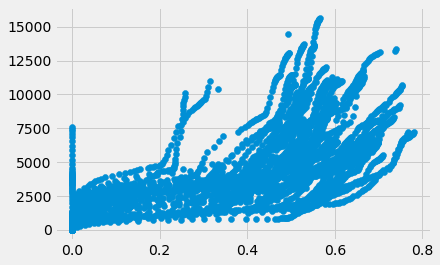

73    15669
72    15602
71    15548
70    15498
69    15456
      ...  
0         0
0         0
0         0
0         0
0         0
Name: pv_beds_covid_tot_100k, Length: 3626, dtype: int32

In [36]:
plt.figure()
plt.scatter(df['vax_pct'],df['pv_beds_covid_tot_100k'])
plt.show()

df['pv_beds_covid_tot_100k'].sort_values(ascending=False)

In [37]:
column = 'tot_confirm_100k'
center = process_covid.build_100k(cd.get('us_cdvh_df'),cols=['tot_confirm']).iloc[0]['tot_confirm_100k']
#center = cd.get('us_cdvh_df').iloc[0]['tot_confirm'] / (cd.get('us_cdvh_df').iloc[0]['pop'] / 100000)
center = cd.get('us_cdvh_df').iloc[0]['tot_confirm_100k']
center
#cd.get('us_cdvh_df')[column].iloc[0]
#cd.get('us_cdvh_df')



5281

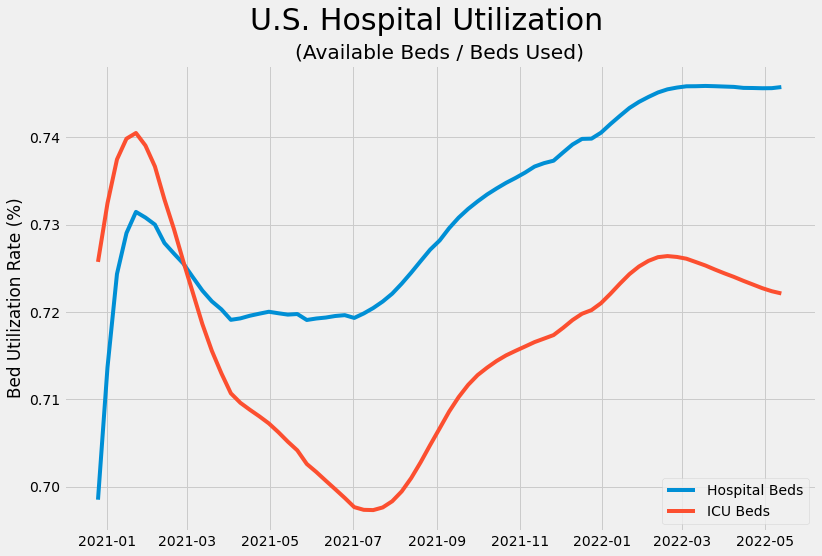

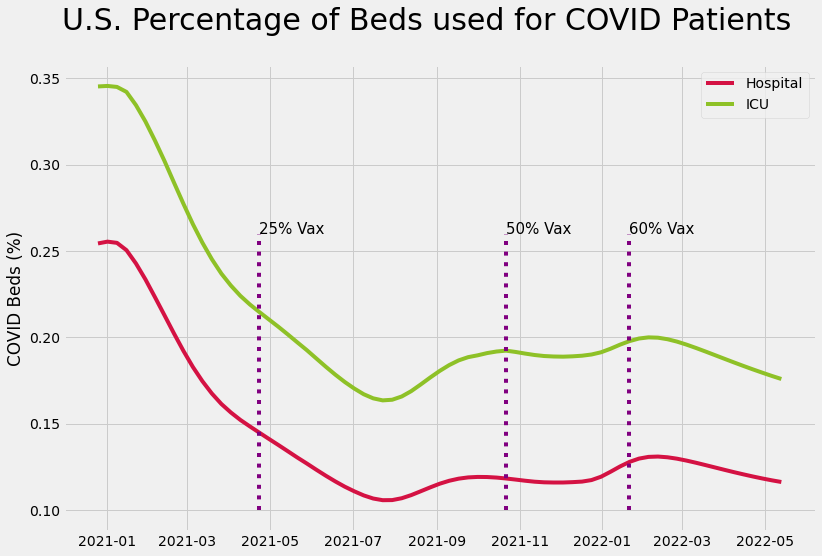

In [38]:

base_name = "us_hosp_util"
project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

#//*** Build folder if not exist
try:
    os.mkdir(project_dir)
except:
    pass

#//*** Delete and files in folder 
for file in os.listdir(project_dir):

    try:
        os.remove(project_dir.joinpath(file)) 
    except:
        pass



df = cd.get('us_cdvh_df').copy()

 #pv_beds_used_tot pv_beds_tot
fontsize=20
plt.figure(figsize=(12, 8))
plt.plot(df["Date"],df['all_bed_util'], label="Hospital Beds")
plt.plot(df["Date"],df['icu_util'],label="ICU Beds")
plt.suptitle(f"U.S. Hospital Utilization",fontsize=fontsize * 1.5)
plt.title("(Available Beds / Beds Used)")
plt.ylabel("Bed Utilization Rate (%)")
plt.legend(loc="lower right")
filename=f"{str(1).zfill(3)}_{base_name}.png"
plt.savefig(project_dir.joinpath(filename))

plt.show()

plt.figure(figsize=(12, 8))
plt.plot(df["Date"],df['covid_bed_util'],color=color_dict['h'],label="Hospital")
plt.plot(df["Date"],df['icu_covid_util'],color_dict['i'],label="ICU")
plt.suptitle(f"U.S. Percentage of Beds used for COVID Patients", fontsize= fontsize* 1.5)
plt.ylabel("COVID Beds (%)")

date = '2021-04-23'
ymax = .26
ymin = .1
text = "25% Vax"
plt.vlines(x = df[df['Date'] == date]['Date'], ymin=ymin, ymax=ymax, color='purple', linestyle="dotted")
plt.text(df[df['Date'] == date]['Date'],ymax,text, fontdict=font)

date = '2021-10-22'
ymax = .26
ymin = .1
text = "50% Vax"
plt.vlines(x = df[df['Date'] == date]['Date'], ymin=ymin, ymax=ymax, color='purple', linestyle="dotted")
plt.text(df[df['Date'] == date]['Date'],ymax,text, fontdict=font)


date = '2022-01-21'
ymax = .26
ymin = .1
text = "60% Vax"
plt.vlines(x = df[df['Date'] == date]['Date'], ymin=ymin, ymax=ymax, color='purple', linestyle="dotted")
plt.text(df[df['Date'] == date]['Date'],ymax,text, fontdict=font)



#plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=.1, ymax=.25, color='purple', linestyle="dotted")
#plt.text(df[df['Date'] == '2021-07-02']['Date'],.25,"Delta Variant", fontdict=font)


#plt.vlines(x = df[df['Date'] == '2021-12-24']['Date'], ymin=.1, ymax=.25, color='purple', linestyle="dotted")
#plt.text(df[df['Date'] == '2021-12-24']['Date'],.25,"Omicron Variant", fontdict=font)

plt.legend()
plt.show()
#display(df)

#

#  National Post Vaccine COVID Totals #

In [39]:
#Nation 
df = cd.get('us_cdvh_df').copy()
df = df.iloc[-1]
print(f"Total COVID Outcomes: {cd.get('us_cdvh_df')['Date'].min().date()} - {df['Date'].date()}")
print(f"Population: {df['pop'].astype(int):,}")
print(f"Vaccinated: {round(df['vax_pct']*100,2)}%")
print(f"Total Confirmed {df['tot_confirm'].astype(int):,}" )
print(f"Total Deaths: {df['tot_deaths'].astype(int):,}")
print(f"Total Hospital Bed/Days: {df['pv_beds_covid_tot'].astype(int):,}")
print(f"Total ICU Bed Days: {df['pv_icu_covid_tot'].astype(int):,}")
print(f"{df['pv_beds_used_tot']:,} {df['pv_beds_tot']:,}")
print()
print((cd.get('us_cdvh_df')["Date"].iloc[-1] - cd.get('us_cdvh_df')["Date"].iloc[0] ).days, "Days")

Total COVID Outcomes: 2020-12-18 - 2022-05-13
Population: 314,820,738
Vaccinated: 63.72%
Total Confirmed 77,622,229
Total Deaths: 939,342
Total Hospital Bed/Days: 30,177,161
Total ICU Bed Days: 6,867,622
259,531,469.0 348,002,701.0

511 Days


In [40]:


#display(df[['Date','state','pop','vax_ct','vax_pct','vax_day','uvx']])

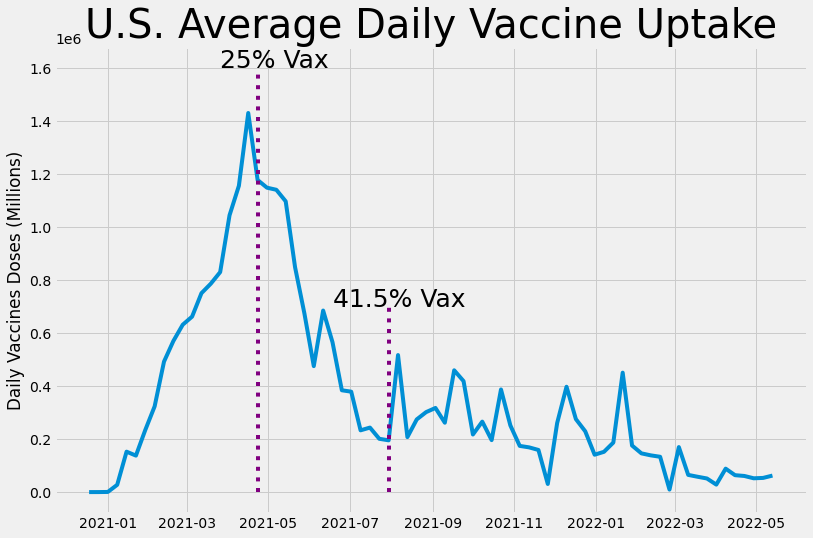

Index(['Date', 'state', 'pop', 'vax_ct', 'tot_confirm', 'tot_deaths',
       'beds_covid', 'icu_covid', 'beds_used', 'all_icu', 'vax_pct',
       'New_Confirm', 'New_Deaths', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_util', 'vcr', 'vdr', 'vbr',
       'vir'],
      dtype='object')

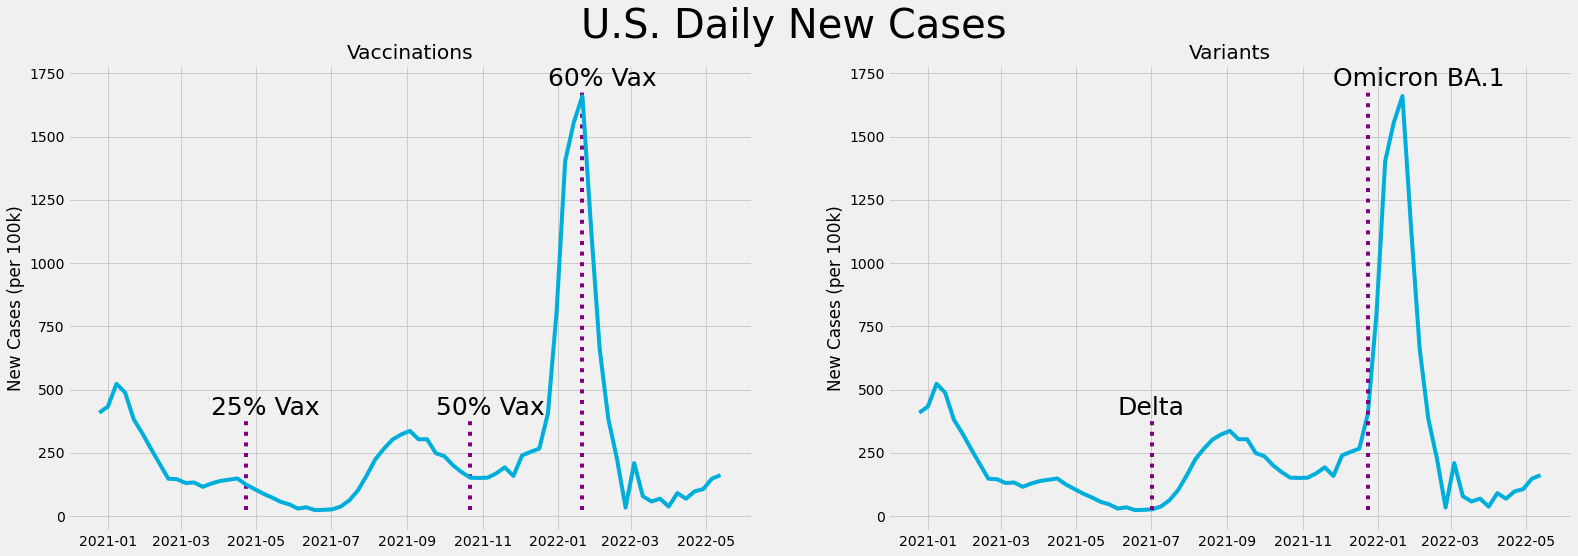

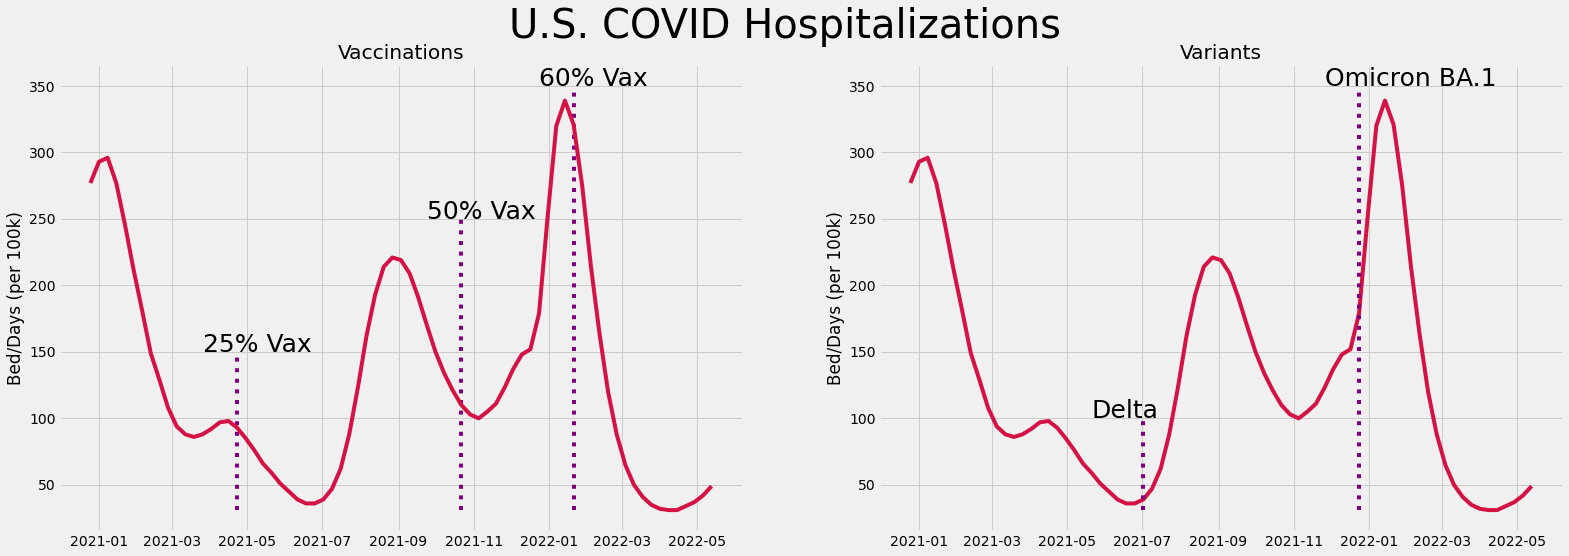

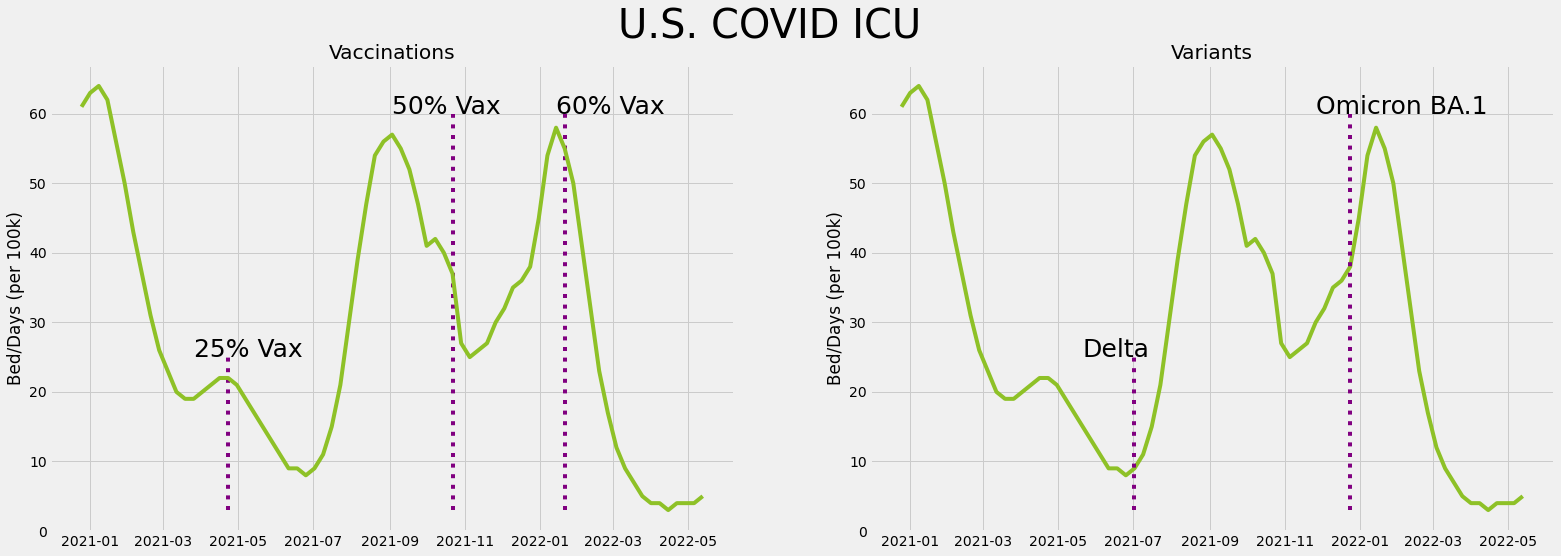

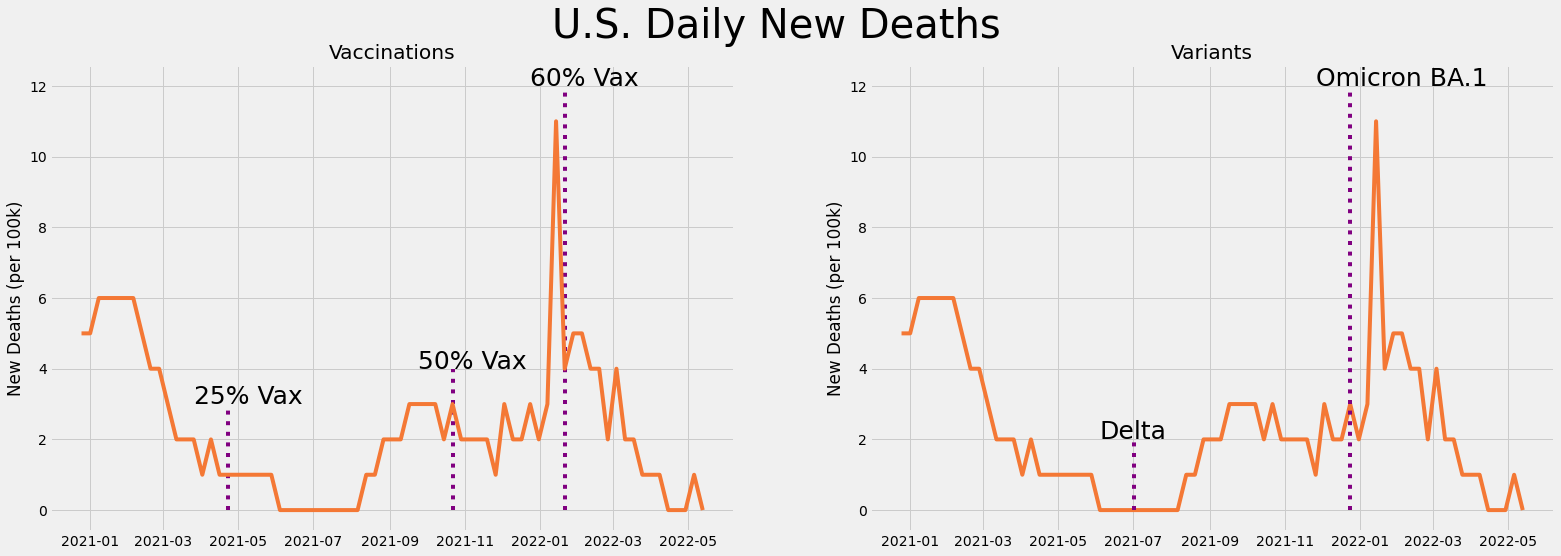

In [41]:
def plot_add_date_markers(df,**kwargs):
    col = None
    ymax = None
    date = None
    text = None
    offset = 0
    fontsize = 20
    
    for key,value in kwargs.items():
        
        if key == 'col':
            col = value
        
        if key == 'ymax':
            ymax = value
        
        if key == 'date':
            date = value
        
        if key == 'text':
            text = value

        if key == 'fontsize':
            fontsize = value
        
        if key =='offset':
            offset = value
        
    
    fontdict = { 'size' : fontsize }
    
    ymin = df[col].min()
    plt.vlines(x = df[df['Date'] == date]['Date'], ymin=ymin, ymax=ymax, color='purple', linestyle="dotted")
    plt.text(df[df['Date'] == date]['Date']- pd.Timedelta(offset, unit='W'),ymax,text, fontdict=fontdict)

    
#plt.vlines(x = df[df['Date'] == '2021-07-02']['Date'], ymin=.1, ymax=.25, color='purple', linestyle="dotted")
#plt.text(df[df['Date'] == '2021-07-02']['Date'],.25,"Delta Variant", fontdict=font)


#plt.vlines(x = df[df['Date'] == '2021-12-24']['Date'], ymin=.1, ymax=.25, color='purple', linestyle="dotted")
#plt.text(df[df['Date'] == '2021-12-24']['Date'],.25,"Omicron Variant", fontdict=font)
df = cd.get('us_cdvh_df').copy()

df['vax_day'] = (((df['vax_ct'].diff().fillna(0)) / 7) ).astype(int)
df['uvx'] = df['pop'] - df['vax_ct']

df['vax_day'] = df['vax_day'].replace(df['vax_day'].max(),df['vax_day'].mean())
#display(df[['Date','vax_day','vax_pct']])
plt.figure(figsize=(12, 8))
plt.plot(df['Date'],df['vax_day'])
plt.title(f"U.S. Average Daily Vaccine Uptake",fontsize=fontsize*2)
plt.ylabel('Daily Vaccines Doses (Millions)')
plot_add_date_markers(df,date='2021-04-23',ymax=1600000,offset=4,text="25% Vax",col="vax_day",fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2021-07-30',ymax=700000,offset=6,text="41.5% Vax",col="vax_day",fontsize=fontsize*1.25)
#plot_add_date_markers(df,date='2022-01-21',ymax=600000,offset=2,text="60% Vax",col=col,fontsize=fontsize*1.25)
plt.show()


df = cd.get('us_cdvh_df').copy()
df = df[df["Date"] > df["Date"].min()]
display(df.columns)

#//****************************************************************************
#//****************************************************************************
#//****************************************************************************
base_name = "us_confirm_split"
project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

#//*** Build folder if not exist
try:
    os.mkdir(project_dir)
except:
    pass

#//*** Delete and files in folder 
for file in os.listdir(project_dir):

    try:
        os.remove(project_dir.joinpath(file)) 
    except:
        pass


col = 'New_Confirm_100k'
ylabel_text = "New Cases (per 100k)"
plt.figure(figsize=(24, 8))
plt.suptitle("U.S. Daily New Cases",fontsize=fontsize*2)

plt.subplot(1, 2, 1)#//*** Left Boxx
plt.title("Vaccinations")
plot_add_date_markers(df,date='2021-04-23',ymax=400,offset=4,text="25% Vax",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2021-10-22',ymax=400,offset=4,text="50% Vax",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2022-01-21',ymax=1700,offset=4,text="60% Vax",col=col,fontsize=fontsize*1.25)

plt.ylabel(ylabel_text)
plt.plot(df["Date"],df[col],color=color_dict['c'])
plt.subplot(1, 2, 2)#//*** Right Box
plt.title("Variants")
plt.ylabel(ylabel_text)
plt.plot(df["Date"],df[col],color=color_dict['c'])
plot_add_date_markers(df,date='2021-07-02',ymax=400,offset=4,text="Delta",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2021-12-24',ymax=1700,offset=4,text="Omicron BA.1",col=col,fontsize=fontsize*1.25)
filename=f"{str(1).zfill(3)}_{base_name}.png"
plt.savefig(project_dir.joinpath(filename))
plt.show()    



#//****************************************************************************
#//****************************************************************************
#//****************************************************************************
base_name = "us_hosp_split"
project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

#//*** Build folder if not exist
try:
    os.mkdir(project_dir)
except:
    pass

#//*** Delete and files in folder 
for file in os.listdir(project_dir):

    try:
        os.remove(project_dir.joinpath(file)) 
    except:
        pass

col = 'beds_covid_100k'
ylabel_text = "Bed/Days (per 100k)"
plt.figure(figsize=(24, 8))
plt.suptitle("U.S. COVID Hospitalizations",fontsize=fontsize*2)

plt.subplot(1, 2, 1)#//*** Left Boxx
plt.title("Vaccinations")
plot_add_date_markers(df,date='2021-04-23',ymax=150,offset=4,text="25% Vax",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2021-10-22',ymax=250,offset=4,text="50% Vax",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2022-01-21',ymax=350,offset=4,text="60% Vax",col=col,fontsize=fontsize*1.25)

plt.ylabel(ylabel_text)
plt.plot(df["Date"],df[col],color=color_dict['h'])
plt.subplot(1, 2, 2)#//*** Right Box
plt.title("Variants")
plt.ylabel(ylabel_text)
plt.plot(df["Date"],df[col],color=color_dict['h'])
plot_add_date_markers(df,date='2021-07-02',ymax=100,offset=6,text="Delta",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2021-12-24',ymax=350,offset=4,text="Omicron BA.1",col=col,fontsize=fontsize*1.25)
filename=f"{str(1).zfill(3)}_{base_name}.png"
plt.savefig(project_dir.joinpath(filename))
plt.show() 
   

#//****************************************************************************
#//****************************************************************************
#//****************************************************************************
base_name = "us_icu_split"
project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

#//*** Build folder if not exist
try:
    os.mkdir(project_dir)
except:
    pass

#//*** Delete and files in folder 
for file in os.listdir(project_dir):

    try:
        os.remove(project_dir.joinpath(file)) 
    except:
        pass


col = 'icu_covid_100k'
ylabel_text = "Bed/Days (per 100k)"
plt.figure(figsize=(24, 8))
plt.suptitle("U.S. COVID ICU ",fontsize=fontsize*2)

plt.subplot(1, 2, 1)#//*** Left Boxx
plt.title("Vaccinations")
plot_add_date_markers(df,date='2021-04-23',ymax=25,offset=4,text="25% Vax",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2021-10-22',ymax=60,offset=7,text="50% Vax",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2022-01-21',ymax=60,offset=1,text="60% Vax",col=col,fontsize=fontsize*1.25)

plt.ylabel(ylabel_text)
plt.plot(df["Date"],df[col],color=color_dict['i'])
plt.subplot(1, 2, 2)#//*** Right Box
plt.title("Variants")
plt.ylabel(ylabel_text)
plt.plot(df["Date"],df[col],color=color_dict['i'])
plot_add_date_markers(df,date='2021-07-02',ymax=25,offset=6,text="Delta",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2021-12-24',ymax=60,offset=4,text="Omicron BA.1",col=col,fontsize=fontsize*1.25)
filename=f"{str(1).zfill(3)}_{base_name}.png"
plt.savefig(project_dir.joinpath(filename))
plt.show() 

#//****************************************************************************
#//****************************************************************************
#//****************************************************************************
base_name = "us_death_split"
project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

#//*** Build folder if not exist
try:
    os.mkdir(project_dir)
except:
    pass

#//*** Delete and files in folder 
for file in os.listdir(project_dir):

    try:
        os.remove(project_dir.joinpath(file)) 
    except:
        pass

    col = 'New_Deaths_100k'
ylabel_text = "New Deaths (per 100k)"
plt.figure(figsize=(24, 8))
plt.suptitle("U.S. Daily New Deaths",fontsize=fontsize*2)

plt.subplot(1, 2, 1)#//*** Left Boxx
plt.title("Vaccinations")
plot_add_date_markers(df,date='2021-04-23',ymax=3,offset=4,text="25% Vax",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2021-10-22',ymax=4,offset=4,text="50% Vax",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2022-01-21',ymax=12,offset=4,text="60% Vax",col=col,fontsize=fontsize*1.25)

plt.ylabel(ylabel_text)
plt.plot(df["Date"],df[col],color=color_dict['d'])
plt.subplot(1, 2, 2)#//*** Right Box
plt.title("Variants")
plt.ylabel(ylabel_text)
plt.plot(df["Date"],df[col],color=color_dict['d'])
plot_add_date_markers(df,date='2021-07-02',ymax=2,offset=4,text="Delta",col=col,fontsize=fontsize*1.25)
plot_add_date_markers(df,date='2021-12-24',ymax=12,offset=4,text="Omicron BA.1",col=col,fontsize=fontsize*1.25)
filename=f"{str(1).zfill(3)}_{base_name}.png"
plt.savefig(project_dir.joinpath(filename))
plt.show()    


# Matplotlib Color Maps #
https://matplotlib.org/stable/tutorials/colors/colormapnorms.html

In [42]:
cd.get('us_cdvh_df').columns

Index(['Date', 'state', 'pop', 'vax_ct', 'tot_confirm', 'tot_deaths',
       'beds_covid', 'icu_covid', 'beds_used', 'all_icu', 'vax_pct',
       'New_Confirm', 'New_Deaths', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_util', 'vcr', 'vdr', 'vbr',
       'vir'],
      dtype='object')

-  [Build state_cvdh_df](#build-state_cvdh_df).

Index(['Date', 'state', 'pop', 'vax_ct', 'tot_confirm', 'tot_deaths',
       'beds_covid', 'icu_covid', 'beds_used', 'all_icu', 'vax_pct',
       'New_Confirm', 'New_Deaths', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_util', 'vcr', 'vdr', 'vbr',
       'vir'],
      dtype='object')

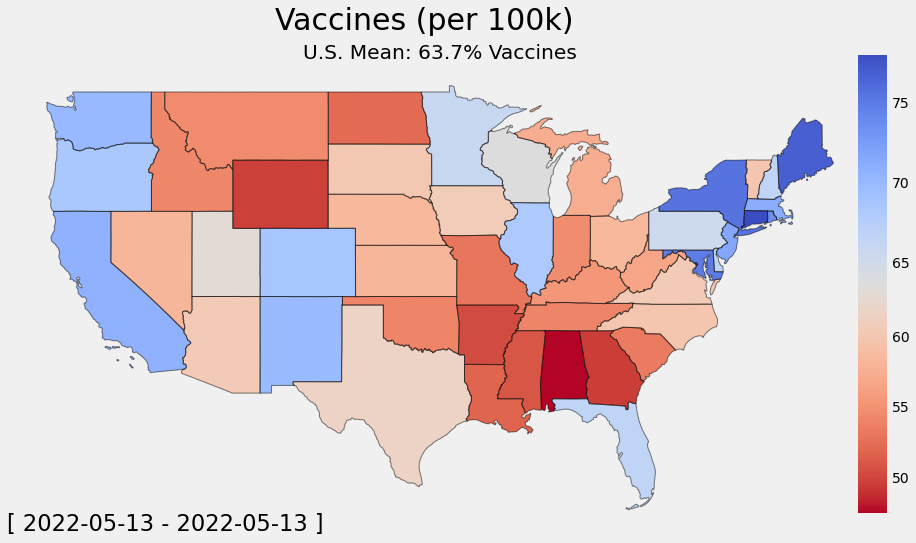

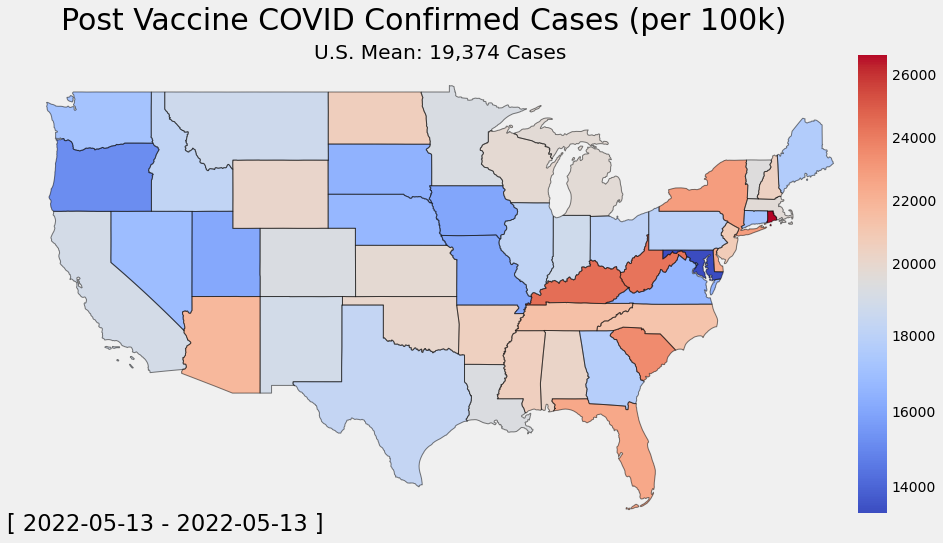

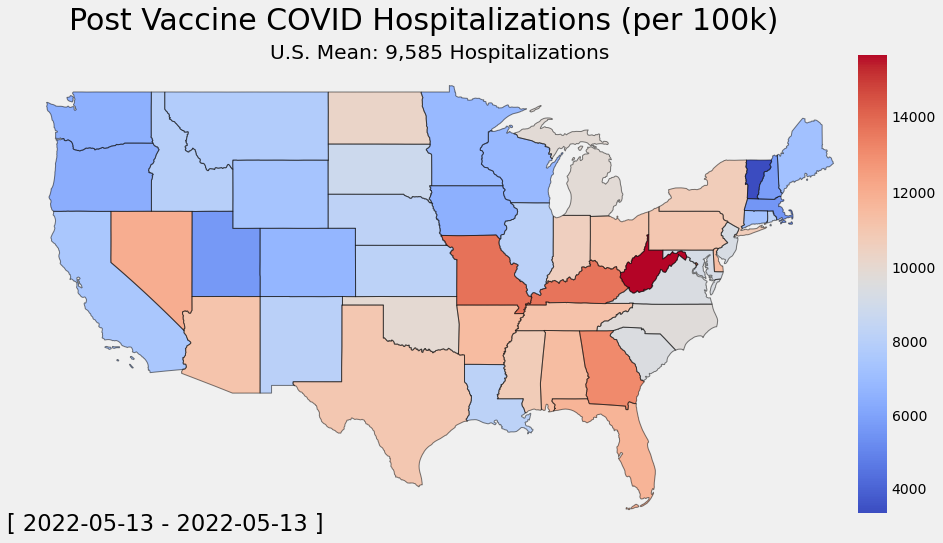

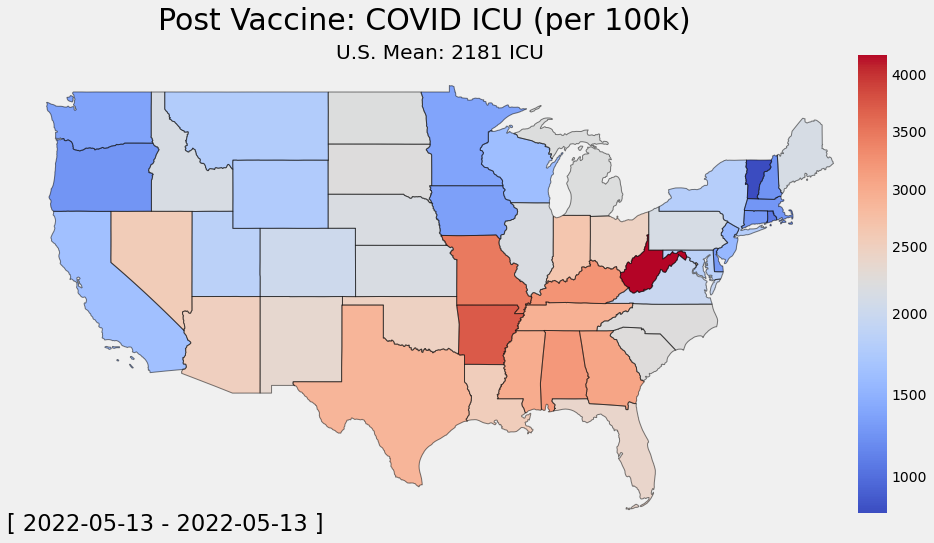

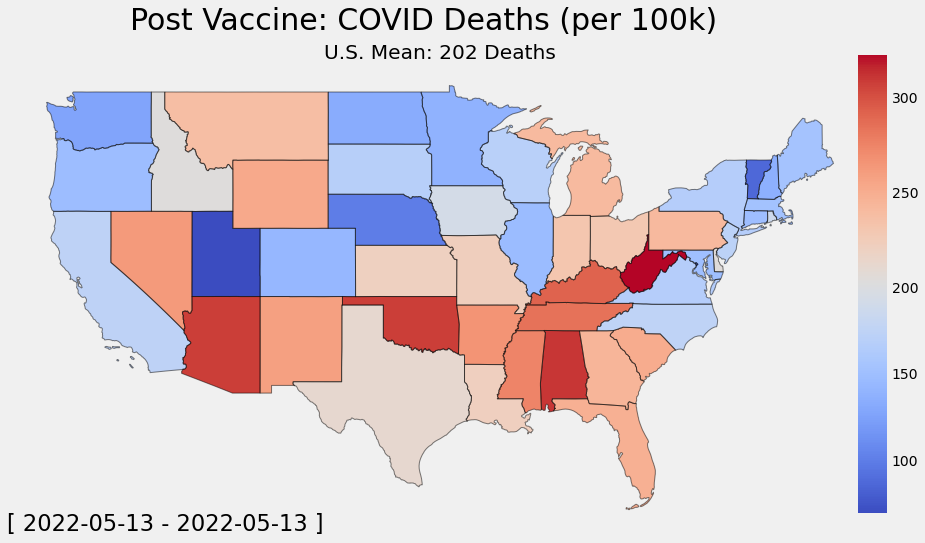

In [43]:
reload(process_covid)
from matplotlib import cm
from matplotlib import colors
display(cd.get('us_cdvh_df').columns)
#us_total_confirm_mean = cd.get('us_cdvh_df')['tot_confirm_100k'].iloc[-1]
#us_total_hosp_mean = cd.get('us_cdvh_df')['beds_covid_tot_100k'].iloc[-1]
#us_total_icu_mean = cd.get('us_cdvh_df')['icu_covid_tot_100k'].iloc[-1]
#us_total_death_mean = cd.get('us_cdvh_df')['tot_deaths_100k'].iloc[-1]
#us_total_vax_mean = cd.get('us_cdvh_df')['vax_ct_100k'].iloc[-1]

df = cd.get('state_cvdh_df').copy()

df=df[df['Date'] == df['Date'].max()]
df['vax_pct'] = df['vax_pct'] * 100

cmap = cm.coolwarm
geo_df = cd.get("state_geo_df").copy()

geo_df = geo_df.merge(df,left_on="NAME",right_on="state")

column ='vax_pct'
center =  round(cd.get('us_cdvh_df')[column].iloc[-1],3)*100
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Vaccines (per 100k)",
    title=f"U.S. Mean: {center:,}% Vaccines",
    cmap='coolwarm',
    figsize=(15,8),
    reverse=True,
    std=3.5,
    
    )



column ='pv_New_Confirm_tot_100k'
center =  cd.get('us_cdvh_df')[column].iloc[-1]
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccine COVID Confirmed Cases (per 100k)",
    title=f"U.S. Mean: {center:,} Cases",
    figsize=(15,8),
    std=3.5,
    )


column ='pv_beds_covid_tot_100k'
center =  cd.get('us_cdvh_df')[column].iloc[-1]
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccine COVID Hospitalizations (per 100k)",
    title=f"U.S. Mean: {center:,} Hospitalizations",
    figsize=(15,8),
    std=3.5,
    )


column ='pv_icu_covid_tot_100k'
center =  cd.get('us_cdvh_df')[column].iloc[-1]
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccine: COVID ICU (per 100k)",
    title=f"U.S. Mean: {center} ICU",
    figsize=(15,8),
    std=3.5,
    )

column ='pv_New_Deaths_tot_100k'
center =  cd.get('us_cdvh_df')[column].iloc[-1]
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccine: COVID Deaths (per 100k)",
    title=f"U.S. Mean: {center:,} Deaths",
    figsize=(15,8),
    std=3.5,
    )


Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_uti

count      2424.000000
mean       7208.889026
std        9174.203289
min           0.000000
25%        2924.250000
50%        5404.500000
75%        9461.250000
max      317767.000000
Name: pv_beds_covid_tot_100k, dtype: float64

<AxesSubplot:>

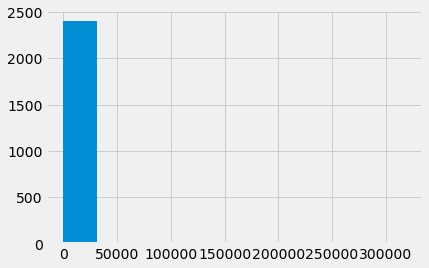

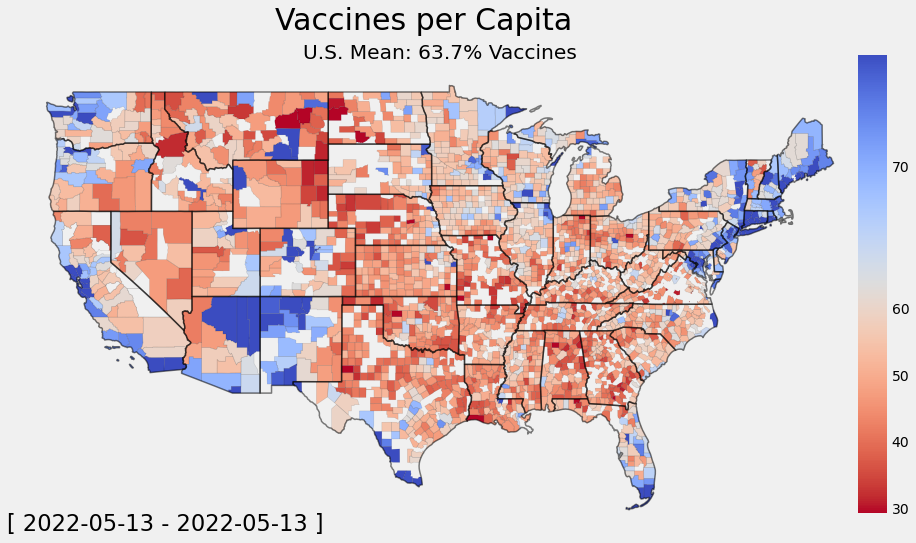

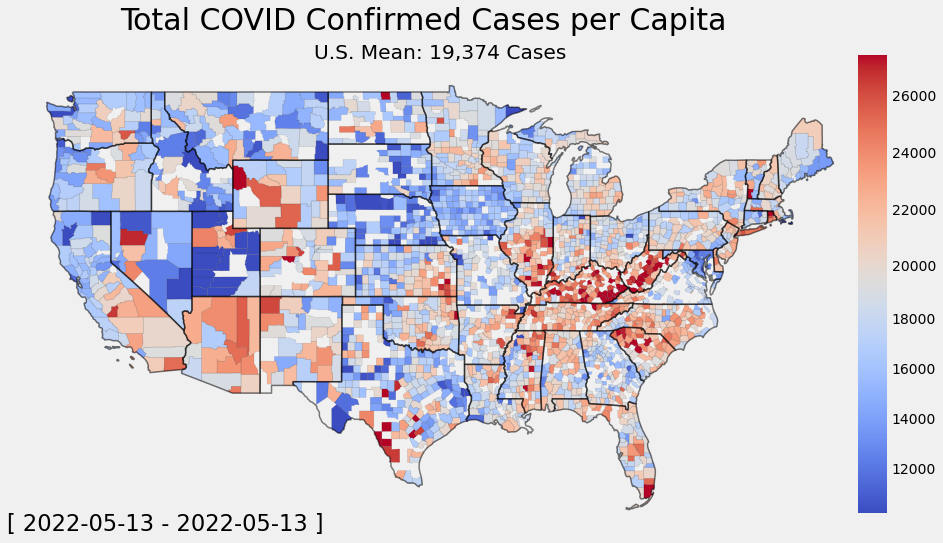

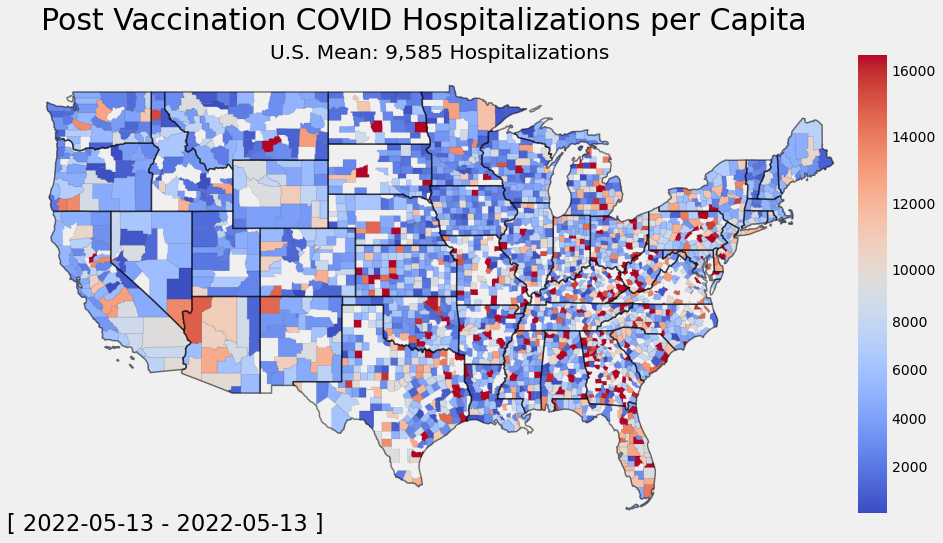

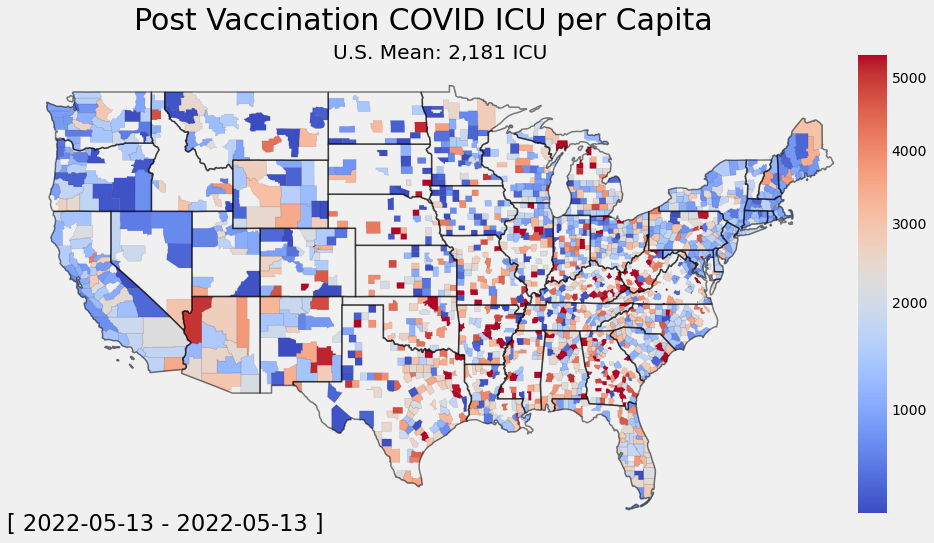

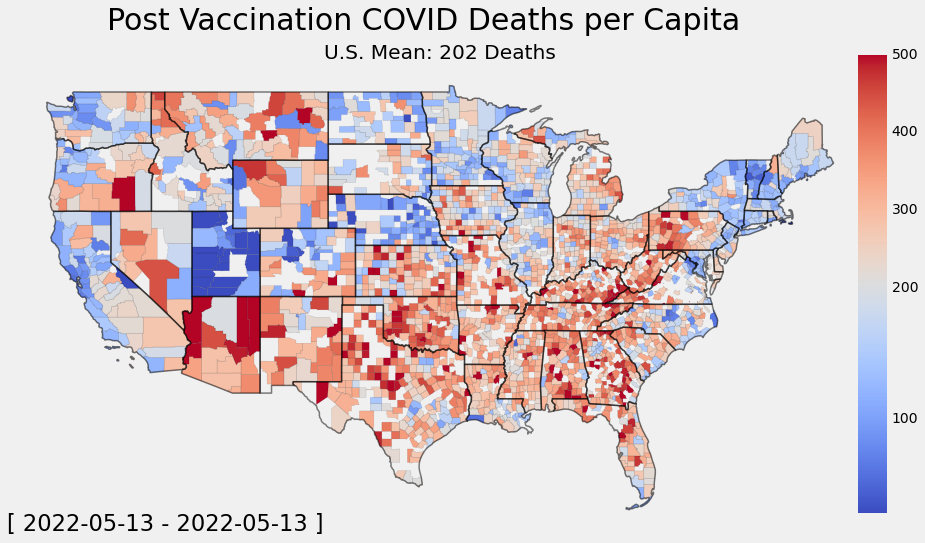

In [44]:
#cd.l()
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]


display(df.columns)
cmap = cm.coolwarm
geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df,left_on="GEOID",right_on="FIPS")
display(df['pv_beds_covid_tot_100k'].describe())
display(df['pv_beds_covid_tot_100k'].hist())
column = 'vax_pct'
center = round(cd.get('us_cdvh_df')[column].iloc[-1],3)*100
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Vaccines per Capita",
    title=f"U.S. Mean: {center:,}% Vaccines",
    cmap='coolwarm',
    reverse=True,
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmax=90000
    )

column = 'pv_New_Confirm_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Total COVID Confirmed Cases per Capita",
    title=f"U.S. Mean: {center:,} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )


column = 'pv_beds_covid_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df[geo_df[column] > 10], 
    column=column,
    vcenter=center,
    suptitle="Post Vaccination COVID Hospitalizations per Capita",
    title=f"U.S. Mean: {center:,} Hospitalizations",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    std=1
    #vmax=13908,
    
    )


column = 'pv_icu_covid_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df[geo_df[column] > 10], 
    column=column,
    vcenter=center,
    suptitle="Post Vaccination COVID ICU per Capita",
    title=f"U.S. Mean: {center:,} ICU",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    std=1
     #vmax=us_total_icu_mean*2,
    #vmin=int(us_total_icu_mean/2)

    )


column = 'pv_New_Deaths_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccination COVID Deaths per Capita",
    title=f"U.S. Mean: {center:,} Deaths",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=100,
    #vmax=1000,
     
    )







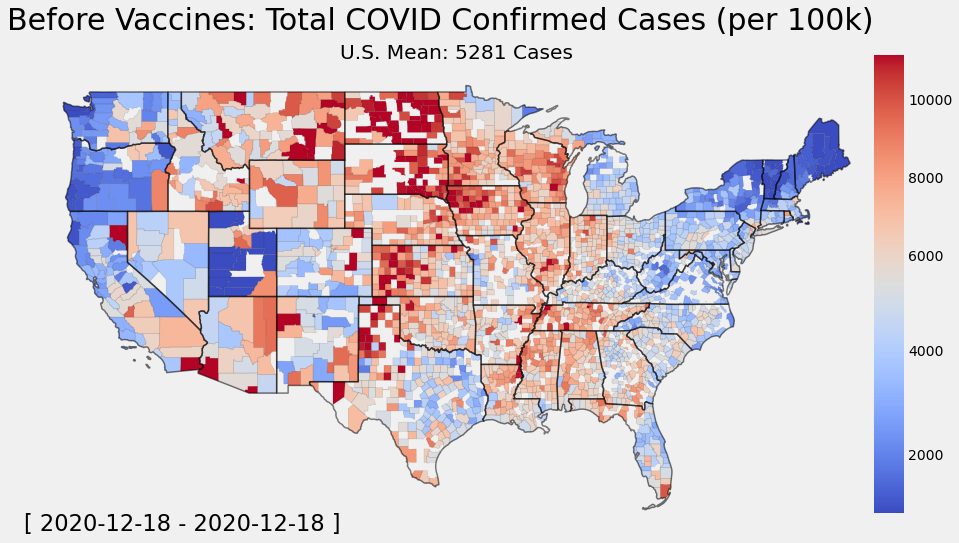

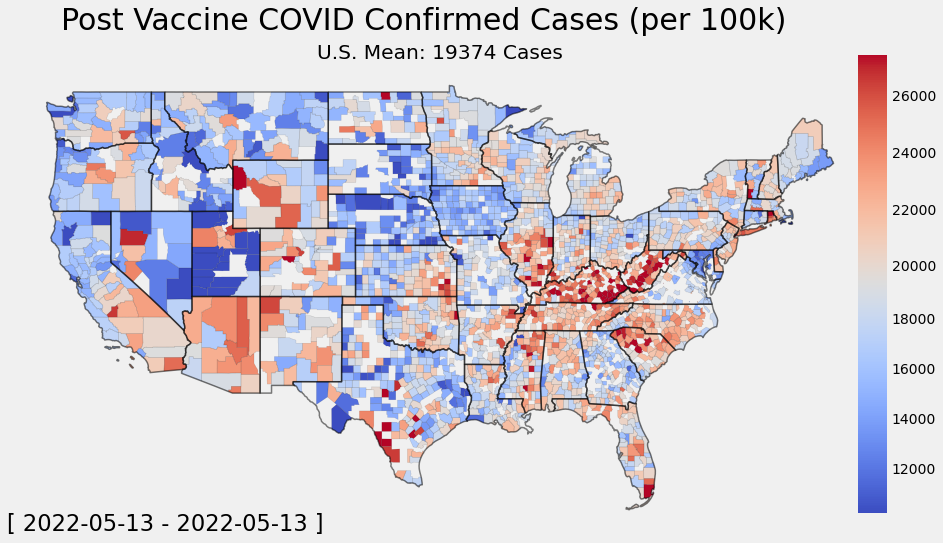

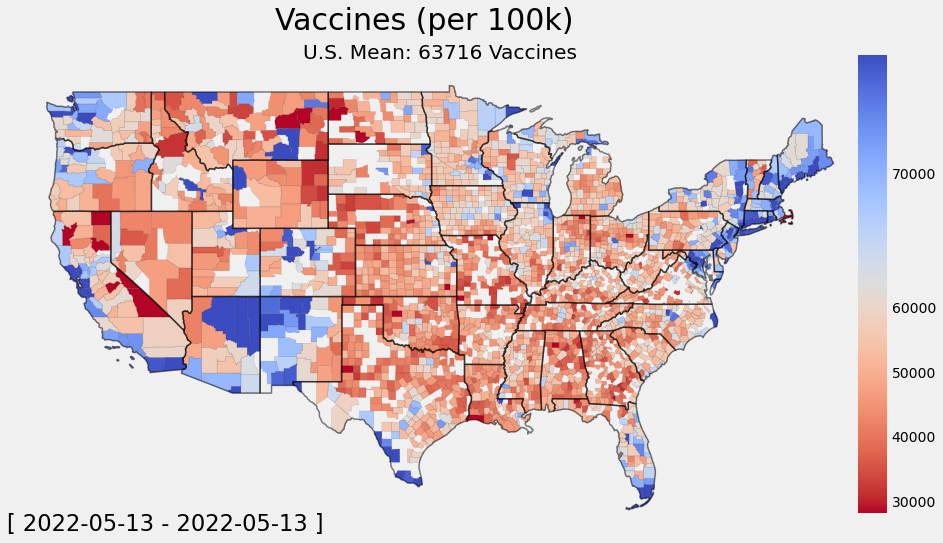

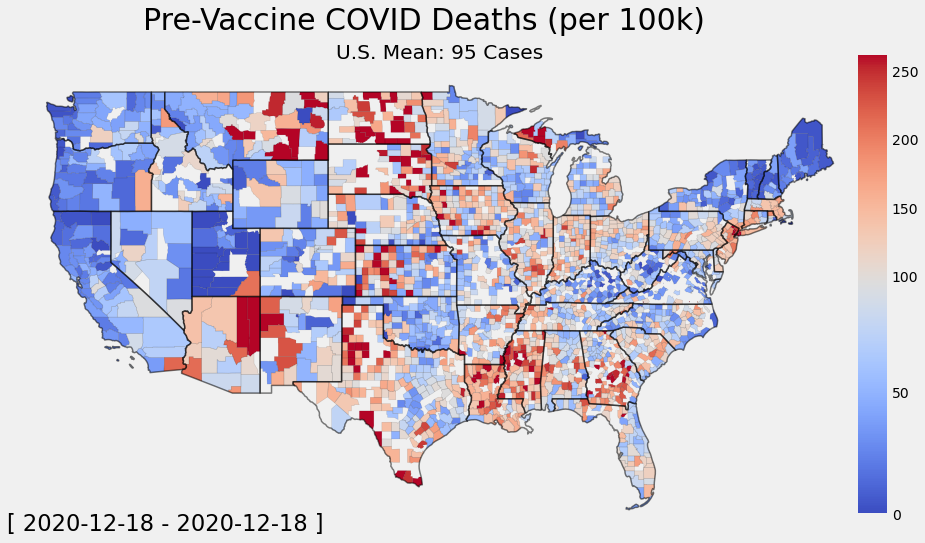

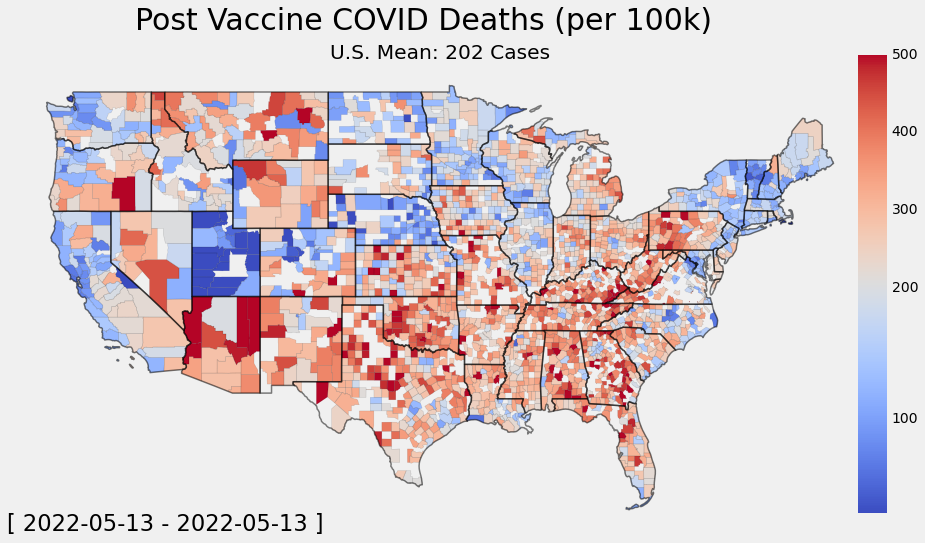

In [45]:
df_bv = cd.get('week_cdvh_df').copy()
df_bv = df_bv[df_bv["Date"]== df_bv["Date"].min()]

#display(df_bv.columns)
bv_geo_df = cd.get("county_geo_df").copy().merge(df_bv,left_on="GEOID",right_on="FIPS")

#display(df.columns)

column = 'tot_confirm_100k'
center = cd.get('us_cdvh_df').iloc[0][column]
process_covid.qgeo(bv_geo_df, 
    column=column,
    vcenter=center,
    suptitle="Before Vaccines: Total COVID Confirmed Cases (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )

column = 'pv_New_Confirm_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccine COVID Confirmed Cases (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )


column = 'vax_ct_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Vaccines (per 100k)",
    title=f"U.S. Mean: {center} Vaccines",
    cmap='coolwarm',
    reverse=True,
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmax=90000
    )


column = 'tot_deaths_100k'
center = cd.get('us_cdvh_df').iloc[0][column]
process_covid.qgeo(bv_geo_df, 
    column=column,
    vcenter=center,
    suptitle="Pre-Vaccine COVID Deaths (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )

column = 'pv_New_Deaths_tot_100k'
center = cd.get('us_cdvh_df')[column].iloc[-1] #//*** Center Results on National Mean
process_covid.qgeo(geo_df, 
    column=column,
    vcenter=center,
    suptitle="Post Vaccine COVID Deaths (per 100k)",
    title=f"U.S. Mean: {center} Cases",
    figsize=(15,8),
    state_geo = cd.get('state_geo_df'),
    #vmin=5000,
    #vmax = 44157,
    )



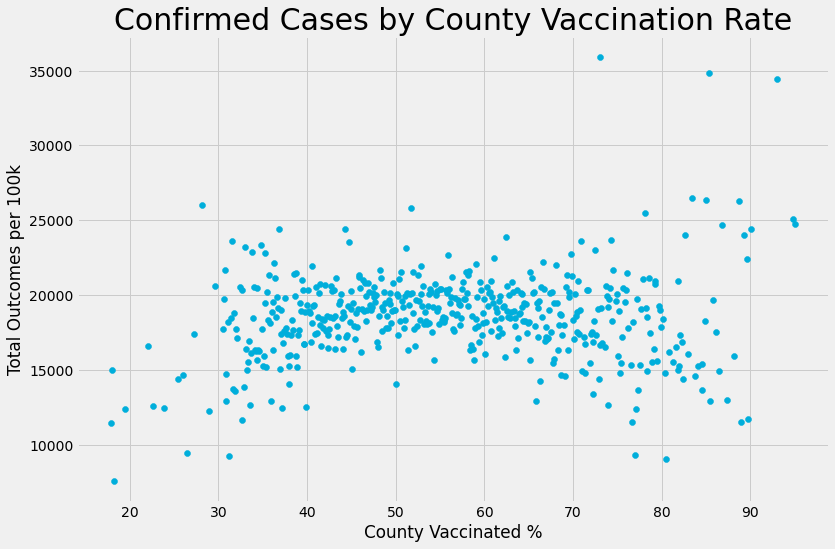

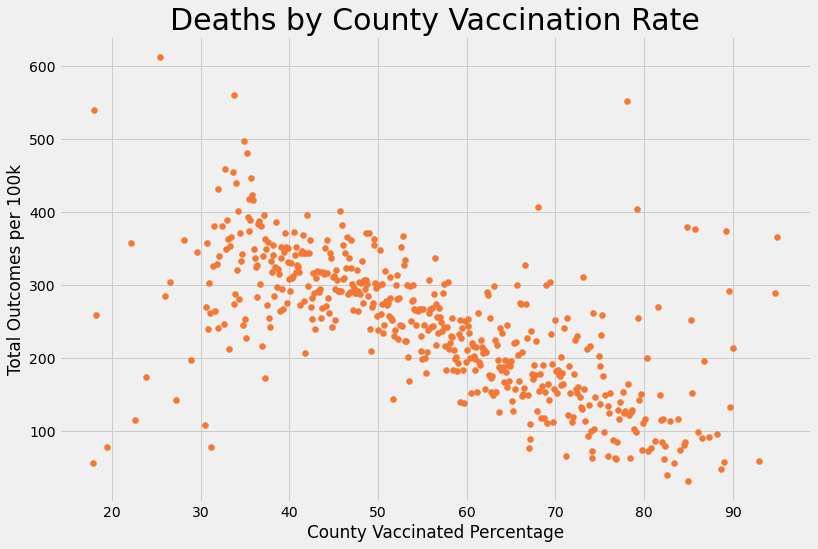

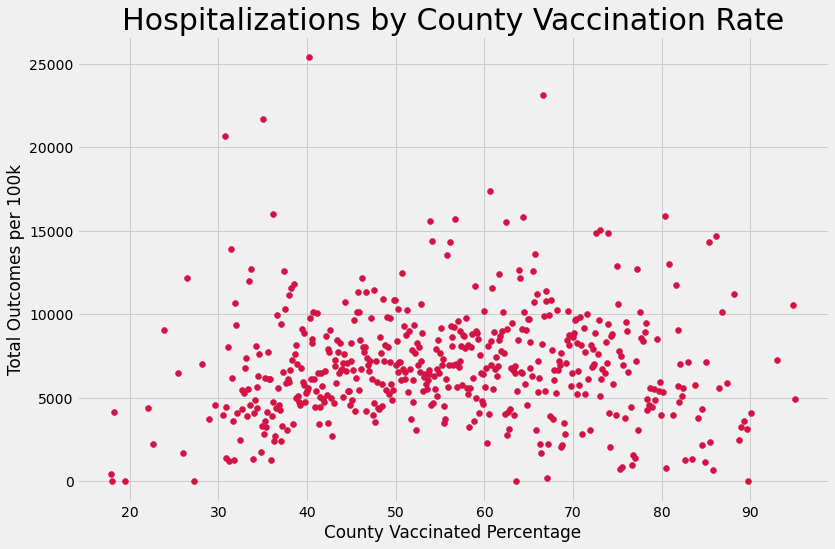

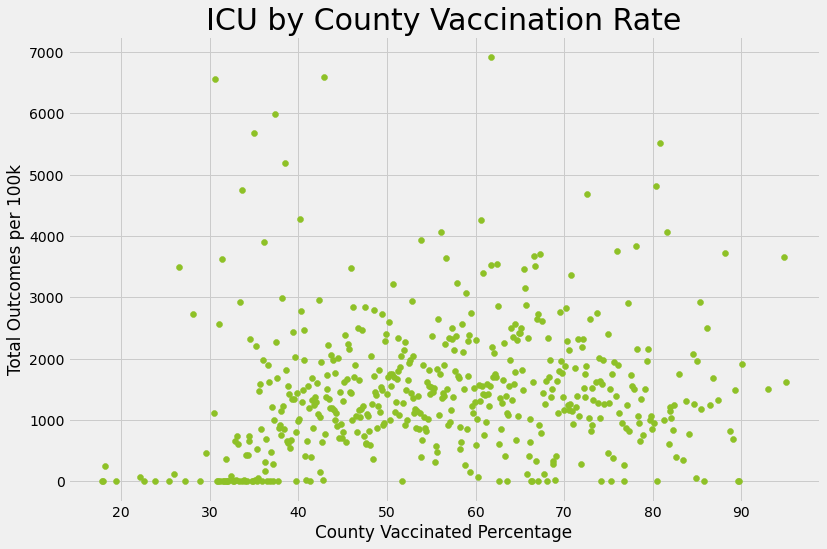

In [46]:
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]




column = 'pv_New_Confirm_tot_100k'
p = { "x" : [], "y" : [] }
for x in df['vax_pct'].unique():
    p["x"].append(x)
    p["y"].append(df[df['vax_pct'] == x][column].mean())

plt.figure(figsize=(12, 8))
plt.title("Confirmed Cases by County Vaccination Rate",fontsize=fontsize*1.5)
plt.scatter(p["x"],p["y"],color=color_dict['c'])
plt.xlabel("County Vaccinated %")
plt.ylabel("Total Outcomes per 100k")
plt.show()



column = 'pv_New_Deaths_tot_100k'
p = { "x" : [], "y" : [] }
for x in df['vax_pct'].unique():
    p["x"].append(x)
    p["y"].append(df[df['vax_pct'] == x][column].mean())

plt.figure(figsize=(12, 8))
plt.title("Deaths by County Vaccination Rate",fontsize=fontsize*1.5)
plt.scatter(p["x"],p["y"],color=color_dict['d'])
plt.xlabel("County Vaccinated Percentage")
plt.ylabel("Total Outcomes per 100k")
plt.show()


column = 'beds_covid_tot_100k'
max_val = df[column].mean() + (df[column].std()*2)
p = { "x" : [], "y" : [] }

for x in df['vax_pct'].unique():
    if df[df['vax_pct'] == x][column].mean() > max_val:
        continue
    p["x"].append(x)
    p["y"].append(df[df['vax_pct'] == x][column].mean())

plt.figure(figsize=(12, 8))
plt.title("Hospitalizations by County Vaccination Rate",fontsize=fontsize*1.5)
plt.scatter(p["x"],p["y"],color=color_dict['h'])
plt.xlabel("County Vaccinated Percentage")
plt.ylabel("Total Outcomes per 100k")
plt.show()

column = 'icu_covid_tot_100k'
max_val = df[column].mean() + (df[column].std()*2)
p = { "x" : [], "y" : [] }
for x in df['vax_pct'].unique():
    if df[df['vax_pct'] == x][column].mean() > max_val:
        continue
    p["x"].append(x)
    p["y"].append(df[df['vax_pct'] == x][column].mean())

plt.figure(figsize=(12, 8))
plt.title("ICU by County Vaccination Rate",fontsize=fontsize*1.5)
plt.scatter(p["x"],p["y"],color=color_dict['i'])
plt.xlabel("County Vaccinated Percentage")
plt.ylabel("Total Outcomes per 100k")
plt.show()

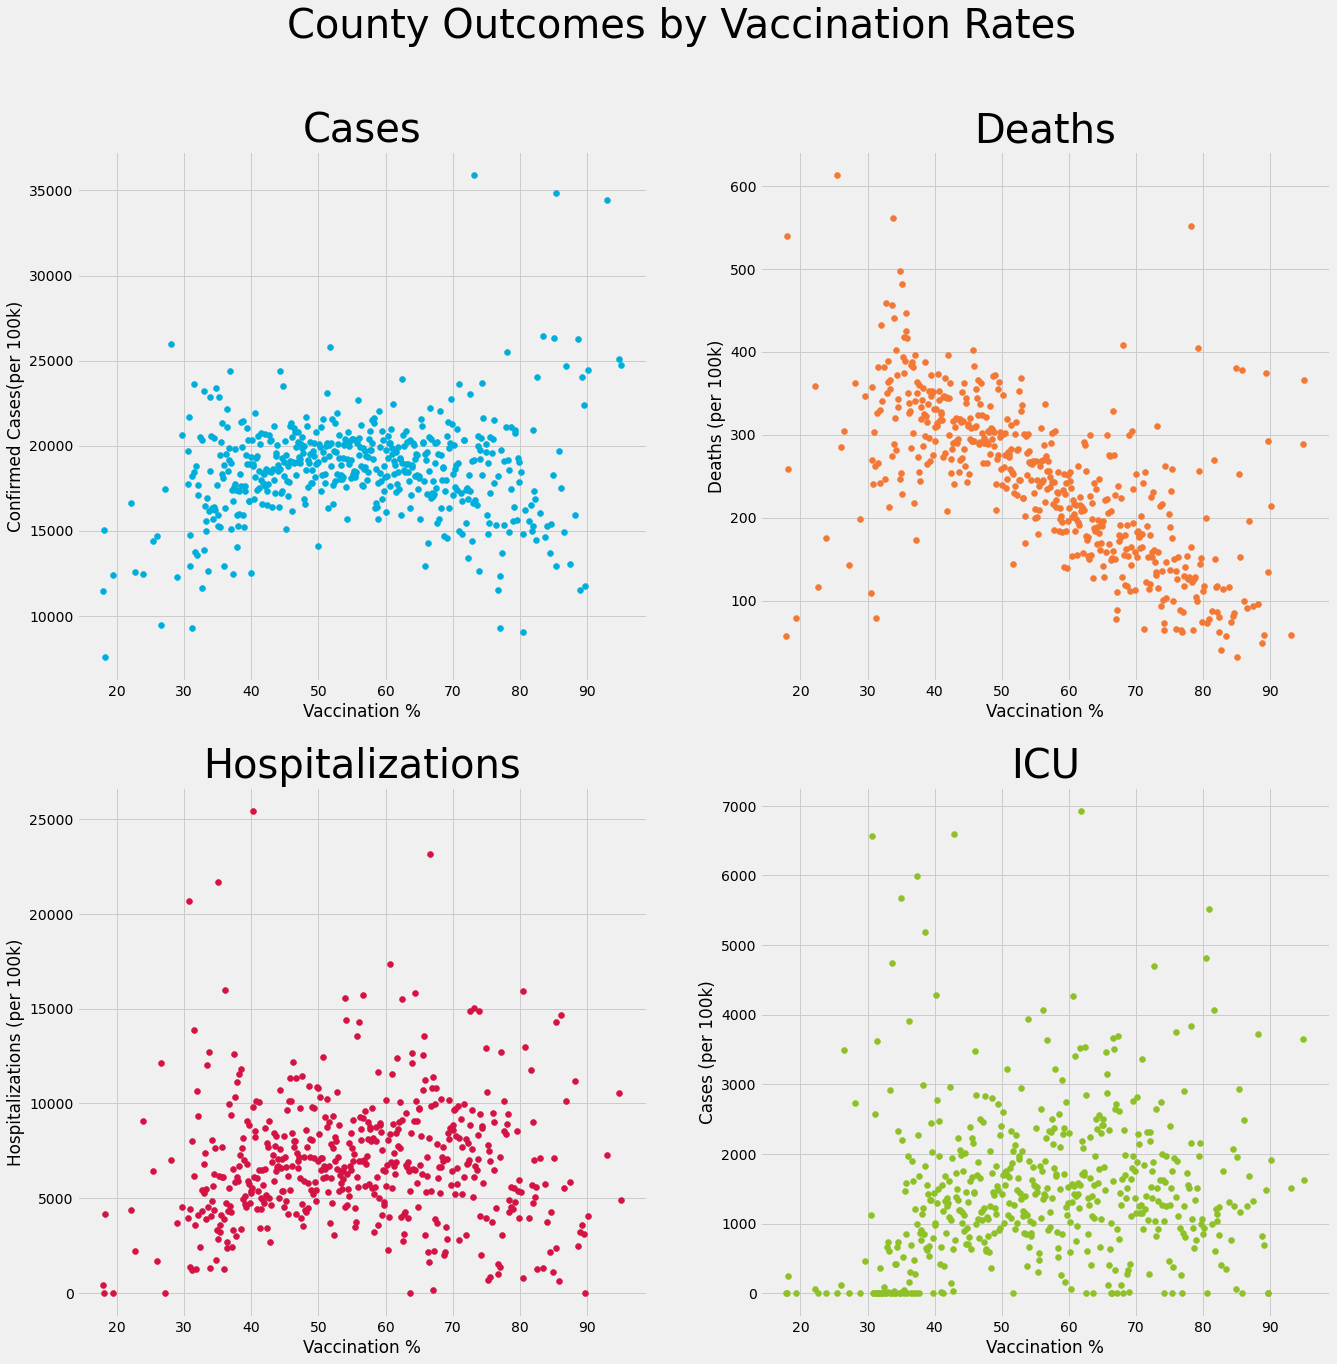

In [47]:
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

column = 'pv_New_Confirm_tot_100k'

p = { "x" : [], "y" : [] }
for x in df['vax_pct'].unique():
    p["x"].append(x)
    p["y"].append(df[df['vax_pct'] == x][column].mean())
plt.figure(figsize=(20, 20))
plt.suptitle("County Outcomes by Vaccination Rates",fontsize=fontsize*2)
plt.subplot(2, 2, 1)#//*** Left Boxx



plt.scatter(p["x"],p["y"],color=color_dict['c'])
plt.title("Cases",fontsize=fontsize*2)
plt.xlabel("Vaccination %")
plt.ylabel("Confirmed Cases(per 100k)")
xticks = mtick.PercentFormatter(0.5)
ax.xaxis.set_major_formatter(xticks)


column = 'pv_New_Deaths_tot_100k'
p = { "x" : [], "y" : [] }
for x in df['vax_pct'].unique():
    p["x"].append(x)
    p["y"].append(df[df['vax_pct'] == x][column].mean())
plt.subplot(2, 2, 2)#//*** Left Boxx
plt.scatter(p["x"],p["y"],color=color_dict['d'])
plt.title("Deaths",fontsize=fontsize*2)
plt.xlabel("Vaccination %")
plt.ylabel("Deaths (per 100k)")


column = 'beds_covid_tot_100k'
max_val = df[column].mean() + (df[column].std()*2)
p = { "x" : [], "y" : [] }

for x in df['vax_pct'].unique():
    if df[df['vax_pct'] == x][column].mean() > max_val:
        continue
    p["x"].append(x)
    p["y"].append(df[df['vax_pct'] == x][column].mean())

plt.subplot(2, 2, 3)#//*** Left Boxx
plt.scatter(p["x"],p["y"],color=color_dict['h'])
plt.title("Hospitalizations",fontsize=fontsize*2)
plt.xlabel("Vaccination %")
plt.ylabel("Hospitalizations (per 100k)")

column = 'icu_covid_tot_100k'
max_val = df[column].mean() + (df[column].std()*2)
p = { "x" : [], "y" : [] }
for x in df['vax_pct'].unique():
    if df[df['vax_pct'] == x][column].mean() > max_val:
        continue
    p["x"].append(x)
    p["y"].append(df[df['vax_pct'] == x][column].mean())

plt.subplot(2, 2, 4)#//*** Left Boxx
plt.scatter(p["x"],p["y"],color=color_dict['i'])
plt.title("ICU",fontsize=fontsize*2)
plt.xlabel("Vaccination %")
plt.ylabel("Cases (per 100k)")

plt.show()

# Working #

<a id="working"></a> 

[Top](#top)

# People Get vaccinated because of outcomes. In the highest vax Counties. That doesn't hold if Vax Rate is constant #

In [48]:
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
display(df['vax_pct'].values)
q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)




array([44.4, 51.1, 45.5, ..., 51.6, 43.9, 38. ])

# Build IQR Vax Collection #

count    2415.000000
mean       52.619503
std        11.728114
min        17.900000
25%        44.050000
50%        51.300000
75%        59.400000
max        95.000000
Name: vax_pct, dtype: float64

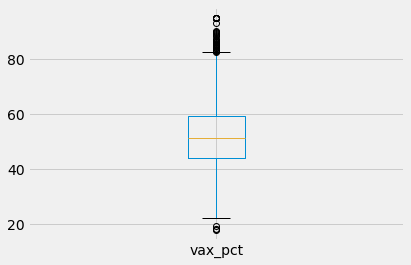

None

Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_uti

604
Counties: 604 Rows: 44674 POP:  18 Million
1202
Counties: 1202 Rows: 88758 POP:  96 Million
609
Counties: 609 Rows: 45059 POP:  198 Million
Collected Dataframe Count:  3
[low] Desc: IQR Low Vaccine Counties  (44.05% <) 
[med] Desc: IQR Medium Vaccine Counties, (44.05% - 59.4%)
[high] Desc: IQR High Vaccine Counties, (59.4%) >


In [49]:
reload(process_covid)
vax_collection_IQR = process_covid.collect_dataframes()

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

q1 = 50
q3 = 80
q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)

agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid', 'icu_covid']
agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
dfs = []
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
display(df['vax_pct'].describe())

#display(df['vax_pct'].hist())
gp = df.boxplot(column='vax_pct')
gp.plot()
display(plt.show())

display(df.columns)
counter = 0
vax_FIPS = {}
#//*** Aggregate and collect High Med Low Vax Counties
for df in [df[df["vax_pct"] < q1],df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)],df[df["vax_pct"] >= q3]]:
    #//**** get a FIPS list for the COunties in current vax tier
    vax_cty = list(df['FIPS'].unique())

    print(len(vax_cty))
    loop_df = cd.get('week_cdvh_df').copy()
    loop_df = loop_df[loop_df['FIPS'].isin(vax_cty)]
    print("Counties:",len(vax_cty), "Rows:",len(loop_df),"POP: ",int((loop_df['pop'].unique().sum())/1000000),"Million")
    pop = loop_df['pop'].unique().sum()
    

    #//*** Build Dictionary to aggregate all columns in agg_cols
    agg_dict = {}

    for col in agg_cols:
        agg_dict[col] = ['sum']

    #//*** Nast Tyoe Conversion!
    loop_df = loop_df.groupby('Date').agg(agg_dict)
    loop_df.columns=agg_cols
    #loop_df['pop'] = pop
    
    loop_df['vax_pct'] = loop_df['vax_ct'] / loop_df['pop']
    loop_df['count'] = len(vax_cty)
    #loop_df = process_covid.build_100k(loop_df,cols=agg_cols)
    loop_df = loop_df.reset_index()
    #loop_df = loop_df[loop_df['vax_pct'] > .2]
    loop_df = process_covid.standard_recalc_cols(loop_df)
    
    
    counter += 1
    
    if counter == 1:
        vax_collection_IQR.add(loop_df,'low',f"IQR Low Vaccine Counties  ({q1}% <) ")
        vax_FIPS['low'] = vax_cty
    elif counter == 2:
        vax_collection_IQR.add(loop_df,'med',f"IQR Medium Vaccine Counties, ({q1}% - {q3}%)")
        vax_FIPS['med'] = vax_cty
    elif counter == 3:
        vax_collection_IQR.add(loop_df,'high',f"IQR High Vaccine Counties, ({q3}%) >")
        vax_FIPS['high'] = vax_cty
    
vax_collection_IQR.l()



40.89138926455318

52.61950310559006

64.34761694662694

count    2415.000000
mean       52.619503
std        11.728114
min        17.900000
25%        44.050000
50%        51.300000
75%        59.400000
max        95.000000
Name: vax_pct, dtype: float64

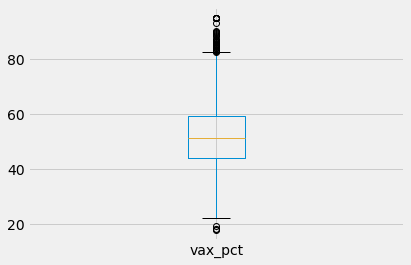

None

Index(['Date', 'FIPS', 'Recip_State', 'vax_pct', 'vax_ct', 'cty',
       'Combined_Key', 'pop', 'tot_confirm', 'tot_deaths', 'New_Confirm',
       'New_Deaths', 'state', 'beds', 'beds_used', 'beds_covid', 'all_icu',
       'icu_used', 'icu_covid', 'pv_New_Confirm_tot', 'pv_New_Deaths_tot',
       'beds_covid_tot', 'icu_covid_tot', 'beds_tot', 'beds_used_tot',
       'all_icu_tot', 'icu_used_tot', 'pv_beds_covid_tot', 'pv_icu_covid_tot',
       'pv_beds_tot', 'pv_beds_used_tot', 'pv_all_icu_tot', 'pv_icu_used_tot',
       'tot_confirm_100k', 'tot_deaths_100k', 'New_Confirm_100k',
       'New_Deaths_100k', 'pv_New_Confirm_tot_100k', 'pv_New_Deaths_tot_100k',
       'beds_covid_100k', 'icu_covid_100k', 'beds_covid_tot_100k',
       'icu_covid_tot_100k', 'pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',
       'vax_ct_100k', 'pv_beds_tot_100k', 'pv_beds_used_tot_100k',
       'pv_all_icu_tot_100k', 'pv_icu_used_tot_100k', 'all_bed_util',
       'covid_bed_util', 'icu_util', 'icu_covid_uti

355
Counties: 355 Rows: 26255 POP:  9 Million
1686
Counties: 1686 Rows: 124566 POP:  150 Million
374
Counties: 374 Rows: 27670 POP:  154 Million
Collected Dataframe Count:  3
[low] Desc: STD Low Vaccine Counties  (40.89138926455318% <) 
[med] Desc: STD Medium Vaccine Counties, (40.89138926455318% - 64.34761694662694%)
[high] Desc: STD High Vaccine Counties, (64.34761694662694%) >


In [50]:

reload(process_covid)
vax_collection_STD = process_covid.collect_dataframes()

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

q1 = 50
q3 = 80
display(df['vax_pct'].mean() - df['vax_pct'].std(),df['vax_pct'].mean(),df['vax_pct'].mean() + df['vax_pct'].std())
q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)

#//*** Mean minus std Dev
q1 = df['vax_pct'].mean() - df['vax_pct'].std()

#//*** Mean plus std Dev
q3 = df['vax_pct'].mean() + df['vax_pct'].std()

agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid', 'icu_covid']
agg_cols = ['pop','vax_ct','tot_confirm','tot_deaths','beds_covid','icu_covid','beds','beds_used','all_icu','icu_used']
dfs = []
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
display(df['vax_pct'].describe())

#display(df['vax_pct'].hist())
gp = df.boxplot(column='vax_pct')
gp.plot()
display(plt.show())

display(df.columns)
counter = 0
vax_FIPS = {}
#//*** Aggregate and collect High Med Low Vax Counties
for df in [df[df["vax_pct"] < q1],df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)],df[df["vax_pct"] >= q3]]:
    #//**** get a FIPS list for the COunties in current vax tier
    vax_cty = list(df['FIPS'].unique())

    print(len(vax_cty))
    loop_df = cd.get('week_cdvh_df').copy()
    loop_df = loop_df[loop_df['FIPS'].isin(vax_cty)]
    print("Counties:",len(vax_cty), "Rows:",len(loop_df),"POP: ",int((loop_df['pop'].unique().sum())/1000000),"Million")
    pop = loop_df['pop'].unique().sum()
    #//*** Build Dictionary to aggregate all columns in agg_cols
    agg_dict = {}

    for col in agg_cols:
        agg_dict[col] = ['sum']

    #//*** Nast Tyoe Conversion!
    loop_df = loop_df.groupby('Date').agg(agg_dict)
    loop_df.columns=agg_cols
    #loop_df['pop'] = pop
    
    loop_df['count'] = len(vax_cty)
    loop_df['vax_pct'] = loop_df['vax_ct'] / loop_df['pop']
    #loop_df = process_covid.build_100k(loop_df,cols=agg_cols)
    loop_df = loop_df.reset_index()
    #loop_df = loop_df[loop_df['vax_pct'] > .2]
    loop_df = process_covid.standard_recalc_cols(loop_df)
    
    
    counter += 1
    
    if counter == 1:
        vax_collection_STD.add(loop_df,'low',f"STD Low Vaccine Counties  ({q1}% <) ")
        vax_FIPS['low'] = vax_cty
    elif counter == 2:
        vax_collection_STD.add(loop_df,'med',f"STD Medium Vaccine Counties, ({q1}% - {q3}%)")
        vax_FIPS['med'] = vax_cty
    elif counter == 3:
        vax_collection_STD.add(loop_df,'high',f"STD High Vaccine Counties, ({q3}%) >")
        vax_FIPS['high'] = vax_cty
    
vax_collection_STD.l()



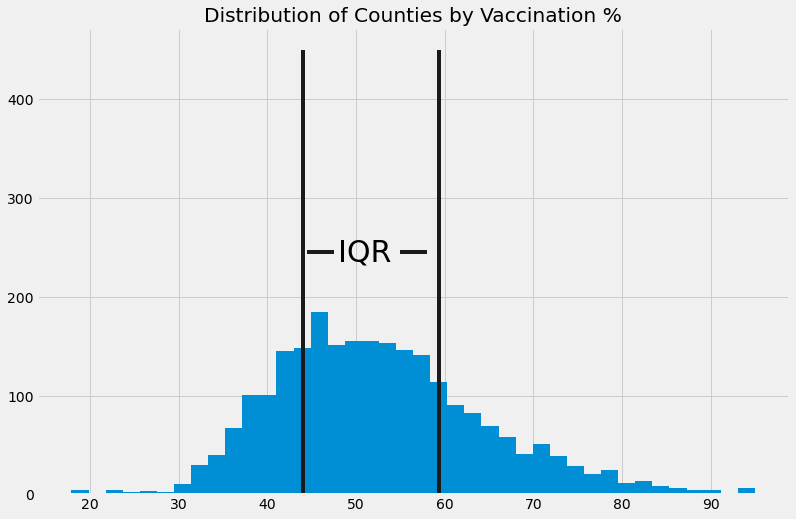

In [51]:
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
iqr_q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
iqr_q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)

df['vax_pct'].hist(figsize=[12, 8], bins=40)
plt.title("Distribution of Counties by Vaccination %")
plt.vlines(iqr_q1,ymin=0,ymax=450,color= (.1,.1,.1,1), linestyle="solid")
plt.vlines(iqr_q3,ymin=0,ymax=450,color= (.1,.1,.1,1), linestyle="solid")
plt.hlines(245,xmin=44.5,xmax=47.5,color= (.1,.1,.1,1), linestyle="solid")
plt.hlines(245,xmin=55,xmax=58,color= (.1,.1,.1,1), linestyle="solid")
plt.annotate("IQR",(.4,.5),xycoords='axes fraction',fontsize=fontsize*1.5)
xticks = mtick.PercentFormatter(1)
ax.xaxis.set_major_formatter(xticks)
plt.show()
#dfs = []
#for name in ['low','med','high']:
    
#    df = vax_collection_IQR.get(name)
#    df['type'] = name
#    dfs.append(df)

    




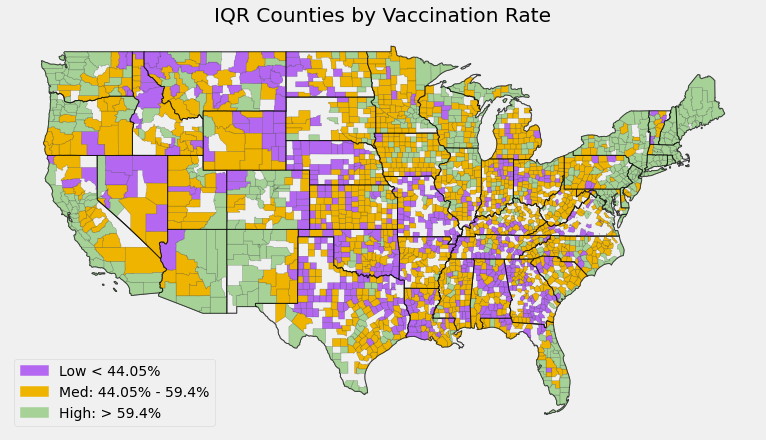

In [52]:
import matplotlib.patches as mpatches
df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

#vax_collection_iqr = 
iqr_q1 = np.nanquantile(df['vax_pct'].sort_values(),.25)
iqr_q3 = np.nanquantile(df['vax_pct'].sort_values(),.75)
#//*** Mean minus std Dev
std_q1 = df['vax_pct'].mean() - df['vax_pct'].std()

#//*** Mean plus std Dev
std_q3 = df['vax_pct'].mean() + df['vax_pct'].std()

#//*** IQR Counties
q1 = iqr_q1
q3 = iqr_q3


df=cd.get('week_cdvh_df').copy()
all_geo_df = cd.get("county_geo_df").copy()
all_geo_df = all_geo_df[all_geo_df["GEOID"].isin(df["FIPS"].unique() )]


df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]
df = df[df["vax_pct"] >= q3]
high_vax_cty = list(df['FIPS'].unique())
dfs=[]
df['type'] = "high"
dfs.append(df)

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

df = df[(df["vax_pct"] >= q1) & (df["vax_pct"] < q3)]
high_vax_cty = list(df['FIPS'].unique())
df['type'] = "med"
dfs.append(df)

df = cd.get('week_cdvh_df').copy()
df = df[df["Date"]== df["Date"].max()]

df = df[(df["vax_pct"] < q1)]
high_vax_cty = list(df['FIPS'].unique())
df['type'] = "low"
dfs.append(df)

df = pd.concat(dfs)

geo_df = cd.get("county_geo_df").copy()
geo_df = geo_df.merge(df[['FIPS','type']],left_on="GEOID",right_on="FIPS")

state_geo_df = cd.get('state_geo_df').copy()

#ax = df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.15),color=(1,1,1,0),ax=ax)

keep_state = geo_df['STATEFP'].unique()
all_state = state_geo_df['STATEFP'].unique()

for state in all_state:
    if state not in keep_state:
        state_geo_df = state_geo_df[state_geo_df['STATEFP'] != state]
        
ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0))
ax = geo_df[geo_df['type'] == "low"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['low'])
ax = geo_df[geo_df['type'] == "med"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['med'])
ax = geo_df[geo_df['type'] == "high"].plot(legend=True, ax=ax, linewidth=.5,edgecolor=(0,0,0,.3), color=color_dict['high'])
ax = state_geo_df.plot(categorical=True,legend=True, linewidth=1,edgecolor=(0,0,0,.5),color=(1,1,1,0),ax=ax)

ax.grid(False)
ax.axis('off')
fonstize=20
#plt.suptitle(suptitle,fontsize=fontsize)
plt.title("IQR Counties by Vaccination Rate")
#text = ""

#for col in ['low','med','high']:
#    text += f"{col.title()}: {len(df[df['type'] == col]['FIPS'].unique())} Counties Pop: {int(df[df['type'] == col]['pop'].sum()/1000000)} Million"
#    text+="\n"
#plt.annotate(text,(0,-.1),xycoords='axes fraction',fontsize=fontsize*1)


fig = ax.get_figure()
fig = plt.gcf()
fig.set_size_inches(12,8)
low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low < {q1}% ')
med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}%')
high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  ')
plt.legend(handles=[low_patch,med_patch,high_patch],loc="lower left")

plt.show()


Low 604 18 Million
Med 1202 96 Million
High 609 198 Million
low 314
med 255
high 166


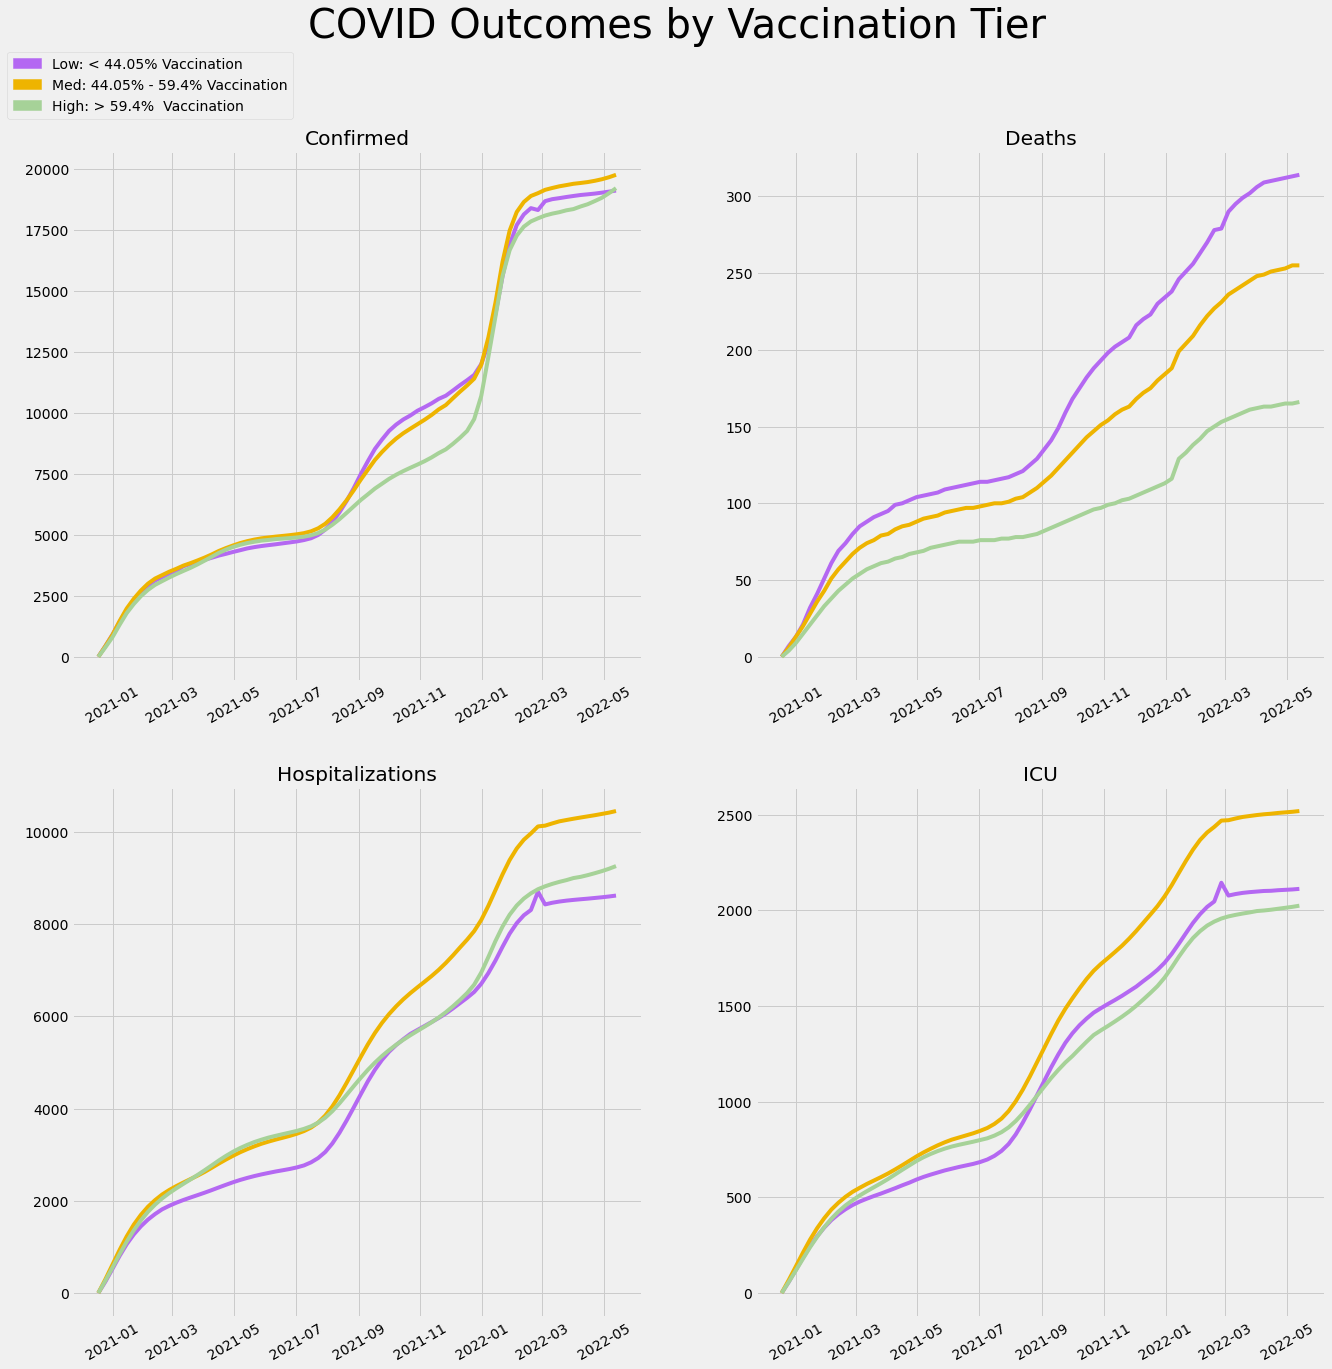

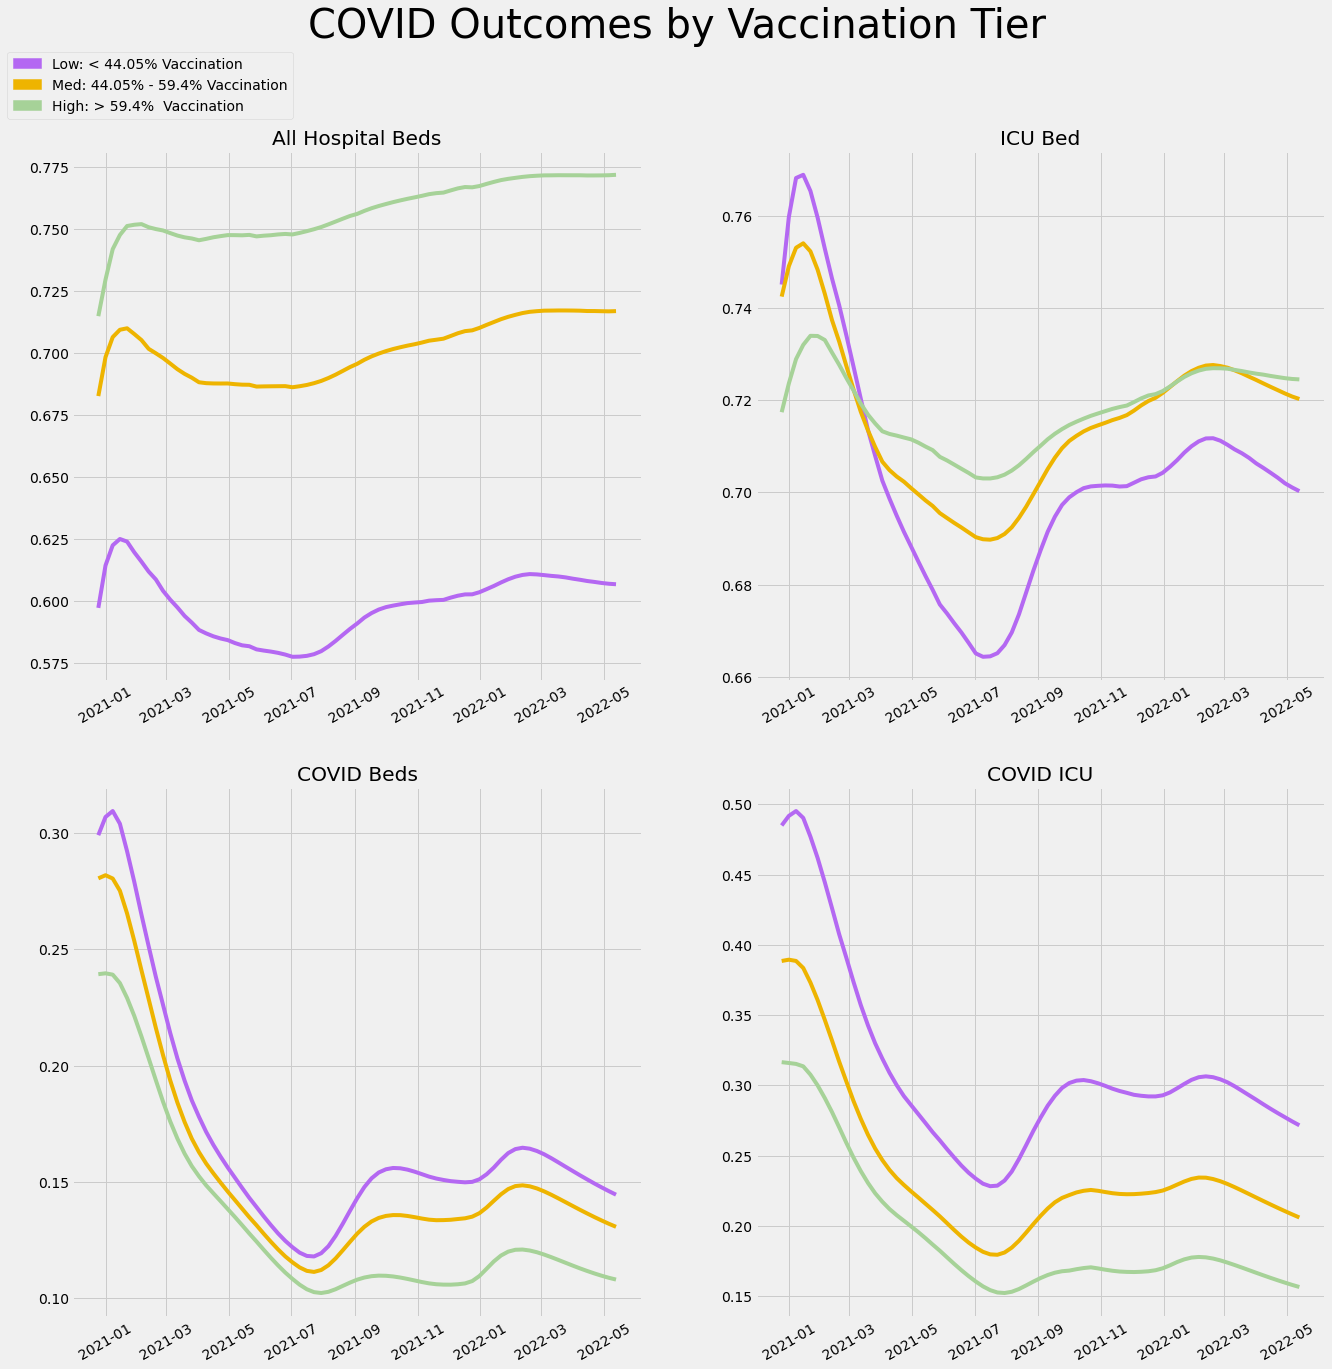

In [53]:
for name in ['low','med','high']:
    
    df = vax_collection_IQR.get(name)
    
    print(f"{name.title()} {df['count'].iloc[0]} {int(df['pop'].iloc[0]/1000000)} Million")

    
#plt.figure(figsize=(12, 8))

#for name in ['low','med','high']:
    
#    df = vax_collection_IQR.get(name)
    
#    plt.plot(df['Date'],df['vax_pct'],label=name, color=color_dict[name])
#plt.title("IQR Vax PCT by Date")

#plt.show()

counter = 1
plt.figure(figsize=(20, 20))
plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
for col in ['pv_New_Confirm_tot_100k','pv_New_Deaths_tot_100k','pv_beds_covid_tot_100k', 'pv_icu_covid_tot_100k',]:

    
    plt.subplot(2,2,counter)
        
    for name in ['low','med','high']:
        

        df = vax_collection_IQR.get(name)
        
        plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

        if col == 'pv_New_Deaths_tot_100k':
            print(name,df[col].max() )
    counter+=1
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
    plt.xticks(rotation=30)
    if col == 'pv_New_Confirm_tot_100k':
        plt.title(f"Confirmed")
        plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
    elif col == 'pv_New_Deaths_tot_100k':
        plt.title(f"Deaths")
    elif col == 'pv_beds_covid_tot_100k':
        plt.title(f"Hospitalizations")
    elif col == 'pv_icu_covid_tot_100k':
        plt.title(f"ICU")
    
    #plt.legend()
plt.show()

base_name = "util_hosp_quad"
project_dir = current_dir.joinpath(ignore_folder).joinpath(base_name)

#//*** Build folder if not exist
try:
    os.mkdir(project_dir)
except:
    pass

#//*** Delete and files in folder 
for file in os.listdir(project_dir):

    try:
        os.remove(project_dir.joinpath(file)) 
    except:
        pass

font = {"size":15}
#,'tot_confirm_100k','tot_deaths_100k','all_bed_util', 'covid_bed_util', 'icu_util', 'icu_covid_util'

counter = 1
plt.figure(figsize=(20, 20))
plt.suptitle("COVID Outcomes by Vaccination Tier",fontsize=fontsize*2)
for col in ['all_bed_util','icu_util','covid_bed_util', 'icu_covid_util',]:

    
    plt.subplot(2,2,counter)
        
    for name in ['low','med','high']:
        

        df = vax_collection_IQR.get(name)
        
        plt.plot(df['Date'],df[col],label=name, color=color_dict[name])

        if col == 'pv_New_Deaths_tot_100k':
            print(name,df[col].max() )
    counter+=1
    low_patch = mpatches.Patch(color=color_dict['low'], label=f'Low: < {q1}% Vaccination')
    med_patch = mpatches.Patch(color=color_dict['med'], label=f'Med: {q1}% - {q3}% Vaccination')
    high_patch = mpatches.Patch(color=color_dict['high'], label=f'High: > {q3}%  Vaccination')
    plt.xticks(rotation=30)
    #plt.legend(handles=[low_patch,med_patch,high_patch],loc="upper left")
    if col == 'all_bed_util':
        plt.title(f"All Hospital Beds")
        plt.legend(handles=[low_patch,med_patch,high_patch],bbox_to_anchor=(.4,1.2,0,0))
        
    elif col == 'icu_util':
        plt.title(f"ICU Bed")
    elif col == 'covid_bed_util':
        plt.title(f"COVID Beds")
    elif col == 'icu_covid_util':
        plt.title(f"COVID ICU")
    
    #plt.legend()
filename=f"{str(1).zfill(3)}_{base_name}.png"
plt.savefig(project_dir.joinpath(filename))
plt.show()
